In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import optax
# from parent_dir import *
from reupload_ff_circuit.data_gen import data_generator


import os
import ipynbname  

from reupload_ff_circuit.util import *
from reupload_ff_circuit.q_functions import *
from reupload_ff_circuit.q_circuits import *

In [2]:
# Added to silence some warnings.
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')

In [3]:
# nb_fname = ipynbname.name()
# ver = nb_fname[nb_fname.index('v'):nb_fname.index('_')] if 'v' in nb_fname else nb_fname
date, day = time.strftime("%Y%m%d-%H%M"), time.strftime("%Y%m%d-%H")
cwd = os.getcwd()

In [4]:
ver = 'Demo_v1.0'
problem = 'breast_cancer' #'3 circles'#'moon'#
shape =  "tetrahedron"#"binary" #"bitwise" #"square plane"#
rot = 'zyz' #'yzy' #'xzx' #
num_training = 200 #400
num_test = 50 #100

max_n_converge = 10
thres_converge = 0.0001
seed_num = data_seed_num= 40#

In [5]:
training_noise =  False  #True#,
test_noise = False  #True#,

In [6]:
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")  # ibm_strasbourg # 
# print('backend:', backend.name)

In [7]:
configs = {'noise': False,  #####
           'fake_backend': False,    #True#,
           'real_device':  False,    #True#
           'preprocess' : "scaling",  #None #  "normalization"# "standardization" #
           # 'backend' : backend,
           'backend_name' : None, #'ibm_brisbane', # 'ibm_strasbourg', # '''None means least_busy backend'''
           'rot' : rot, 
           'shape' : shape,
          }

In [8]:
import random
num_cvs = 5
num_seeds = 10
random.seed(seed_num)
seeds = [random.randint(0, int(1e5)) for _ in range(num_seeds)]
seeds

[60110, 75954, 68678, 4174, 32150, 37018, 87104, 83505, 87073, 27044]

In [9]:
# set range of aubits and rotations
num_settings = 1, 1, 3, 1, 1 # r_enc, r_q ,r_f, r_r, r_rot ## run the setting with n values
start_values = 5, 1, 1, 1, 2 # e0, q0, f0, r0, rot0 

settings = setting_generator(num_settings,start_values)
# settings=settings[:3]

In [10]:
h_params= {'lr':[[0.15,0.05,0.01],[0.15,0.05,0.01,0.001,0.0001]],  #
           'max_epoch':[600],#3200
           'batch_size':[50,100,300],
           'dynamic_size':[50],
           'thres':[[0.05,0.03,0.01]]}#]}#[0.05],
h_pms = [(tuple(i),j,k,l,tuple(m)) for i in h_params['lr'] for j in h_params['max_epoch'] for k in h_params['batch_size'] for l in h_params['dynamic_size'] for m in h_params['thres']]
h_pms

[((0.15, 0.05, 0.01), 600, 50, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01), 600, 100, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01), 600, 300, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 50, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 100, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 300, 50, (0.05, 0.03, 0.01))]

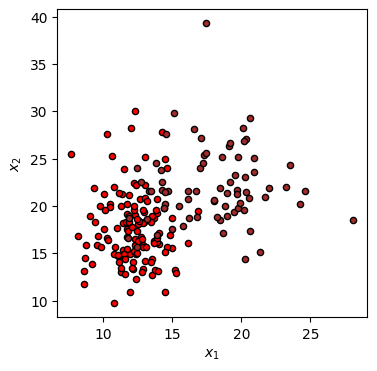

In [11]:
Xdata, ydata = data_gen(problem,num_training)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


theta = [0.         1.91063324 1.91063324 1.91063324] 
phi = [0.         2.0943951  4.1887902  6.28318531]
c_states= [[[ 1.        +0.00000000e+00j]
  [ 0.        +0.00000000e+00j]]

 [[ 0.57735027+0.00000000e+00j]
  [-0.40824829+7.07106781e-01j]]

 [[ 0.57735027+0.00000000e+00j]
  [-0.40824829-7.07106781e-01j]]

 [[ 0.57735027+0.00000000e+00j]
  [ 0.81649658-1.99983985e-16j]]] 
shape: (4, 2, 1)


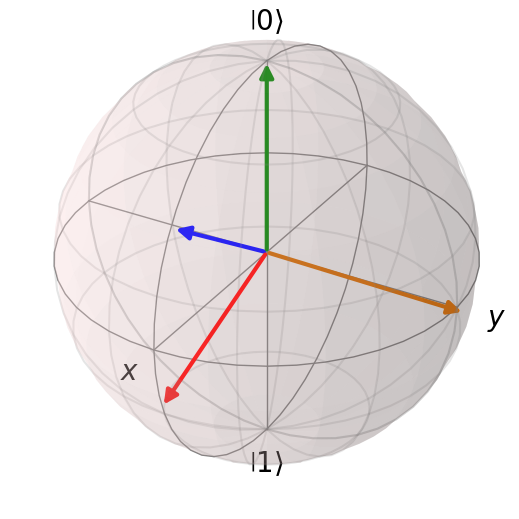

In [12]:
# Define output labels as quantum state vectors
num_class = np.unique(data_gen(problem)[1]).max()+1
c_states, dm_labels, Yc = predefined_states_dm(shape,settings[0][1]) #(shape,num_qubits)
configs['dm_labels'] = dm_labels
configs['num_class_1q'] = len(c_states)
configs['Yc'] = totuple(Yc)

In [13]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation,
        opt_state,x,y,*args,x_valid=None,y_valid=None,**kwargs) -> optax.Params:
  #opt_state = optimizer.init(params)
  # for k, v in kwargs.items():
  #   if 'noise' in k:
  #       noise = v
  def step(params, opt_state,x,y):
    loss_batches = jnp.array([])
    predicted_train = jnp.array([])
    iter_batch = iterate_minibatches(x, y, batch_size=batch_size)
    for x_batch, y_batch in iter_batch:
        predicted_batch, loss_batch , grads = jtest(params, x_batch, y_batch,*args,**kwargs)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss_batches = jax.numpy.append(loss_batches,loss_batch)
        predicted_train = jax.numpy.append(predicted_train, predicted_batch)
    loss_value = jnp.average(loss_batches)
    return params, opt_state, loss_value, predicted_train
  n_converge = 0
  
  learning_rate,max_epoch,batch_size,dynamic_size,threshold = kwargs['_h_pm']
  iter_lr = kwargs['iter_lr']
  iter_thres = kwargs['iter_thres']
  lr = kwargs['lr']
  thres_n = kwargs['thres_n']
  

  #loss_history = []
  params_history = []
  state_history = []
  valid_accuracy_history=[]
  ave_loss = 1
  l_r = lr
  thres = thres_n
  for i  in range(max_epoch):
    i=i+1
    state_history.append(opt_state) #save value advance otherwise it saves the updated one
    params_history.append(params)
    
    params, opt_state, loss_value , predicted_train= step(params, opt_state, x, y)
    accuracy_train = accuracy_score(y, predicted_train)
    if i%100 ==0:
        print(f'step {i}, accuracy_train:{accuracy_train}, loss: {loss_value}')
        
    if x_valid is not None and y_valid is not None:
        accuracy_valid, loss_valid = scores(params, x_valid, y_valid, *args, **kwargs)
        valid_loss_history.append(float(loss_valid))
        valid_accuracy_history.append(float(accuracy_valid))
    loss_history.append(float(loss_value))    
    accuracy_history.append(float(accuracy_train))

    if i%dynamic_size==0:
        c_ave = sum(loss_history[-dynamic_size:])/dynamic_size #current loss average
        now_thres = abs(c_ave-ave_loss)/ave_loss
        print(now_thres)
        if  now_thres<=thres:
            try:
                l_r=next(iter_lr)#learning_rate
                #loc_best_accuracy = np.argmax(accuracy_history[-dynamic_size:])-dynamic_size
                loc_best_loss = np.argmin(loss_history[-dynamic_size:])-dynamic_size
                params = params_history[loc_best_loss]
                #print('best known accuracy:', accuracy_history[loc_best_accuracy]) #update lr based on accuracy
                print('accuracy of best loss :', accuracy_history[loc_best_loss]) #update lr based on loss
                
                opt_state.hyperparams['learning_rate'] = l_r
                #print('lr:', l_r, opt_state.hyperparams['learning_rate'])
                try:
                    thres = next(iter_thres)
                except StopIteration:
                    print(thres)
            except StopIteration:
                pass
        print('lr:', l_r, opt_state.hyperparams['learning_rate'])
        print(i)
        n_converge  = n_converge+1 if now_thres<thres_converge else 0
        ave_loss = c_ave
        
    if i==max_epoch or n_converge==max_n_converge:
        n_converge = 1 if n_converge==0 else n_converge 
        #loc_best_accuracy = np.argmax(accuracy_history[-dynamic_size*10:])-dynamic_size*10
        candidate_history = loss_history if x_valid is None else valid_loss_history
        loc_best_loss = np.argmin(candidate_history[-dynamic_size*n_converge:])-dynamic_size*n_converge
        params = params_history[loc_best_loss]
        opt_state = state_history[loc_best_loss]
        num_epoch = i
        print('lr:', l_r, opt_state.hyperparams['learning_rate'])
        print('accuracy of best loss:',accuracy_history[loc_best_loss],loc_best_loss)
        #print('best known accuracy:',accuracy_history[loc_best_loss],loc_best_loss)
        break
  return params, l_r, opt_state, num_epoch

In [14]:
if '-' not in ver:
    # ver = ver+f'_lay{num_layers}'
    ver = ver+'_'+configs['backend_name']+'_'+date if configs['noise'] else ver+'_'+date
#print(os.getcwd())
filename = ver[:ver.index('_')]
os.chdir(cwd)
if not os.path.exists('Figures/'+filename+'/'+day):
    if not os.path.exists('Figures/'):
        os.mkdir('Figures/')
    try:
        os.mkdir('Figures/'+filename)
        os.mkdir('Figures/'+filename+'/'+day)
        os.chdir('Figures/'+filename+'/'+day)
    except FileExistsError:
        os.mkdir('Figures/'+filename+'/'+day)
        os.chdir('Figures/'+filename+'/'+day)
    except Exception as e:
        print(e)
else: os.chdir('Figures/'+filename+'/'+day)
print(os.getcwd())

/mnt/c/Users/paes20705/OneDrive/桌面/Main Programs/Python/Jupyter/Re-upload and feed-forward circuits/Figures/Demo/20241220-20


In [15]:
def n_cv(n_fold, x, y, setting, *var, seed_num=42, **kwargs):
    from sklearn.utils import shuffle
    from sklearn.model_selection import StratifiedKFold
    global loss_history,valid_loss_history, accuracy_history, loss_history_cvs 
    global iter_lr, iter_thres, lr, thres_n
    
    skf = StratifiedKFold(n_splits=5)
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting 
    start = time.process_time()
    cv_rsts= []
    # kwargs['qc'] = qcircuit(*setting, **kwargs)
    
    for index_tr, index_te in skf.split(x, y):
        cv_xtr, cv_ytr = x[index_tr], y[index_tr]
        cv_xte, cv_yte = x[index_te], y[index_te]
        
        kwargs['iter_lr'] = iter(learning_rate)
        kwargs['iter_thres'] = iter(list(threshold))
        kwargs['lr'] = next(kwargs['iter_lr'])
        kwargs['thres_n'] = next(kwargs['iter_thres'])
        
        # initialize random weights
        params = initialize_params(enc_dim, num_qubits, num_layers, num_reupload, num_rot, kwargs['num_class_1q'], seed_num)
        optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=kwargs['lr'])#optax.adam(learning_rate=0.05)
        opt_state = optimizer.init(params)

        loss_history = []
        valid_loss_history = []
        accuracy_history = []

        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, cv_xtr, cv_ytr, x_valid=cv_xte, y_valid=cv_yte,*setting,**kwargs)
        accuracy_train, loss, accuracy_test, loss_test = scores(params, cv_xtr, cv_ytr,*setting, 
                                                                x_te=cv_xte, y_te=cv_yte, **kwargs)
        loss_history_cvs.append([loss_history,valid_loss_history])
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))
        print(f"(n_dim, n_q, n_f, n_r, n_rot) = {enc_dim, num_qubits, num_layers, num_reupload, num_rot}")
        cv_rsts.append([accuracy_test, loss])
        plot_loss_history(loss_history, valid_loss_history, setting=setting, fig_name=None)
        
    end = time.process_time()
    print("cv_time ：%f s" % (end - start))
    return sum(np.array(cv_rsts)[:,0])/n_fold, sum(np.array(cv_rsts)[:,1])/n_fold

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.8993149045619927
lr: 0.15 0.15
50
step 100, accuracy_train:0.88125, loss: 0.0683635002345736
0.3222536973358034
lr: 0.15 0.15
100
0.002086300277636399
accuracy of best loss : 0.88125
lr: 0.05 0.05
150
step 200, accuracy_train:0.89375, loss: 0.06532495526077886
0.04512800834734709
lr: 0.05 0.05
200
0.0009933695924416851
accuracy of best loss : 0.89375
lr: 0.01 0.01
250
step 300, accuracy_train:0.8875, loss: 0.06470288660203252
0.010123904522471062
lr: 0.01 0.01
300
0.00013525578873486814
lr: 0.01 0.01
350
step 400, accuracy_train:0.8875, loss: 0.06471829206487409
0.00011841552713462466
lr: 0.01 0.01
400
9.821527318366926e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.8875, loss: 0.0647288829039031
8.143683985243778e-05
lr: 

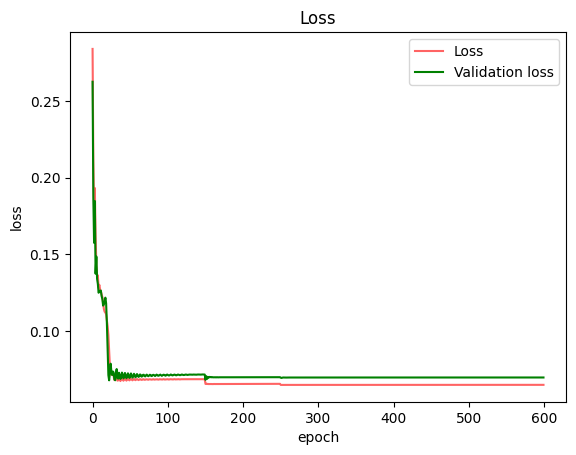

0.9053890427172177
lr: 0.15 0.15
50
step 100, accuracy_train:0.875, loss: 0.07231293905477852
0.23616901800741918
lr: 0.15 0.15
100
0.0005636716688742187
accuracy of best loss : 0.875
lr: 0.05 0.05
150
step 200, accuracy_train:0.86875, loss: 0.06929162380188554
0.0420738991982538
lr: 0.05 0.05
200
0.0008751512110740661
accuracy of best loss : 0.86875
lr: 0.01 0.01
250
step 300, accuracy_train:0.86875, loss: 0.06858698708251346
0.010709530176861676
lr: 0.01 0.01
300
0.00011551260236666198
lr: 0.01 0.01
350
step 400, accuracy_train:0.86875, loss: 0.06860204937198973
0.00010911303285153338
lr: 0.01 0.01
400
8.963015697645382e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.86875, loss: 0.06861215957907049
7.329496606654368e-05
lr: 0.01 0.01
500
5.981882692587883e-05
lr: 0.01 0.01
550
step 600, accuracy_train:0.86875, loss: 0.06861889236078976
4.879538067123707e-05
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.86875 -200
Epoch:  0 | Cost: 0.057073 | Train accuracy: 0.868750 | Te

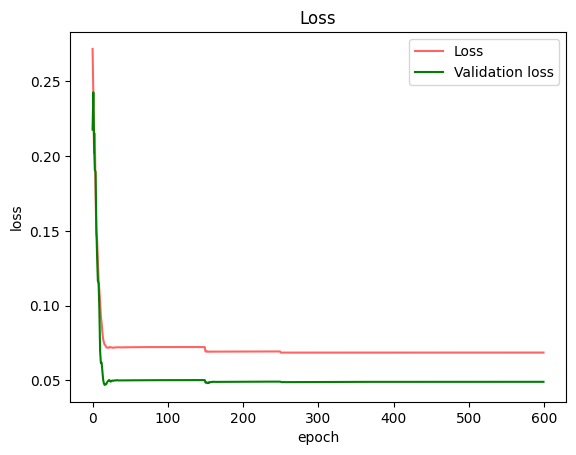

0.9132105392786181
lr: 0.15 0.15
50
step 100, accuracy_train:0.0125, loss: 0.0577312273449283
0.285870729517228
lr: 0.15 0.15
100
0.07275833974594424
lr: 0.15 0.15
150
step 200, accuracy_train:0.00625, loss: 0.05127013288962015
0.15127121245452207
lr: 0.15 0.15
200
0.03539781245795601
accuracy of best loss : 0.0
lr: 0.05 0.05
250
step 300, accuracy_train:0.0, loss: 0.0464719486037679
0.18133324122608072
lr: 0.05 0.05
300
0.032622515632051395
lr: 0.05 0.05
350
step 400, accuracy_train:0.0, loss: 0.04641005463424574
0.0015694712397220606
accuracy of best loss : 0.0
lr: 0.01 0.01
400
0.020672559546691942
lr: 0.01 0.01
450
step 500, accuracy_train:0.0, loss: 0.045396449415033076
4.465606183127838e-05
lr: 0.01 0.01
500
0.0003260795533157336
lr: 0.01 0.01
550
step 600, accuracy_train:0.0, loss: 0.04542647737187642
0.0003312544258849246
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.0 -50
Epoch:  0 | Cost: 0.041368 | Train accuracy: 0.000000 | Test Accuracy: 0.000000
(n_dim, n_q, n_

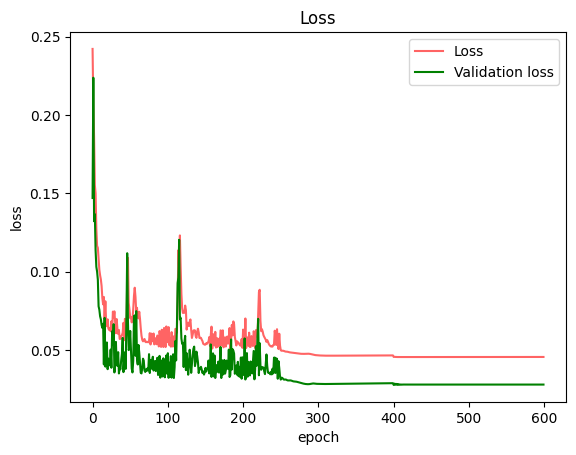

0.8969272732213391
lr: 0.15 0.15
50
step 100, accuracy_train:0.85625, loss: 0.07037379862010396
0.3366821918079619
lr: 0.15 0.15
100
0.0036221700735745103
accuracy of best loss : 0.8875
lr: 0.05 0.05
150
step 200, accuracy_train:0.88125, loss: 0.06530817131390024
0.048185921899479144
lr: 0.05 0.05
200
0.0003356340704733616
accuracy of best loss : 0.88125
lr: 0.01 0.01
250
step 300, accuracy_train:0.88125, loss: 0.06502445555985957
0.004765709570038575
lr: 0.01 0.01
300
8.81325789515439e-05
lr: 0.01 0.01
350
step 400, accuracy_train:0.88125, loss: 0.06503568592885592
8.619614275201277e-05
lr: 0.01 0.01
400
7.792267991935646e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.88125, loss: 0.06504484011267948
7.026514727694237e-05
lr: 0.01 0.01
500
6.305344420578165e-05
lr: 0.01 0.01
550
step 600, accuracy_train:0.88125, loss: 0.06505216574962702
5.62137740555242e-05
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.88125 -1
Epoch:  0 | Cost: 0.052498 | Train accuracy: 0.881250 | Test

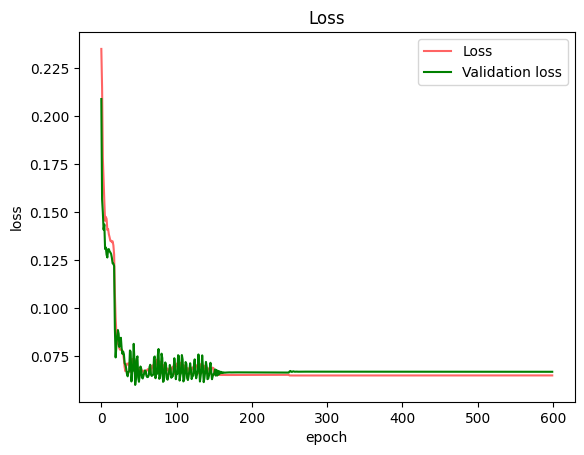

0.9289487145528459
lr: 0.15 0.15
50
step 100, accuracy_train:0.325, loss: 0.059183239907326865
0.16878299601468652
lr: 0.15 0.15
100
0.0016716527346081922
accuracy of best loss : 0.325
lr: 0.05 0.05
150
step 200, accuracy_train:0.33125, loss: 0.05680333940809383
0.039627755773286644
lr: 0.05 0.05
200
0.00034472559220976434
accuracy of best loss : 0.33125
lr: 0.01 0.01
250
step 300, accuracy_train:0.31875, loss: 0.05640477386033099
0.00753945520949865
lr: 0.01 0.01
300
6.648255505632557e-05
lr: 0.01 0.01
350
step 400, accuracy_train:0.31875, loss: 0.05641747343656881
0.00011226127526307597
lr: 0.01 0.01
400
9.732027242034039e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.31875, loss: 0.056426973554064036
8.394860392309966e-05
lr: 0.01 0.01
500
7.197449382973567e-05
lr: 0.01 0.01
550
step 600, accuracy_train:0.31875, loss: 0.05643391463691309
6.129994139698769e-05
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.31875 -200
Epoch:  0 | Cost: 0.059290 | Train accuracy: 0.318750 |

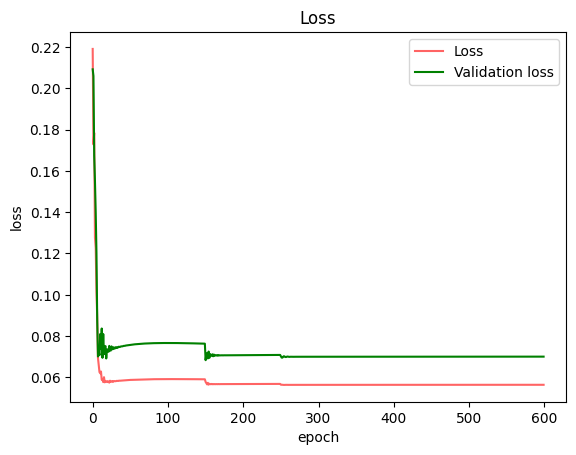

cv_time ：60.382078 s
((0.15, 0.05, 0.01), 600, 50, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.9379646965784526
lr: 0.15 0.15
50
step 100, accuracy_train:0.65, loss: 0.04991911456977525
0.1757147058238195
lr: 0.15 0.15
100
0.002756373266118489
accuracy of best loss : 0.675
lr: 0.05 0.05
150
step 200, accuracy_train:0.66875, loss: 0.04909095661793249
0.036722037415303076
lr: 0.05 0.05
200
0.0009306543081937567
accuracy of best loss : 0.66875
lr: 0.01 0.01
250
step 300, accuracy_train:0.6625, loss: 0.049013456175063294
0.0012338704715681701
lr: 0.01 0.01
300
5.073319401981776e-05
lr: 0.01 0.01
350
step 400, accuracy_train:0.6625, loss: 0.049010207164397156
3.3221338808620746e-05
lr: 0.01 0.01
400
2.4289070148118767e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.6625, loss: 0.049008607044245436
1.6140668817620286e-05
lr: 0.01 0.01


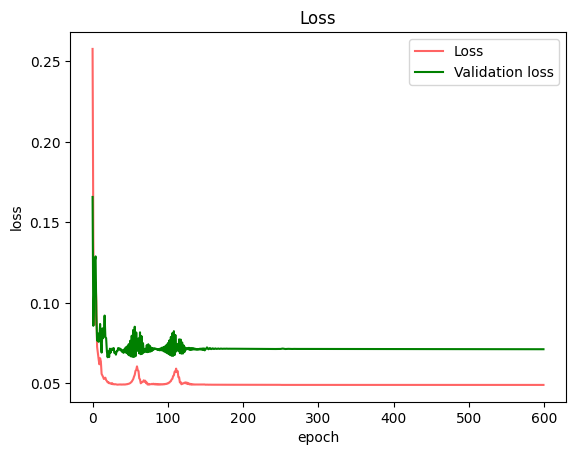

0.9317857863494069
lr: 0.15 0.15
50
step 100, accuracy_train:0.6125, loss: 0.05385105767667832
0.17306107289179892
lr: 0.15 0.15
100
0.029019360864434247
accuracy of best loss : 0.6125
lr: 0.05 0.05
150
step 200, accuracy_train:0.5875, loss: 0.05316009429223633
0.028133015645727105
accuracy of best loss : 0.5875
lr: 0.01 0.01
200
0.0026609244664247463
lr: 0.01 0.01
250
step 300, accuracy_train:0.58125, loss: 0.053069769908524744
0.00025816733893773016
lr: 0.01 0.01
300
0.0002181549996643571
lr: 0.01 0.01
350
step 400, accuracy_train:0.5625, loss: 0.053050852720476924
0.00017786283602994022
lr: 0.01 0.01
400
0.00013704864916908003
lr: 0.01 0.01
450
step 500, accuracy_train:0.5625, loss: 0.05304017253966059
9.981821771491445e-05
lr: 0.01 0.01
500
6.845907873432017e-05
lr: 0.01 0.01
550
step 600, accuracy_train:0.5625, loss: 0.05303545574972697
4.372065083301844e-05
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.5625 -150
Epoch:  0 | Cost: 0.053216 | Train accuracy: 0.562500 | T

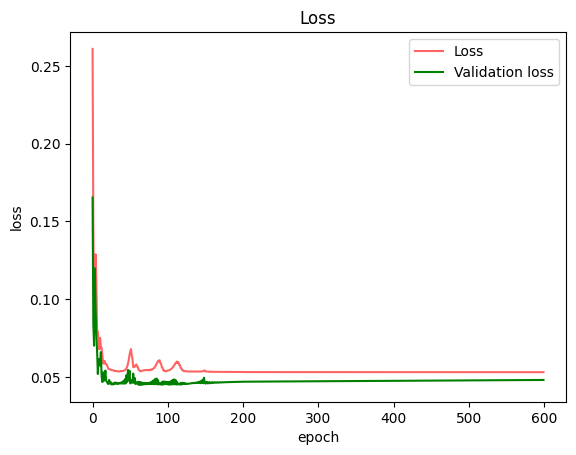

0.9290633040906741
lr: 0.15 0.15
50
step 100, accuracy_train:0.61875, loss: 0.055414593645096065
0.19105310872125983
lr: 0.15 0.15
100
0.007746413442228596
accuracy of best loss : 0.61875
lr: 0.05 0.05
150
step 200, accuracy_train:0.6125, loss: 0.055057586004094675
0.031235458767458018
lr: 0.05 0.05
200
0.0023789688772228672
accuracy of best loss : 0.6
lr: 0.01 0.01
250
step 300, accuracy_train:0.6, loss: 0.05492182423963875
0.0018841898807783262
lr: 0.01 0.01
300
0.00014110094709366856
lr: 0.01 0.01
350
step 400, accuracy_train:0.59375, loss: 0.054909263673014685
0.00011479233261471171
lr: 0.01 0.01
400
9.469056784263732e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.59375, loss: 0.054901085234583466
7.41700290661514e-05
lr: 0.01 0.01
500
5.4850191147674354e-05
lr: 0.01 0.01
550
step 600, accuracy_train:0.59375, loss: 0.054896892311636455
3.7791572568420544e-05
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.59375 -200
Epoch:  0 | Cost: 0.055583 | Train accuracy: 0.593750 |

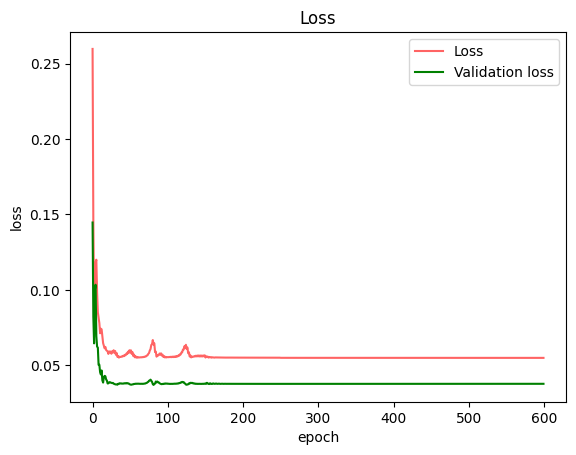

0.9297469870943565
lr: 0.15 0.15
50
step 100, accuracy_train:0.60625, loss: 0.05012197047852196
0.2823144414126342
lr: 0.15 0.15
100
0.001289433330400333
accuracy of best loss : 0.6
lr: 0.05 0.05
150
step 200, accuracy_train:0.5875, loss: 0.04933455322398996
0.01928369013050414
accuracy of best loss : 0.5875
lr: 0.01 0.01
200
0.0017481331680819436
lr: 0.01 0.01
250
step 300, accuracy_train:0.575, loss: 0.04929118030016244
8.913831566085195e-05
lr: 0.01 0.01
300
5.995451802226311e-05
lr: 0.01 0.01
350
step 400, accuracy_train:0.575, loss: 0.049287269223207815
3.9116391815336655e-05
lr: 0.01 0.01
400
2.2580463765265656e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.575, loss: 0.04928619432544369
1.0480681515226148e-05
lr: 0.01 0.01
500
2.2261807268775834e-06
lr: 0.01 0.01
550
step 600, accuracy_train:0.575, loss: 0.04928647223346075
3.038451845020821e-06
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.575 -347
Epoch:  0 | Cost: 0.049459 | Train accuracy: 0.575000 | Test Accura

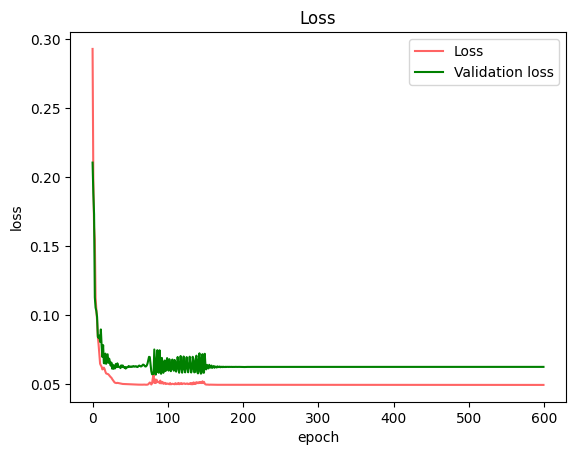

0.9228103736704613
lr: 0.15 0.15
50
step 100, accuracy_train:0.31875, loss: 0.05920245583586921
0.23382666609550976
lr: 0.15 0.15
100
0.0016306611004176688
accuracy of best loss : 0.31875
lr: 0.05 0.05
150
step 200, accuracy_train:0.31875, loss: 0.05833293581853556
0.015206884568861385
accuracy of best loss : 0.31875
lr: 0.01 0.01
200
0.003707670182656434
lr: 0.01 0.01
250
step 300, accuracy_train:0.31875, loss: 0.058122826689376586
2.7674329548111723e-05
lr: 0.01 0.01
300
4.112893322402259e-05
lr: 0.01 0.01
350
step 400, accuracy_train:0.31875, loss: 0.058126801844458634
3.3991328359471815e-05
lr: 0.01 0.01
400
2.8500639739104456e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.31875, loss: 0.05812962724088617
2.419403732995148e-05
lr: 0.01 0.01
500
2.0747144256235144e-05
lr: 0.01 0.01
550
step 600, accuracy_train:0.31875, loss: 0.05813172087907131
1.794214552713412e-05
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.31875 -350
Epoch:  0 | Cost: 0.059162 | Train accuracy: 0.3

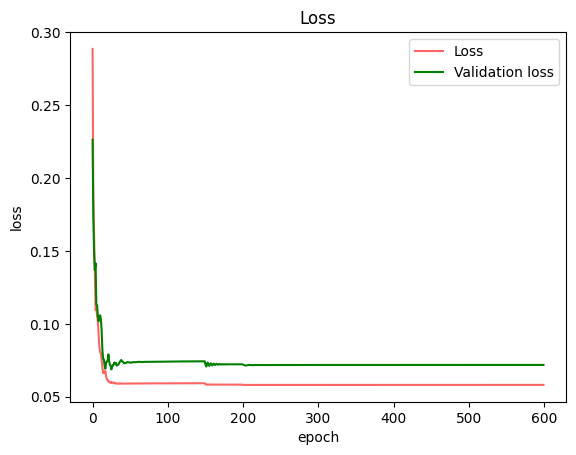

cv_time ：46.886051 s
((0.15, 0.05, 0.01), 600, 100, 50, (0.05, 0.03, 0.01))
0.9293736136511439
lr: 0.15 0.15
50
step 100, accuracy_train:0.6875, loss: 0.04830349313134619
0.3141436434488106
lr: 0.15 0.15
100
0.003173490020681159
accuracy of best loss : 0.68125
lr: 0.05 0.05
150
step 200, accuracy_train:0.68125, loss: 0.04827853649174392
0.00014718772425211286
accuracy of best loss : 0.68125
lr: 0.01 0.01
200
4.401927792899091e-06
lr: 0.01 0.01
250
step 300, accuracy_train:0.68125, loss: 0.0482784540108598
8.586222117916493e-07
lr: 0.01 0.01
300
7.414775845366183e-07
lr: 0.01 0.01
350
step 400, accuracy_train:0.68125, loss: 0.04827839387597127
6.211337784844869e-07
lr: 0.01 0.01
400
5.059602552681108e-07
lr: 0.01 0.01
450
step 500, accuracy_train:0.68125, loss: 0.04827835474972714
4.0296420892275173e-07
lr: 0.01 0.01
500
3.152394273031731e-07
lr: 0.01 0.01
550
step 600, accuracy_train:0.68125, loss: 0.048278331088204646
2.4319310373295336e-07
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of 

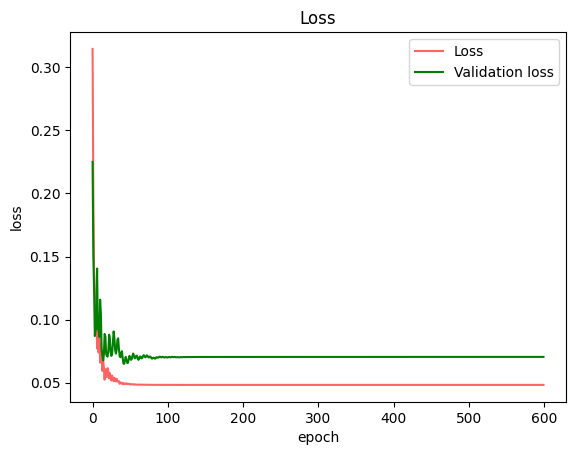

0.9239509337339069
lr: 0.15 0.15
50
step 100, accuracy_train:0.5375, loss: 0.05299161715016385
0.29981570281460346
lr: 0.15 0.15
100
0.03118603743518532
accuracy of best loss : 0.53125
lr: 0.05 0.05
150
step 200, accuracy_train:0.525, loss: 0.052909482549393407
0.03573022945127777
lr: 0.05 0.05
200
0.0018475595357357031
accuracy of best loss : 0.50625
lr: 0.01 0.01
250
step 300, accuracy_train:0.5, loss: 0.0526810055824573
0.0023163649830907464
lr: 0.01 0.01
300
0.0023907985345829746
lr: 0.01 0.01
350
step 400, accuracy_train:0.4375, loss: 0.05195097794103614
0.006218600440472019
lr: 0.01 0.01
400
0.022076253440489104
lr: 0.01 0.01
450
step 500, accuracy_train:0.08125, loss: 0.04530203819861656
0.06781847157267108
lr: 0.01 0.01
500
0.0840186533287225
lr: 0.01 0.01
550
step 600, accuracy_train:0.05625, loss: 0.04177372087847223
0.03542314198852466
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.05625 -1
Epoch:  0 | Cost: 0.041774 | Train accuracy: 0.056250 | Test Accuracy: 0.10

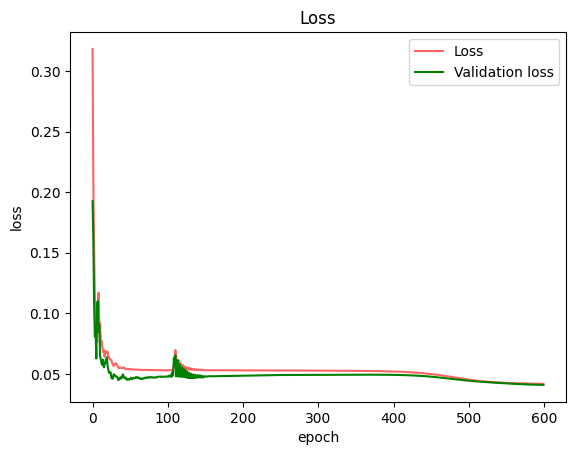

0.9218407101237738
lr: 0.15 0.15
50
step 100, accuracy_train:0.5875, loss: 0.05548800586500607
0.28832507512765315
lr: 0.15 0.15
100
0.0030045271482279584
accuracy of best loss : 0.58125
lr: 0.05 0.05
150
step 200, accuracy_train:0.58125, loss: 0.05543090930072528
0.0004136544137430793
accuracy of best loss : 0.58125
lr: 0.01 0.01
200
6.409855594044276e-05
lr: 0.01 0.01
250
step 300, accuracy_train:0.58125, loss: 0.055428826318573654
1.898761201122944e-05
lr: 0.01 0.01
300
1.8593181737234036e-05
lr: 0.01 0.01
350
step 400, accuracy_train:0.58125, loss: 0.05542686172285614
1.7740483812389033e-05
lr: 0.01 0.01
400
1.653935307128141e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.58125, loss: 0.055425186420981376
1.5108412520203552e-05
lr: 0.01 0.01
500
1.354862403115085e-05
lr: 0.01 0.01
550
step 600, accuracy_train:0.58125, loss: 0.055423860481490665
1.1943663060920437e-05
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.58125 -400
Epoch:  0 | Cost: 0.055431 | Train accuracy: 0

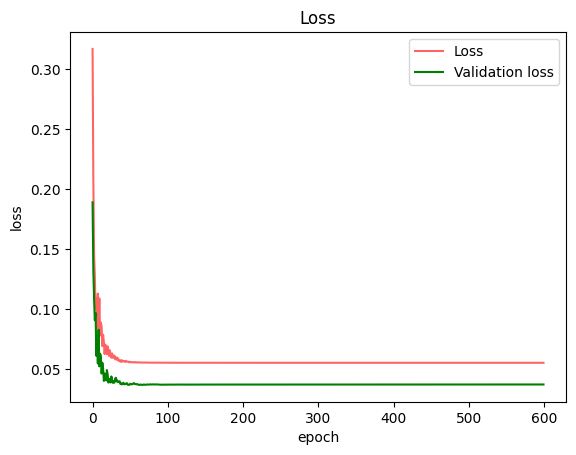

0.9239818743842263
lr: 0.15 0.15
50
step 100, accuracy_train:0.625, loss: 0.04944156242481587
0.34588642203275594
lr: 0.15 0.15
100
0.006484975821977688
accuracy of best loss : 0.59375
lr: 0.05 0.05
150
step 200, accuracy_train:0.59375, loss: 0.04938590058594175
0.0003031770982471037
accuracy of best loss : 0.59375
lr: 0.01 0.01
200
2.699147958641301e-05
lr: 0.01 0.01
250
step 300, accuracy_train:0.59375, loss: 0.049385170331800184
7.4641605555594295e-06
lr: 0.01 0.01
300
7.1599709454376535e-06
lr: 0.01 0.01
350
step 400, accuracy_train:0.59375, loss: 0.04938450983069015
6.6915772107183345e-06
lr: 0.01 0.01
400
6.106693794970825e-06
lr: 0.01 0.01
450
step 500, accuracy_train:0.59375, loss: 0.04938397040933176
5.45670669018842e-06
lr: 0.01 0.01
500
4.783064653188825e-06
lr: 0.01 0.01
550
step 600, accuracy_train:0.59375, loss: 0.049383562749909626
4.118152739598801e-06
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.59375 -397
Epoch:  0 | Cost: 0.049386 | Train accuracy: 0.5937

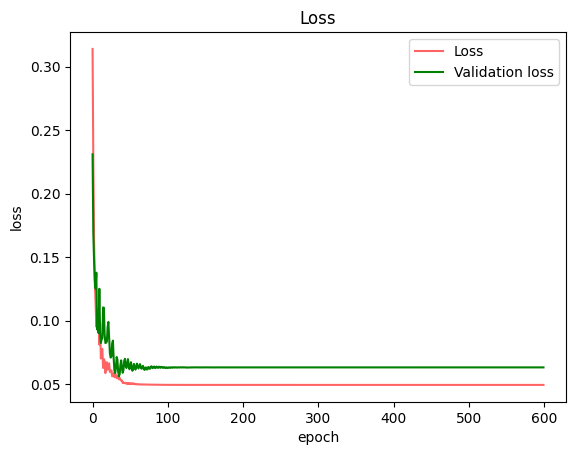

0.9274073854238849
lr: 0.15 0.15
50
step 100, accuracy_train:0.7, loss: 0.04968827301887677
0.31240043429074055
lr: 0.15 0.15
100
0.0055252154621666764
accuracy of best loss : 0.7
lr: 0.05 0.05
150
step 200, accuracy_train:0.70625, loss: 0.049598222737039
0.0007247158694521227
accuracy of best loss : 0.70625
lr: 0.01 0.01
200
0.00011051257612168075
lr: 0.01 0.01
250
step 300, accuracy_train:0.70625, loss: 0.04959491313365443
3.3716882225713646e-05
lr: 0.01 0.01
300
3.3542178566290537e-05
lr: 0.01 0.01
350
step 400, accuracy_train:0.70625, loss: 0.04959168126312294
3.261950185272309e-05
lr: 0.01 0.01
400
3.111099309233778e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.70625, loss: 0.04958878642318293
2.918880562098275e-05
lr: 0.01 0.01
500
2.6996633711961216e-05
lr: 0.01 0.01
550
step 600, accuracy_train:0.70625, loss: 0.04958633953131358
2.465284236606255e-05
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.70625 -350
Epoch:  0 | Cost: 0.049597 | Train accuracy: 0.706250 | Te

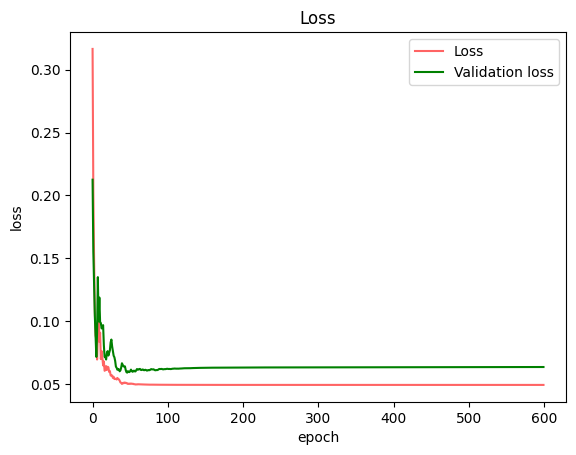

cv_time ：24.338363 s
((0.15, 0.05, 0.01), 600, 300, 50, (0.05, 0.03, 0.01))
0.8993149045619927
lr: 0.15 0.15
50
step 100, accuracy_train:0.88125, loss: 0.0683635002345736
0.3222536973358034
lr: 0.15 0.15
100
0.002086300277636399
accuracy of best loss : 0.88125
lr: 0.05 0.05
150
step 200, accuracy_train:0.89375, loss: 0.06532495526077886
0.04512800834734709
lr: 0.05 0.05
200
0.0009933695924416851
accuracy of best loss : 0.89375
lr: 0.01 0.01
250
step 300, accuracy_train:0.8875, loss: 0.06470288660203252
0.010123904522471062
lr: 0.01 0.01
300
0.00013525578873486814
accuracy of best loss : 0.8875
0.01
lr: 0.001 0.001
350
step 400, accuracy_train:0.8875, loss: 0.06456904434755989
0.0021410149646879993
accuracy of best loss : 0.8875
0.01
lr: 0.0001 0.0001
400
0.00021361063589463953
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.8875, loss: 0.0645549708219719
2.482988720970701e-07
lr: 0.0001 0.0001
500
5.33585558696677e-08
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.8875, loss: 0.0645

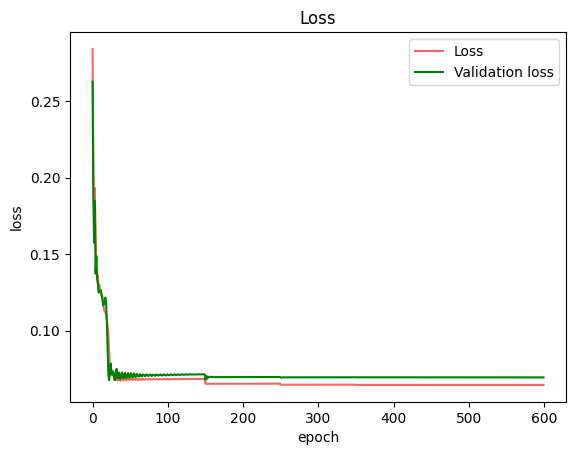

0.9053890427172177
lr: 0.15 0.15
50
step 100, accuracy_train:0.875, loss: 0.07231293905477852
0.23616901800741918
lr: 0.15 0.15
100
0.0005636716688742187
accuracy of best loss : 0.875
lr: 0.05 0.05
150
step 200, accuracy_train:0.86875, loss: 0.06929162380188554
0.0420738991982538
lr: 0.05 0.05
200
0.0008751512110740661
accuracy of best loss : 0.86875
lr: 0.01 0.01
250
step 300, accuracy_train:0.86875, loss: 0.06858698708251346
0.010709530176861676
lr: 0.01 0.01
300
0.00011551260236666198
accuracy of best loss : 0.86875
0.01
lr: 0.001 0.001
350
step 400, accuracy_train:0.8625, loss: 0.06843940135557006
0.002216563279895062
accuracy of best loss : 0.8625
0.01
lr: 0.0001 0.0001
400
0.00021828699891171692
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.8625, loss: 0.0684242574623561
1.404251727747452e-06
lr: 0.0001 0.0001
500
4.594920711613101e-07
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.8625, loss: 0.068424218147784
2.778254464735095e-07
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001
ac

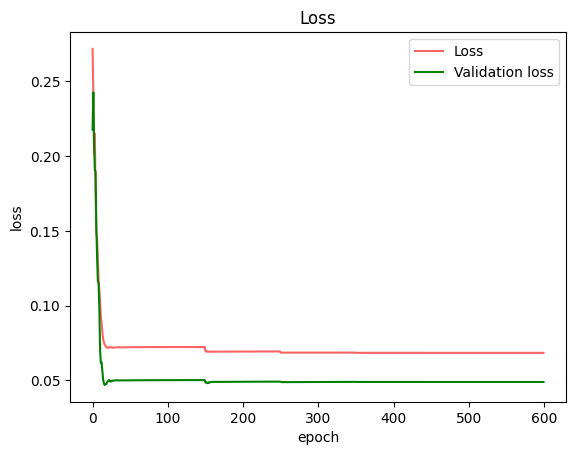

0.9132105392786181
lr: 0.15 0.15
50
step 100, accuracy_train:0.0125, loss: 0.0577312273449283
0.285870729517228
lr: 0.15 0.15
100
0.07275833974594424
lr: 0.15 0.15
150
step 200, accuracy_train:0.00625, loss: 0.05127013288962015
0.15127121245452207
lr: 0.15 0.15
200
0.03539781245795601
accuracy of best loss : 0.0
lr: 0.05 0.05
250
step 300, accuracy_train:0.0, loss: 0.0464719486037679
0.18133324122608072
lr: 0.05 0.05
300
0.032622515632051395
lr: 0.05 0.05
350
step 400, accuracy_train:0.0, loss: 0.04641005463424574
0.0015694712397220606
accuracy of best loss : 0.0
lr: 0.01 0.01
400
0.020672559546691942
lr: 0.01 0.01
450
step 500, accuracy_train:0.0, loss: 0.045396449415033076
4.465606183127838e-05
accuracy of best loss : 0.0
0.01
lr: 0.001 0.001
500
0.0033069396918019925
accuracy of best loss : 0.0
0.01
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.0, loss: 0.045224287755281534
0.00033033161164239077
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001
accuracy of best loss: 0.0 -41
Epoch:  0 | C

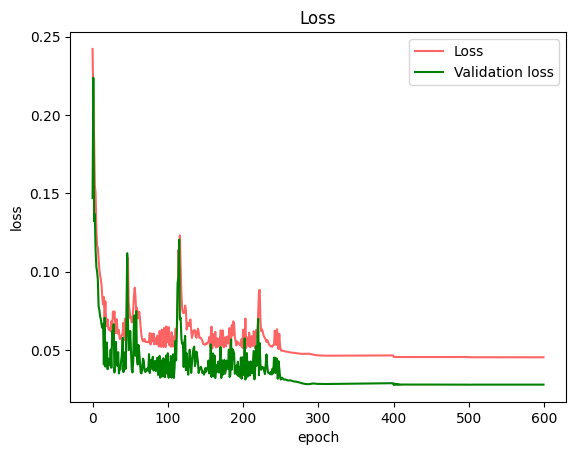

0.8969272732213391
lr: 0.15 0.15
50
step 100, accuracy_train:0.85625, loss: 0.07037379862010396
0.3366821918079619
lr: 0.15 0.15
100
0.0036221700735745103
accuracy of best loss : 0.8875
lr: 0.05 0.05
150
step 200, accuracy_train:0.88125, loss: 0.06530817131390024
0.048185921899479144
lr: 0.05 0.05
200
0.0003356340704733616
accuracy of best loss : 0.88125
lr: 0.01 0.01
250
step 300, accuracy_train:0.88125, loss: 0.06502445555985957
0.004765709570038575
accuracy of best loss : 0.8875
0.01
lr: 0.001 0.001
300
0.000993644999414305
accuracy of best loss : 0.8875
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.8875, loss: 0.06495057541547883
0.00010160853285668812
lr: 0.0001 0.0001
400
1.1653060945519979e-07
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.8875, loss: 0.06495059604373583
1.6014637246741632e-07
lr: 0.0001 0.0001
500
1.7541146927536913e-07
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.8875, loss: 0.06495061950330866
1.8124165359295256e-07
lr: 0.0001 0.0001
600
lr: 0.0

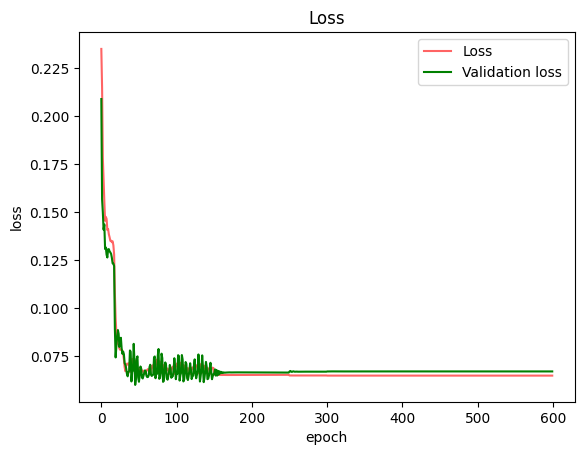

0.9289487145528459
lr: 0.15 0.15
50
step 100, accuracy_train:0.325, loss: 0.059183239907326865
0.16878299601468652
lr: 0.15 0.15
100
0.0016716527346081922
accuracy of best loss : 0.325
lr: 0.05 0.05
150
step 200, accuracy_train:0.33125, loss: 0.05680333940809383
0.039627755773286644
lr: 0.05 0.05
200
0.00034472559220976434
accuracy of best loss : 0.33125
lr: 0.01 0.01
250
step 300, accuracy_train:0.31875, loss: 0.05640477386033099
0.00753945520949865
accuracy of best loss : 0.31875
0.01
lr: 0.001 0.001
300
0.0014995608357832033
accuracy of best loss : 0.31875
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.31875, loss: 0.05631129141485523
0.00015405299723612856
lr: 0.0001 0.0001
400
4.5174300062428575e-07
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.31875, loss: 0.056311286845672485
1.6586589260866298e-08
lr: 0.0001 0.0001
500
1.588167030961516e-07
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.31875, loss: 0.056311312644942546
2.3335059398231402e-07
lr: 0.0001 0.0001
600
l

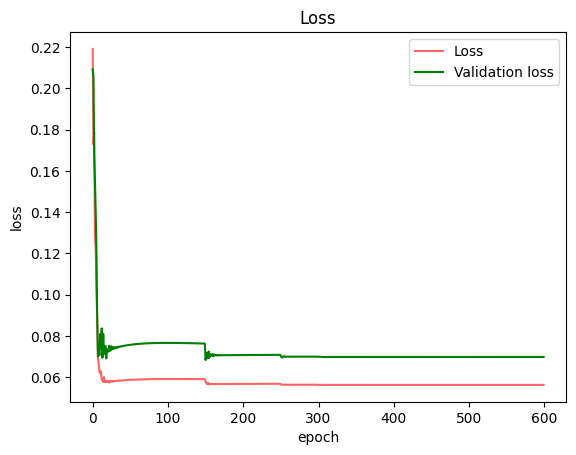

cv_time ：54.049741 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 50, 50, (0.05, 0.03, 0.01))
0.9379646965784526
lr: 0.15 0.15
50
step 100, accuracy_train:0.65, loss: 0.04991911456977525
0.1757147058238195
lr: 0.15 0.15
100
0.002756373266118489
accuracy of best loss : 0.675
lr: 0.05 0.05
150
step 200, accuracy_train:0.66875, loss: 0.04909095661793249
0.036722037415303076
lr: 0.05 0.05
200
0.0009306543081937567
accuracy of best loss : 0.66875
lr: 0.01 0.01
250
step 300, accuracy_train:0.6625, loss: 0.049013456175063294
0.0012338704715681701
accuracy of best loss : 0.6625
0.01
lr: 0.001 0.001
300
0.0002560652211933005
accuracy of best loss : 0.6625
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.6625, loss: 0.04900107266240453
2.730961050345985e-05
lr: 0.0001 0.0001
400
6.051061376835248e-07
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.6625, loss: 0.049001008547844935
6.536440818347661e-07
lr: 0.0001 0.0001
500
7.215057651895154e-07
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.

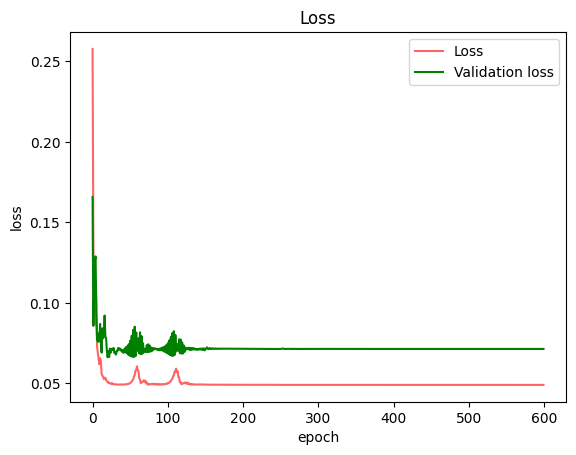

0.9317857863494069
lr: 0.15 0.15
50
step 100, accuracy_train:0.6125, loss: 0.05385105767667832
0.17306107289179892
lr: 0.15 0.15
100
0.029019360864434247
accuracy of best loss : 0.6125
lr: 0.05 0.05
150
step 200, accuracy_train:0.5875, loss: 0.05316009429223633
0.028133015645727105
accuracy of best loss : 0.5875
lr: 0.01 0.01
200
0.0026609244664247463
accuracy of best loss : 0.58125
0.01
lr: 0.001 0.001
250
step 300, accuracy_train:0.58125, loss: 0.053065606934279363
0.00043541907885271633
accuracy of best loss : 0.58125
0.01
lr: 0.0001 0.0001
300
4.7289155436381425e-05
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.58125, loss: 0.053063600204617506
3.2624051261465647e-06
lr: 0.0001 0.0001
400
3.586231380081513e-06
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.58125, loss: 0.05306318496889818
3.916161637677771e-06
lr: 0.0001 0.0001
500
4.243799237021646e-06
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.58125, loss: 0.053062700349875466
4.5697468161112265e-06
lr: 0.0001 0.0001
6

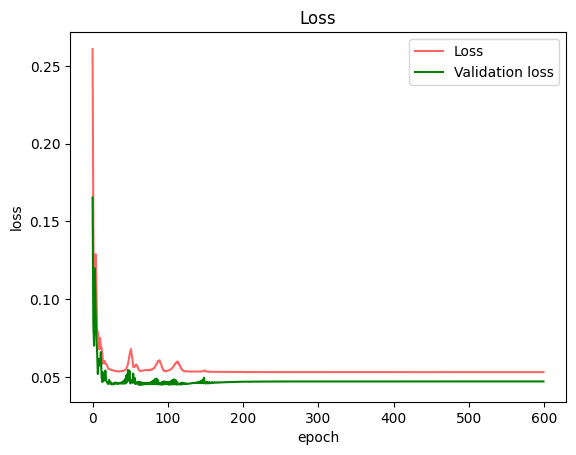

0.9290633040906741
lr: 0.15 0.15
50
step 100, accuracy_train:0.61875, loss: 0.055414593645096065
0.19105310872125983
lr: 0.15 0.15
100
0.007746413442228596
accuracy of best loss : 0.61875
lr: 0.05 0.05
150
step 200, accuracy_train:0.6125, loss: 0.055057586004094675
0.031235458767458018
lr: 0.05 0.05
200
0.0023789688772228672
accuracy of best loss : 0.6
lr: 0.01 0.01
250
step 300, accuracy_train:0.6, loss: 0.05492182423963875
0.0018841898807783262
accuracy of best loss : 0.6
0.01
lr: 0.001 0.001
300
0.0003976298510563341
accuracy of best loss : 0.6
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.6, loss: 0.054901832126013406
4.2528410684963627e-05
lr: 0.0001 0.0001
400
1.801389178445734e-06
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.6, loss: 0.05490162152891721
1.91680506215819e-06
lr: 0.0001 0.0001
500
2.0720673794670247e-06
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.6, loss: 0.05490137721313848
2.2268970438454386e-06
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001
accuracy o

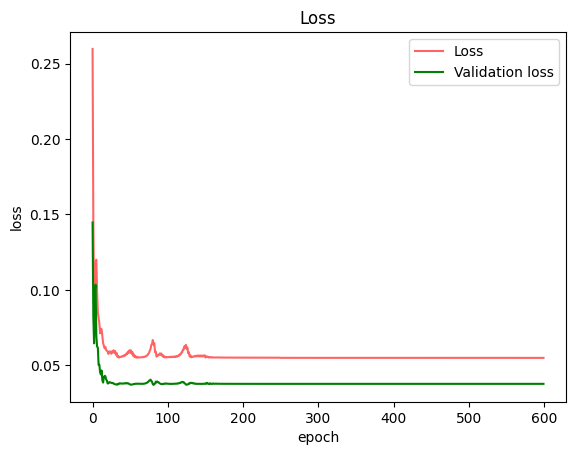

0.9297469870943565
lr: 0.15 0.15
50
step 100, accuracy_train:0.60625, loss: 0.05012197047852196
0.2823144414126342
lr: 0.15 0.15
100
0.001289433330400333
accuracy of best loss : 0.6
lr: 0.05 0.05
150
step 200, accuracy_train:0.5875, loss: 0.04933455322398996
0.01928369013050414
accuracy of best loss : 0.5875
lr: 0.01 0.01
200
0.0017481331680819436
accuracy of best loss : 0.575
0.01
lr: 0.001 0.001
250
step 300, accuracy_train:0.575, loss: 0.049285888613264835
0.0002243522878789801
accuracy of best loss : 0.575
0.01
lr: 0.0001 0.0001
300
2.431081708392533e-05
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.575, loss: 0.049284871394435464
1.0616811454205167e-06
lr: 0.0001 0.0001
400
1.1793911279569698e-06
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.575, loss: 0.04928474416659098
1.292000807175998e-06
lr: 0.0001 0.0001
500
1.4028717340701857e-06
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.575, loss: 0.04928459520189825
1.5124397713957269e-06
lr: 0.0001 0.0001
600
lr: 0.0001 0.0

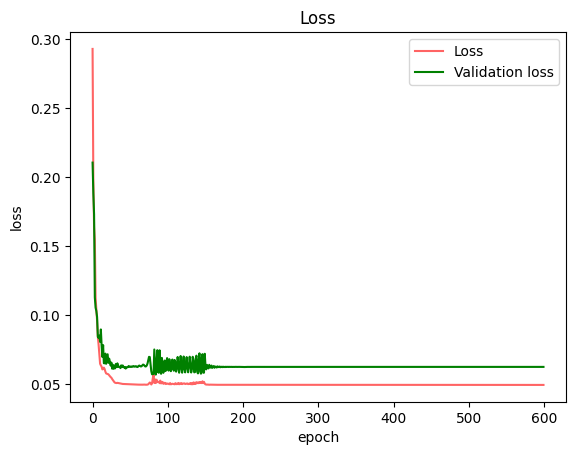

0.9228103736704613
lr: 0.15 0.15
50
step 100, accuracy_train:0.31875, loss: 0.05920245583586921
0.23382666609550976
lr: 0.15 0.15
100
0.0016306611004176688
accuracy of best loss : 0.31875
lr: 0.05 0.05
150
step 200, accuracy_train:0.31875, loss: 0.05833293581853556
0.015206884568861385
accuracy of best loss : 0.31875
lr: 0.01 0.01
200
0.003707670182656434
accuracy of best loss : 0.31875
0.01
lr: 0.001 0.001
250
step 300, accuracy_train:0.31875, loss: 0.05807796092023977
0.0007167849290453177
accuracy of best loss : 0.31875
0.01
lr: 0.0001 0.0001
300
8.189100158625648e-05
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.31875, loss: 0.05807351620910352
4.653408013545779e-07
lr: 0.0001 0.0001
400
3.2748443556413475e-07
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.31875, loss: 0.058073481598829614
2.965769368831558e-07
lr: 0.0001 0.0001
500
2.887550538673277e-07
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.31875, loss: 0.05807344898574798
2.8092741142160096e-07
lr: 0.0001 0.0001
6

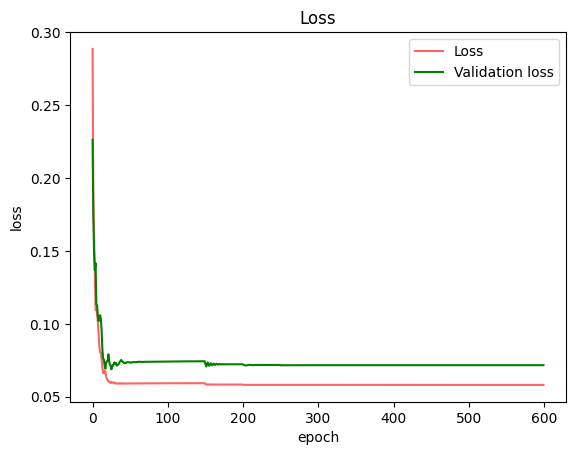

cv_time ：44.786857 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 100, 50, (0.05, 0.03, 0.01))
0.9293736136511439
lr: 0.15 0.15
50
step 100, accuracy_train:0.6875, loss: 0.04830349313134619
0.3141436434488106
lr: 0.15 0.15
100
0.003173490020681159
accuracy of best loss : 0.68125
lr: 0.05 0.05
150
step 200, accuracy_train:0.68125, loss: 0.04827853649174392
0.00014718772425211286
accuracy of best loss : 0.68125
lr: 0.01 0.01
200
4.401927792899091e-06
accuracy of best loss : 0.68125
0.01
lr: 0.001 0.001
250
step 300, accuracy_train:0.68125, loss: 0.048278488555278824
4.827771182174799e-07
accuracy of best loss : 0.68125
0.01
lr: 0.0001 0.0001
300
4.821361185222838e-08
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.68125, loss: 0.04827848760628005
9.92947987975459e-09
lr: 0.0001 0.0001
400
1.0725724452347777e-08
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.68125, loss: 0.048278486497371015
1.1493971575475211e-08
lr: 0.0001 0.0001
500
1.2239257998271958e-08
lr: 0.0001 0.0001
550
step 600,

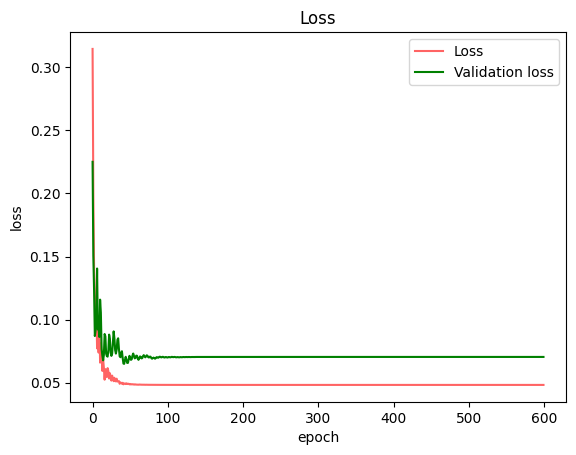

0.9239509337339069
lr: 0.15 0.15
50
step 100, accuracy_train:0.5375, loss: 0.05299161715016385
0.29981570281460346
lr: 0.15 0.15
100
0.03118603743518532
accuracy of best loss : 0.53125
lr: 0.05 0.05
150
step 200, accuracy_train:0.525, loss: 0.052909482549393407
0.03573022945127777
lr: 0.05 0.05
200
0.0018475595357357031
accuracy of best loss : 0.50625
lr: 0.01 0.01
250
step 300, accuracy_train:0.5, loss: 0.0526810055824573
0.0023163649830907464
accuracy of best loss : 0.5
0.01
lr: 0.001 0.001
300
0.0009882409001585653
accuracy of best loss : 0.5
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.5, loss: 0.05266651001687646
0.0001412743356688161
lr: 0.0001 0.0001
400
3.0246511645748746e-05
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.5, loss: 0.052663057189485066
3.28044756703064e-05
lr: 0.0001 0.0001
500
3.537751343843238e-05
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.5, loss: 0.05265905824979207
3.798974317187083e-05
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001
accuracy of be

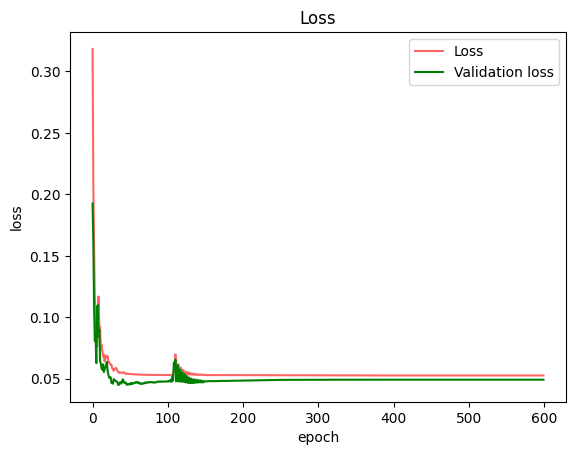

0.9218407101237738
lr: 0.15 0.15
50
step 100, accuracy_train:0.5875, loss: 0.05548800586500607
0.28832507512765315
lr: 0.15 0.15
100
0.0030045271482279584
accuracy of best loss : 0.58125
lr: 0.05 0.05
150
step 200, accuracy_train:0.58125, loss: 0.05543090930072528
0.0004136544137430793
accuracy of best loss : 0.58125
lr: 0.01 0.01
200
6.409855594044276e-05
accuracy of best loss : 0.58125
0.01
lr: 0.001 0.001
250
step 300, accuracy_train:0.58125, loss: 0.055429764935227645
1.0287374901628816e-05
accuracy of best loss : 0.58125
0.01
lr: 0.0001 0.0001
300
1.0880722485149237e-06
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.58125, loss: 0.05542974018420824
2.255673979330896e-07
lr: 0.0001 0.0001
400
2.4401639898789473e-07
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.58125, loss: 0.055429711173454556
2.6190226523971863e-07
lr: 0.0001 0.0001
500
2.793505064762026e-07
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.58125, loss: 0.05542967832913819
2.964613001435864e-07
lr: 0.0001 0.00

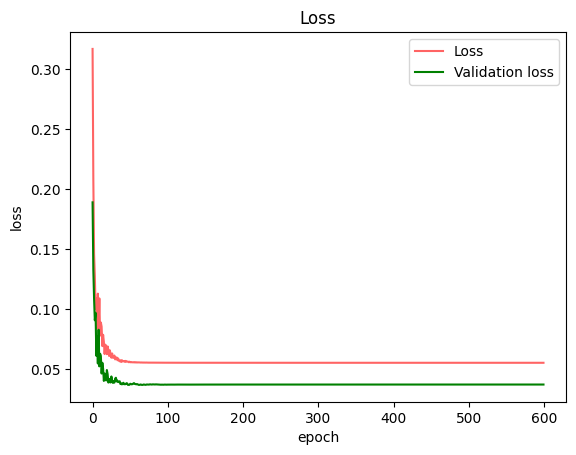

0.9239818743842263
lr: 0.15 0.15
50
step 100, accuracy_train:0.625, loss: 0.04944156242481587
0.34588642203275594
lr: 0.15 0.15
100
0.006484975821977688
accuracy of best loss : 0.59375
lr: 0.05 0.05
150
step 200, accuracy_train:0.59375, loss: 0.04938590058594175
0.0003031770982471037
accuracy of best loss : 0.59375
lr: 0.01 0.01
200
2.699147958641301e-05
accuracy of best loss : 0.59375
0.01
lr: 0.001 0.001
250
step 300, accuracy_train:0.59375, loss: 0.04938549541592693
4.069809736685523e-06
accuracy of best loss : 0.59375
0.01
lr: 0.0001 0.0001
300
4.26305252708317e-07
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.59375, loss: 0.04938548678545893
8.827937042717171e-08
lr: 0.0001 0.0001
400
9.547641721086703e-08
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.59375, loss: 0.04938547667476989
1.0244842099089367e-07
lr: 0.0001 0.0001
500
1.0924371686422225e-07
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.59375, loss: 0.04938546523449268
1.1590128007419328e-07
lr: 0.0001 0.0001
600

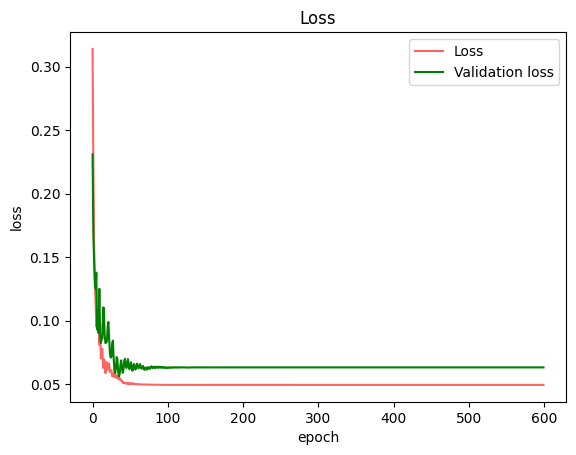

0.9274073854238849
lr: 0.15 0.15
50
step 100, accuracy_train:0.7, loss: 0.04968827301887677
0.31240043429074055
lr: 0.15 0.15
100
0.0055252154621666764
accuracy of best loss : 0.7
lr: 0.05 0.05
150
step 200, accuracy_train:0.70625, loss: 0.049598222737039
0.0007247158694521227
accuracy of best loss : 0.70625
lr: 0.01 0.01
200
0.00011051257612168075
accuracy of best loss : 0.70625
0.01
lr: 0.001 0.001
250
step 300, accuracy_train:0.70625, loss: 0.049596416377096636
1.8188029335095377e-05
accuracy of best loss : 0.70625
0.01
lr: 0.0001 0.0001
300
1.9358013539892107e-06
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.70625, loss: 0.049596376945421405
4.0162678424685257e-07
lr: 0.0001 0.0001
400
4.345519559298786e-07
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.70625, loss: 0.04959633071051173
4.6649026331630443e-07
lr: 0.0001 0.0001
500
4.97667699040709e-07
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.70625, loss: 0.04959627834441954
5.282635138968878e-07
lr: 0.0001 0.0001
600
lr

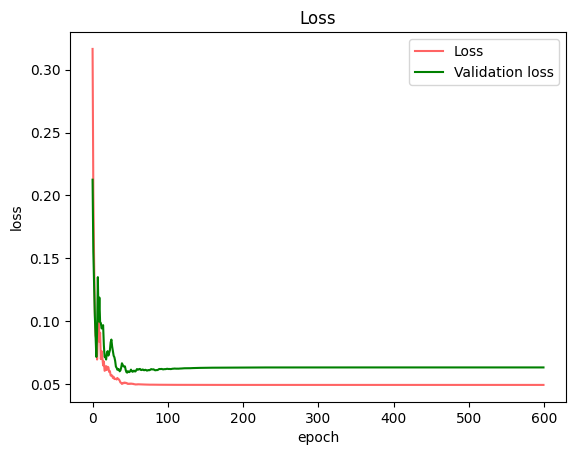

cv_time ：24.126869 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 300, 50, (0.05, 0.03, 0.01))


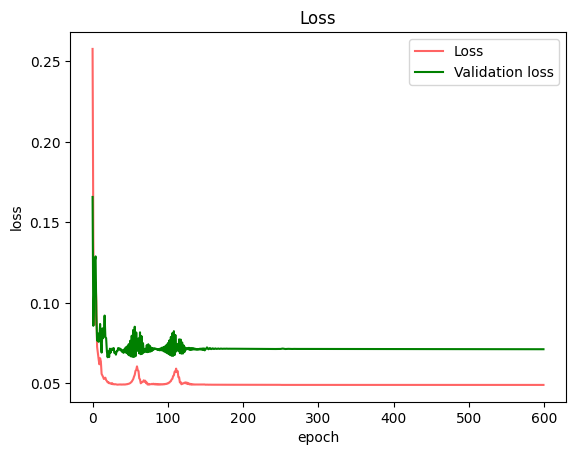

enc_circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
enc_circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
enc_circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.797405917457453
lr: 0.15 0.15
50
step 100, accuracy_train:0.0875, loss: 0.17926814101672595
0.039424805439852786
accuracy of best loss : 0.2125
lr: 0.05 0.05
100
0.10037377271782637
lr: 0.05 0.05
150
step 200, accuracy_train:0.18125, loss: 0.1962703766229989
0.054442607529044
lr: 0.05 0.05
200
0.023472264181327404
accuracy of best loss : 0.33125
lr: 0.01 0.01
250
step 300, accuracy_train:0.34375, loss: 0.12849545152362196
0.23275283092925378
lr: 0.01 0.01
300
0.012487657167198343
lr: 0.01 0.01
350
step 400, accuracy_train:0.34375, loss: 0.12812172276289072
0.00139938967246002
lr: 0.01 0.01
400
0.0009637616734915009
lr: 0.01 0.01
450
step 500, accuracy_train:0.

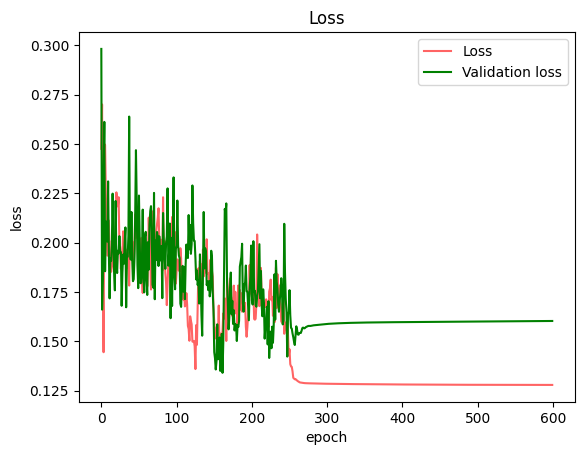

0.7898959705338005
lr: 0.15 0.15
50
step 100, accuracy_train:0.1875, loss: 0.18953903007476253
0.04735700861883529
accuracy of best loss : 0.23125
lr: 0.05 0.05
100
0.2841225252029595
lr: 0.05 0.05
150
step 200, accuracy_train:0.1375, loss: 0.1382314019856119
0.04674770513025986
lr: 0.05 0.05
200
0.021591589784192223
accuracy of best loss : 0.1625
lr: 0.01 0.01
250
step 300, accuracy_train:0.175, loss: 0.12199314691637886
0.12166925259645671
lr: 0.01 0.01
300
0.00603432969696834
lr: 0.01 0.01
350
step 400, accuracy_train:0.18125, loss: 0.1214945037451459
0.0019751046160560396
lr: 0.01 0.01
400
0.0011793402404890118
lr: 0.01 0.01
450
step 500, accuracy_train:0.18125, loss: 0.12133910381340487
0.0006124931990079699
lr: 0.01 0.01
500
0.0003039151919142037
lr: 0.01 0.01
550
step 600, accuracy_train:0.18125, loss: 0.12130137126622656
0.00014870813412895816
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.18125 -50
Epoch:  0 | Cost: 0.131316 | Train accuracy: 0.181250 | Test Accuracy

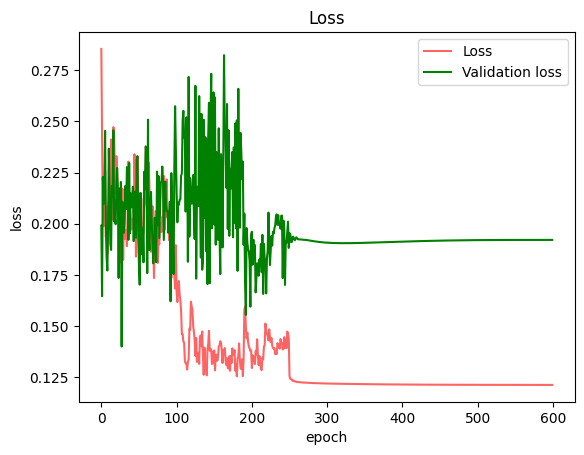

0.908502405685815
lr: 0.15 0.15
50
step 100, accuracy_train:0.76875, loss: 0.07633425621778059
0.16820487469216863
lr: 0.15 0.15
100
0.007445611574911606
accuracy of best loss : 0.7625
lr: 0.05 0.05
150
step 200, accuracy_train:0.78125, loss: 0.0734093669321004
0.027868406703591128
accuracy of best loss : 0.78125
lr: 0.01 0.01
200
0.006846507807162647
lr: 0.01 0.01
250
step 300, accuracy_train:0.78125, loss: 0.07293463358948044
1.0275420291798618e-05
lr: 0.01 0.01
300
3.241305667472662e-05
lr: 0.01 0.01
350
step 400, accuracy_train:0.78125, loss: 0.07293815593927769
2.4013445204432245e-05
lr: 0.01 0.01
400
1.6274512934648725e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.78125, loss: 0.07293936449143269
8.295671688523716e-06
lr: 0.01 0.01
500
8.627500998101404e-07
lr: 0.01 0.01
550
step 600, accuracy_train:0.78125, loss: 0.07293751313925513
1.2468414606477407e-05
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.78125 -1
Epoch:  0 | Cost: 0.075302 | Train accuracy: 0.781250 | 

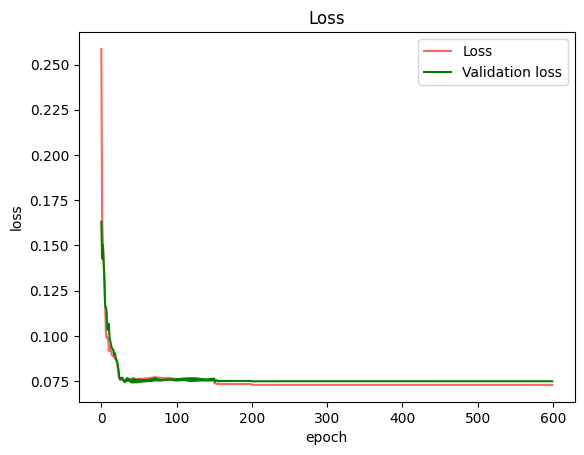

0.9202163391061665
lr: 0.15 0.15
50
step 100, accuracy_train:0.81875, loss: 0.06255563815162099
0.17403766462925374
lr: 0.15 0.15
100
0.05218788597013338
lr: 0.15 0.15
150
step 200, accuracy_train:0.825, loss: 0.06225672629197676
0.0024722339060329994
accuracy of best loss : 0.81875
lr: 0.05 0.05
200
0.03589550305740855
lr: 0.05 0.05
250
step 300, accuracy_train:0.825, loss: 0.06033964864514983
0.0003105807269116029
accuracy of best loss : 0.825
lr: 0.01 0.01
300
0.01107012158643581
lr: 0.01 0.01
350
step 400, accuracy_train:0.825, loss: 0.059656204902466786
0.0002337012386521541
lr: 0.01 0.01
400
0.0003880679159036164
lr: 0.01 0.01
450
step 500, accuracy_train:0.81875, loss: 0.059566661402746565
0.0007233670796574369
lr: 0.01 0.01
500
0.001508936638956389
lr: 0.01 0.01
550
step 600, accuracy_train:0.8125, loss: 0.059019267942092744
0.004038517477070669
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.8125 -1
Epoch:  0 | Cost: 0.061097 | Train accuracy: 0.812500 | Test Accuracy

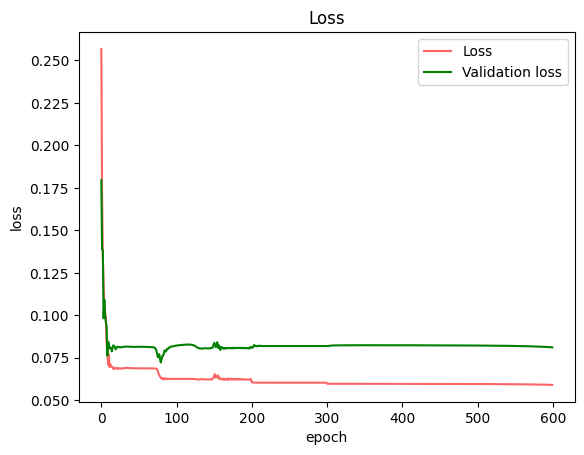

0.9240052089689921
lr: 0.15 0.15
50
step 100, accuracy_train:0.8, loss: 0.06509799666000511
0.13916221342250612
lr: 0.15 0.15
100
0.0003783992317972585
accuracy of best loss : 0.8
lr: 0.05 0.05
150
step 200, accuracy_train:0.8125, loss: 0.06237288101718863
0.04676169832317914
lr: 0.05 0.05
200
0.00016166500767023296
accuracy of best loss : 0.8125
lr: 0.01 0.01
250
step 300, accuracy_train:0.8125, loss: 0.06204683026633951
0.005588418363494038
lr: 0.01 0.01
300
6.981526324204731e-05
lr: 0.01 0.01
350
step 400, accuracy_train:0.8125, loss: 0.062056239068515866
7.562719861127567e-05
lr: 0.01 0.01
400
6.794144166244211e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.8125, loss: 0.06206385509936951
6.124184456851935e-05
lr: 0.01 0.01
500
5.5233409753253346e-05
lr: 0.01 0.01
550
step 600, accuracy_train:0.8125, loss: 0.06207003540904261
4.9706751141618626e-05
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.8125 -300
Epoch:  0 | Cost: 0.066639 | Train accuracy: 0.812500 | Test Accur

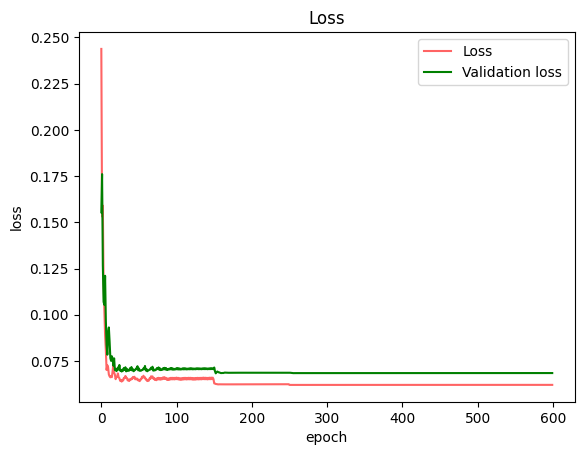

cv_time ：85.785745 s
((0.15, 0.05, 0.01), 600, 50, 50, (0.05, 0.03, 0.01))
enc_circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
enc_circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.8416344620681908
lr: 0.15 0.15
50
step 100, accuracy_train:0.325, loss: 0.13283956777545214
0.1340699202860344
lr: 0.15 0.15
100
0.11981236581636498
lr: 0.15 0.15
150
step 200, accuracy_train:0.3125, loss: 0.16069585883160675
0.037919371800238716
accuracy of best loss : 0.34375
lr: 0.05 0.05
200
0.2479641066624291
lr: 0.05 0.05
250
step 300, accuracy_train:0.4, loss: 0.11501818830899194
0.031190288160504644
lr: 0.05 0.05
300
0.017493900901170655
accuracy of best loss : 0.4
lr: 0.01 0.01
350
step 400, accuracy_train:0.39375, loss: 0.113554175577954
0.03753926282403805
lr: 0.01 0.01
400
0.0018304085956021155
lr: 0.01 0.01
450
step 500, accuracy_train:0.39375, loss: 0.11339249611820726
0.000702717

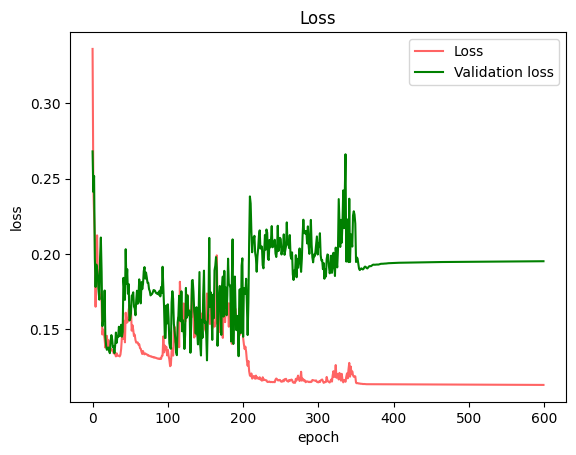

0.8661440373754316
lr: 0.15 0.15
50
step 100, accuracy_train:0.35625, loss: 0.10205621688846553
0.24638413895673472
lr: 0.15 0.15
100
0.09275445217354203
lr: 0.15 0.15
150
step 200, accuracy_train:0.33125, loss: 0.07658476297881475
0.18990121025255774
lr: 0.15 0.15
200
0.16294052188905295
lr: 0.15 0.15
250
step 300, accuracy_train:0.34375, loss: 0.08460778857201051
0.31701152248145426
lr: 0.15 0.15
300
0.17011304300529673
lr: 0.15 0.15
350
step 400, accuracy_train:0.3375, loss: 0.06982498533878814
0.1560695054743448
lr: 0.15 0.15
400
0.0024299576413112796
accuracy of best loss : 0.3375
lr: 0.05 0.05
450
step 500, accuracy_train:0.33125, loss: 0.05859440964387265
0.44408539225896915
lr: 0.05 0.05
500
0.01157625414401435
accuracy of best loss : 0.34375
lr: 0.01 0.01
550
step 600, accuracy_train:0.34375, loss: 0.051978610084294156
0.02821214539919475
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.34375 -45
Epoch:  0 | Cost: 0.050392 | Train accuracy: 0.343750 | Test Accuracy: 0.

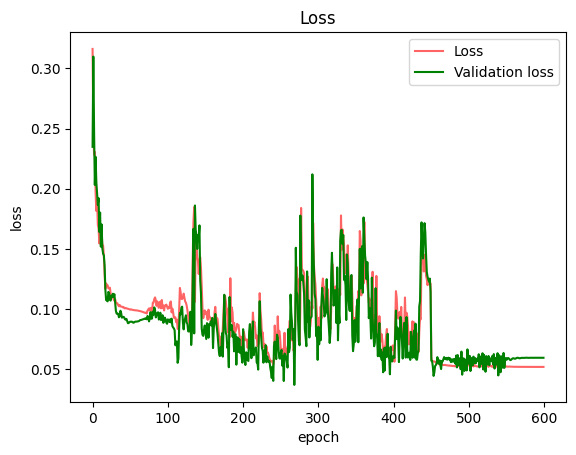

0.8917139849911925
lr: 0.15 0.15
50
step 100, accuracy_train:0.8, loss: 0.06932245874533564
0.3565288410375585
lr: 0.15 0.15
100
0.0043942739176869635
accuracy of best loss : 0.8
lr: 0.05 0.05
150
step 200, accuracy_train:0.8125, loss: 0.06832129792134187
0.014864467135470145
accuracy of best loss : 0.8
lr: 0.01 0.01
200
0.004053775343167574
lr: 0.01 0.01
250
step 300, accuracy_train:0.8125, loss: 0.06805627409900497
9.523792389091715e-05
lr: 0.01 0.01
300
5.203444603027327e-05
lr: 0.01 0.01
350
step 400, accuracy_train:0.8125, loss: 0.0680484706303355
5.6649640531054404e-05
lr: 0.01 0.01
400
7.094610350241465e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.8125, loss: 0.06803576813647871
9.291050800890944e-05
lr: 0.01 0.01
500
0.0001233325748560844
lr: 0.01 0.01
550
step 600, accuracy_train:0.8125, loss: 0.0680131709774639
0.00016520576084367707
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.8125 -1
Epoch:  0 | Cost: 0.066948 | Train accuracy: 0.812500 | Test Accuracy: 0.75

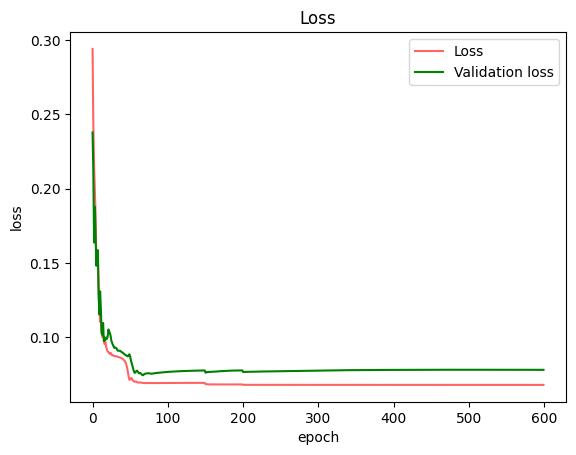

0.9455032975822416
lr: 0.15 0.15
50
step 100, accuracy_train:0.0, loss: 0.01931169345777555
0.6146471752832458
lr: 0.15 0.15
100
0.059758475221730036
lr: 0.15 0.15
150
step 200, accuracy_train:0.0, loss: 0.01891275753757521
0.09964900879614431
lr: 0.15 0.15
200
0.051380166869666885
lr: 0.15 0.15
250
step 300, accuracy_train:0.0, loss: 0.01949429037999309
0.05401417319151677
lr: 0.15 0.15
300
0.08221864237521749
lr: 0.15 0.15
350
step 400, accuracy_train:0.0, loss: 0.019607986235290607
0.04628403105756881
accuracy of best loss : 0.0
lr: 0.05 0.05
400
0.10972035194131846
lr: 0.05 0.05
450
step 500, accuracy_train:0.0, loss: 0.018496064112240224
0.00309404651749767
accuracy of best loss : 0.0
lr: 0.01 0.01
500
0.003224495562785677
lr: 0.01 0.01
550
step 600, accuracy_train:0.0, loss: 0.018439293666442633
0.0001378081735421886
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.0 -47
Epoch:  0 | Cost: 0.018794 | Train accuracy: 0.000000 | Test Accuracy: 0.000000
(n_dim, n_q, n_f, n_r,

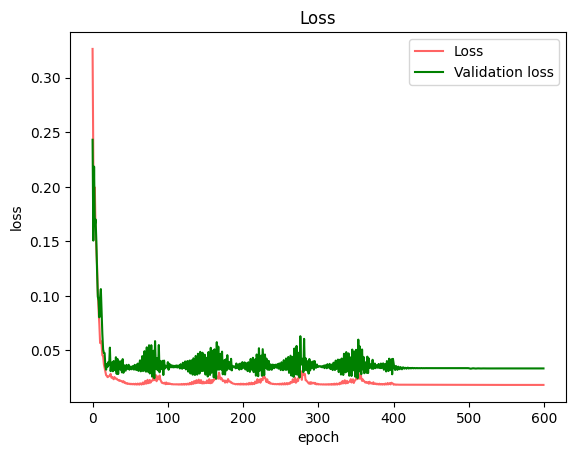

0.8024716166464338
lr: 0.15 0.15
50
step 100, accuracy_train:0.31875, loss: 0.1480938050310379
0.06532384891479502
lr: 0.15 0.15
100
0.24889177971478524
lr: 0.15 0.15
150
step 200, accuracy_train:0.33125, loss: 0.1578773485431228
0.15840558507454577
lr: 0.15 0.15
200
0.04577598270604587
accuracy of best loss : 0.34375
lr: 0.05 0.05
250
step 300, accuracy_train:0.3625, loss: 0.11825836409545956
0.25678713874407116
lr: 0.05 0.05
300
0.0679008688299027
lr: 0.05 0.05
350
step 400, accuracy_train:0.325, loss: 0.16039159948255433
0.20785368623382838
lr: 0.05 0.05
400
0.05229814317987827
lr: 0.05 0.05
450
step 500, accuracy_train:0.3625, loss: 0.12870900001907976
0.09708677937945655
lr: 0.05 0.05
500
0.04746325620684775
lr: 0.05 0.05
550
step 600, accuracy_train:0.3125, loss: 0.16394486434624894
0.11871971835088867
lr: 0.05 0.05
600
lr: 0.05 0.05
accuracy of best loss: 0.2875 -45
Epoch:  0 | Cost: 0.173162 | Train accuracy: 0.293750 | Test Accuracy: 0.300000
(n_dim, n_q, n_f, n_r, n_rot) = (5

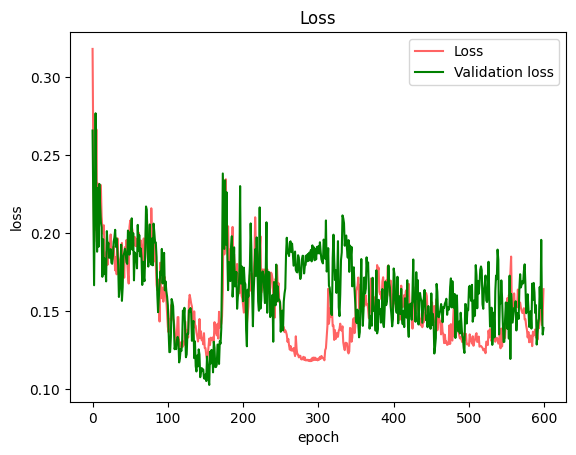

cv_time ：72.852665 s
((0.15, 0.05, 0.01), 600, 100, 50, (0.05, 0.03, 0.01))
0.8720097807287553
lr: 0.15 0.15
50
step 100, accuracy_train:0.0, loss: 0.020664850722464507
0.8225571558942391
lr: 0.15 0.15
100
0.0499803126857941
accuracy of best loss : 0.0
lr: 0.05 0.05
150
step 200, accuracy_train:0.0, loss: 0.02051715763000001
0.04736740579235173
lr: 0.05 0.05
200
0.0028027003105135285
accuracy of best loss : 0.0
lr: 0.01 0.01
250
step 300, accuracy_train:0.0, loss: 0.020471207469415772
0.001051838405102246
lr: 0.01 0.01
300
0.00035610355325900055
lr: 0.01 0.01
350
step 400, accuracy_train:0.0, loss: 0.020455396061612115
0.00038581670967778315
lr: 0.01 0.01
400
0.0004253553644145086
lr: 0.01 0.01
450
step 500, accuracy_train:0.0, loss: 0.020435626900720524
0.000481786721487625
lr: 0.01 0.01
500
0.0005656800682026081
lr: 0.01 0.01
550
step 600, accuracy_train:0.0, loss: 0.02040711983143374
0.0006935230623235892
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.0 -1
Epoch:  0 | Cost

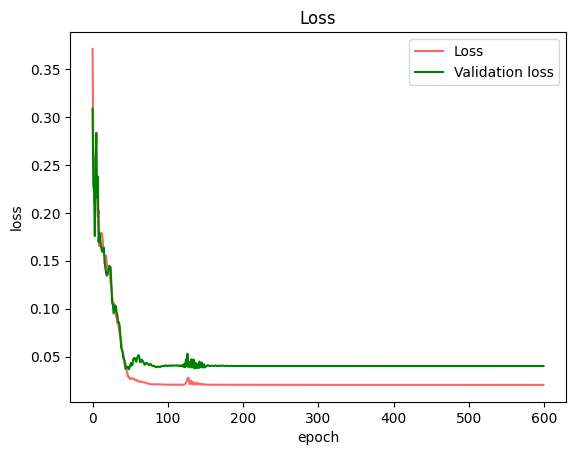

0.8839649498913309
lr: 0.15 0.15
50
step 100, accuracy_train:0.375, loss: 0.06731173971718311
0.3985190824204512
lr: 0.15 0.15
100
0.2998610611482894
lr: 0.15 0.15
150
step 200, accuracy_train:0.94375, loss: 0.028096227490571543
0.41114333466083736
lr: 0.15 0.15
200
0.08560155397083344
lr: 0.15 0.15
250
step 300, accuracy_train:0.925, loss: 0.02526438247574241
0.06596110084417568
lr: 0.15 0.15
300
0.01475424361243043
accuracy of best loss : 0.94375
lr: 0.05 0.05
350
step 400, accuracy_train:0.94375, loss: 0.02426509363730233
0.023971295151627887
accuracy of best loss : 0.94375
lr: 0.01 0.01
400
0.003287706079373481
lr: 0.01 0.01
450
step 500, accuracy_train:0.94375, loss: 0.024260165420630267
8.24220844124702e-06
lr: 0.01 0.01
500
5.492942887188883e-06
lr: 0.01 0.01
550
step 600, accuracy_train:0.94375, loss: 0.024259947671789184
4.452908830927312e-06
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.94375 -141
Epoch:  0 | Cost: 0.024260 | Train accuracy: 0.943750 | Test Accurac

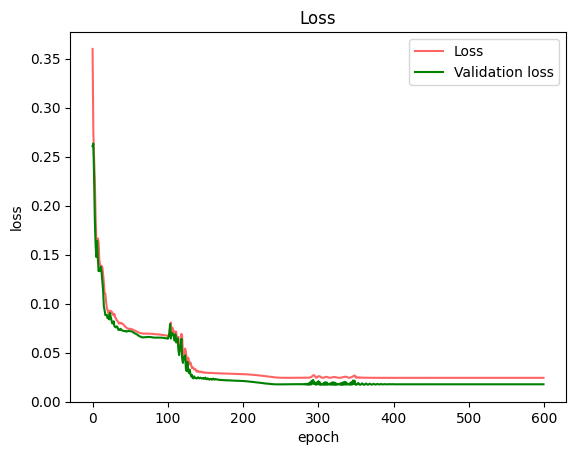

0.8663853945250068
lr: 0.15 0.15
50
step 100, accuracy_train:0.375, loss: 0.08777023386016732
0.3290022820652974
lr: 0.15 0.15
100
0.03106958164411898
accuracy of best loss : 0.425
lr: 0.05 0.05
150
step 200, accuracy_train:0.7875, loss: 0.07315342729744745
0.1291398516546159
lr: 0.05 0.05
200
0.03573192493189649
lr: 0.05 0.05
250
step 300, accuracy_train:0.78125, loss: 0.07285929599435405
0.0011535799538511858
accuracy of best loss : 0.78125
lr: 0.01 0.01
300
6.604573701899632e-05
lr: 0.01 0.01
350
step 400, accuracy_train:0.78125, loss: 0.07285866835799856
4.208932864380393e-06
lr: 0.01 0.01
400
3.2937782005817577e-06
lr: 0.01 0.01
450
step 500, accuracy_train:0.78125, loss: 0.07285825821889909
2.79065442085316e-06
lr: 0.01 0.01
500
2.5319942070570476e-06
lr: 0.01 0.01
550
step 600, accuracy_train:0.78125, loss: 0.07285790286343377
2.430596830945115e-06
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.78125 -1
Epoch:  0 | Cost: 0.072858 | Train accuracy: 0.781250 | Test Accur

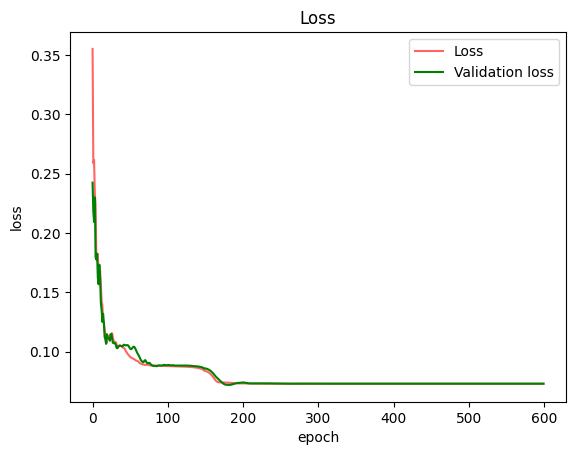

0.831001440249115
lr: 0.15 0.15
50
step 100, accuracy_train:0.65625, loss: 0.1123072778702194
0.20028669380972214
lr: 0.15 0.15
100
0.12953970979225474
lr: 0.15 0.15
150
step 200, accuracy_train:0.3875, loss: 0.1706783126404242
0.15058485712700026
lr: 0.15 0.15
200
0.04663481169435557
accuracy of best loss : 0.38125
lr: 0.05 0.05
250
step 300, accuracy_train:0.41875, loss: 0.13660052276964296
0.14580343259443407
lr: 0.05 0.05
300
0.029651324457858775
accuracy of best loss : 0.4
lr: 0.01 0.01
350
step 400, accuracy_train:0.4125, loss: 0.13081778982122735
0.05469030759677685
lr: 0.01 0.01
400
0.003466105580931153
lr: 0.01 0.01
450
step 500, accuracy_train:0.4, loss: 0.13069794804392051
0.0003608634903396551
lr: 0.01 0.01
500
7.509558812967332e-05
lr: 0.01 0.01
550
step 600, accuracy_train:0.4, loss: 0.13069157011308485
2.1669844067247237e-05
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.4 -1
Epoch:  0 | Cost: 0.130692 | Train accuracy: 0.400000 | Test Accuracy: 0.375000
(n_dim

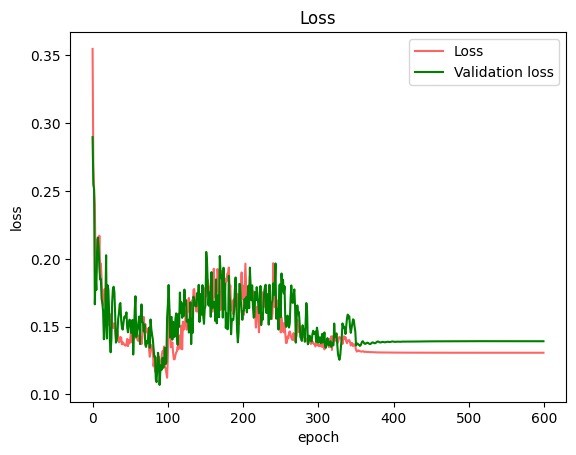

0.825473581909756
lr: 0.15 0.15
50
step 100, accuracy_train:0.19375, loss: 0.12793321319451065
0.26047850918546883
lr: 0.15 0.15
100
0.011901017718382433
accuracy of best loss : 0.2125
lr: 0.05 0.05
150
step 200, accuracy_train:0.2, loss: 0.124664764046695
0.01857588121129123
accuracy of best loss : 0.2
lr: 0.01 0.01
200
0.0041403259201451825
lr: 0.01 0.01
250
step 300, accuracy_train:0.21875, loss: 0.12459243097324729
0.0002752888932364144
lr: 0.01 0.01
300
0.0002621985778989881
lr: 0.01 0.01
350
step 400, accuracy_train:0.21875, loss: 0.12452721661088476
0.0002613030324569962
lr: 0.01 0.01
400
0.0002657918819621426
lr: 0.01 0.01
450
step 500, accuracy_train:0.21875, loss: 0.12445871269695495
0.00027491678244627704
lr: 0.01 0.01
500
0.0002875317098672265
lr: 0.01 0.01
550
step 600, accuracy_train:0.225, loss: 0.12438328530321613
0.0003029843522374824
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.225 -1
Epoch:  0 | Cost: 0.124383 | Train accuracy: 0.225000 | Test Accuracy: 0

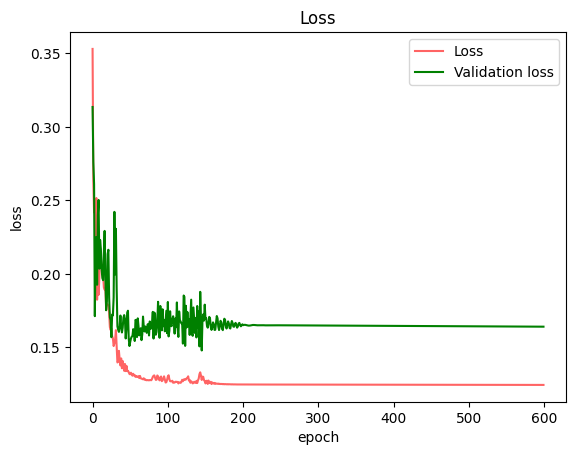

cv_time ：37.191948 s
((0.15, 0.05, 0.01), 600, 300, 50, (0.05, 0.03, 0.01))
0.797405917457453
lr: 0.15 0.15
50
step 100, accuracy_train:0.0875, loss: 0.17926814101672595
0.039424805439852786
accuracy of best loss : 0.2125
lr: 0.05 0.05
100
0.10037377271782637
lr: 0.05 0.05
150
step 200, accuracy_train:0.18125, loss: 0.1962703766229989
0.054442607529044
lr: 0.05 0.05
200
0.023472264181327404
accuracy of best loss : 0.33125
lr: 0.01 0.01
250
step 300, accuracy_train:0.34375, loss: 0.12849545152362196
0.23275283092925378
lr: 0.01 0.01
300
0.012487657167198343
lr: 0.01 0.01
350
step 400, accuracy_train:0.34375, loss: 0.12812172276289072
0.00139938967246002
accuracy of best loss : 0.34375
0.01
lr: 0.001 0.001
400
0.007636551438170689
accuracy of best loss : 0.34375
0.01
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.34375, loss: 0.127101293451541
0.000852526999156392
lr: 0.0001 0.0001
500
1.5821167432078913e-05
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.34375, loss: 0.12709838431690

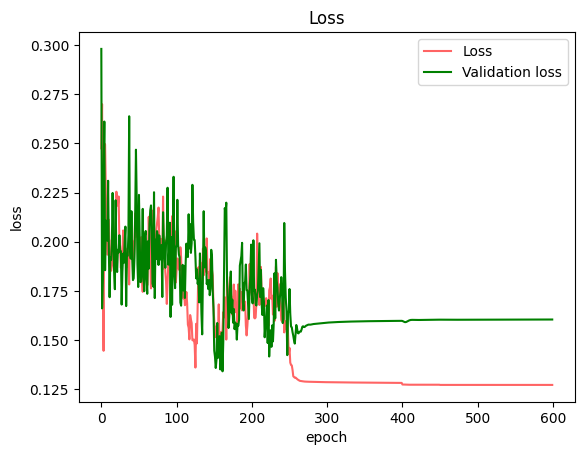

0.7898959705338005
lr: 0.15 0.15
50
step 100, accuracy_train:0.1875, loss: 0.18953903007476253
0.04735700861883529
accuracy of best loss : 0.23125
lr: 0.05 0.05
100
0.2841225252029595
lr: 0.05 0.05
150
step 200, accuracy_train:0.1375, loss: 0.1382314019856119
0.04674770513025986
lr: 0.05 0.05
200
0.021591589784192223
accuracy of best loss : 0.1625
lr: 0.01 0.01
250
step 300, accuracy_train:0.175, loss: 0.12199314691637886
0.12166925259645671
lr: 0.01 0.01
300
0.00603432969696834
accuracy of best loss : 0.175
0.01
lr: 0.001 0.001
350
step 400, accuracy_train:0.175, loss: 0.12079346261951134
0.008262834823247302
accuracy of best loss : 0.175
0.01
lr: 0.0001 0.0001
400
0.000843466498489201
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.175, loss: 0.12070611151071389
2.948195396752828e-05
lr: 0.0001 0.0001
500
2.7946547319981752e-05
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.175, loss: 0.12069935529843803
2.7984919170165262e-05
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001
accuracy of be

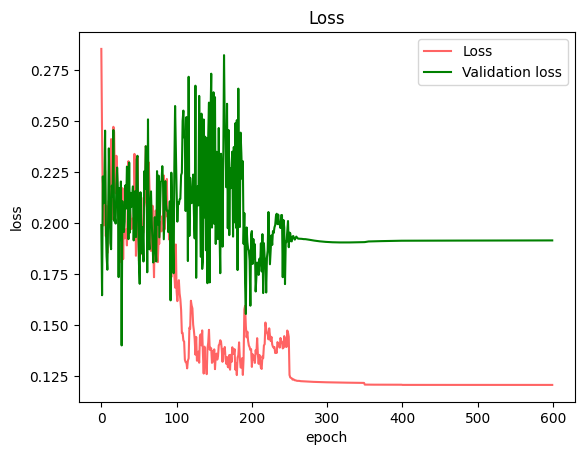

0.908502405685815
lr: 0.15 0.15
50
step 100, accuracy_train:0.76875, loss: 0.07633425621778059
0.16820487469216863
lr: 0.15 0.15
100
0.007445611574911606
accuracy of best loss : 0.7625
lr: 0.05 0.05
150
step 200, accuracy_train:0.78125, loss: 0.0734093669321004
0.027868406703591128
accuracy of best loss : 0.78125
lr: 0.01 0.01
200
0.006846507807162647
accuracy of best loss : 0.775
0.01
lr: 0.001 0.001
250
step 300, accuracy_train:0.78125, loss: 0.07282929716990036
0.0014133354156936808
accuracy of best loss : 0.78125
0.01
lr: 0.0001 0.0001
300
0.00014754398631940883
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.78125, loss: 0.07281878016019443
1.1663161949664664e-07
lr: 0.0001 0.0001
400
9.966755588418408e-08
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.78125, loss: 0.07281876502397007
1.0343066343617542e-07
lr: 0.0001 0.0001
500
1.1553481389881086e-07
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.78125, loss: 0.07281874621851485
1.2929468757138714e-07
lr: 0.0001 0.0001
600
l

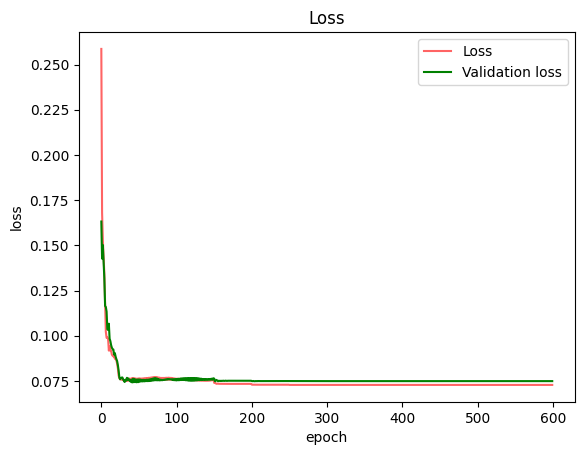

0.9202163391061665
lr: 0.15 0.15
50
step 100, accuracy_train:0.81875, loss: 0.06255563815162099
0.17403766462925374
lr: 0.15 0.15
100
0.05218788597013338
lr: 0.15 0.15
150
step 200, accuracy_train:0.825, loss: 0.06225672629197676
0.0024722339060329994
accuracy of best loss : 0.81875
lr: 0.05 0.05
200
0.03589550305740855
lr: 0.05 0.05
250
step 300, accuracy_train:0.825, loss: 0.06033964864514983
0.0003105807269116029
accuracy of best loss : 0.825
lr: 0.01 0.01
300
0.01107012158643581
lr: 0.01 0.01
350
step 400, accuracy_train:0.825, loss: 0.059656204902466786
0.0002337012386521541
accuracy of best loss : 0.825
0.01
lr: 0.001 0.001
400
0.002643690687782934
accuracy of best loss : 0.825
0.01
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.825, loss: 0.05949090273524174
0.00027771483660958004
lr: 0.0001 0.0001
500
5.6519264037492025e-06
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.825, loss: 0.059490158195689764
6.258393544365047e-06
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001
accuracy of

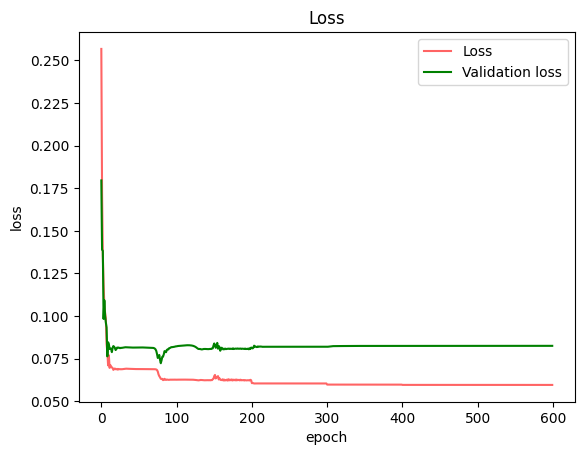

0.9240052089689921
lr: 0.15 0.15
50
step 100, accuracy_train:0.8, loss: 0.06509799666000511
0.13916221342250612
lr: 0.15 0.15
100
0.0003783992317972585
accuracy of best loss : 0.8
lr: 0.05 0.05
150
step 200, accuracy_train:0.8125, loss: 0.06237288101718863
0.04676169832317914
lr: 0.05 0.05
200
0.00016166500767023296
accuracy of best loss : 0.8125
lr: 0.01 0.01
250
step 300, accuracy_train:0.8125, loss: 0.06204683026633951
0.005588418363494038
accuracy of best loss : 0.8125
0.01
lr: 0.001 0.001
300
0.0011540437691005346
accuracy of best loss : 0.8125
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.8125, loss: 0.06196544900050065
0.0001292170651880837
lr: 0.0001 0.0001
400
5.043888319471669e-07
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.8125, loss: 0.06196539052991837
4.7138364972288394e-07
lr: 0.0001 0.0001
500
4.295869867174068e-07
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.8125, loss: 0.06196534223678038
3.8917593107302663e-07
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001


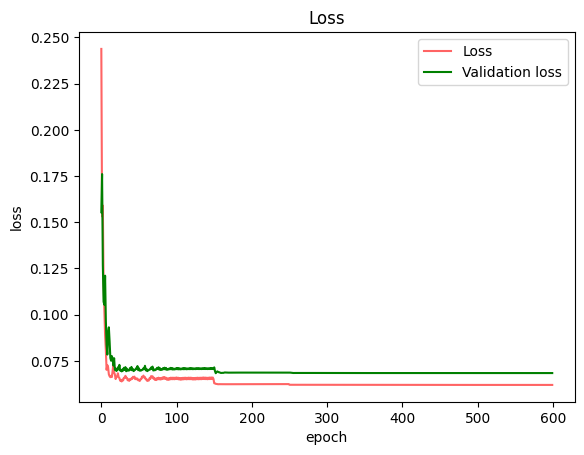

cv_time ：80.132931 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 50, 50, (0.05, 0.03, 0.01))
0.8416344620681908
lr: 0.15 0.15
50
step 100, accuracy_train:0.325, loss: 0.13283956777545214
0.1340699202860344
lr: 0.15 0.15
100
0.11981236581636498
lr: 0.15 0.15
150
step 200, accuracy_train:0.3125, loss: 0.16069585883160675
0.037919371800238716
accuracy of best loss : 0.34375
lr: 0.05 0.05
200
0.2479641066624291
lr: 0.05 0.05
250
step 300, accuracy_train:0.4, loss: 0.11501818830899194
0.031190288160504644
lr: 0.05 0.05
300
0.017493900901170655
accuracy of best loss : 0.4
lr: 0.01 0.01
350
step 400, accuracy_train:0.39375, loss: 0.113554175577954
0.03753926282403805
lr: 0.01 0.01
400
0.0018304085956021155
accuracy of best loss : 0.39375
0.01
lr: 0.001 0.001
450
step 500, accuracy_train:0.39375, loss: 0.11343506960817665
0.0006554298539200911
accuracy of best loss : 0.39375
0.01
lr: 0.0001 0.0001
500
7.195912436222062e-05
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.39375, loss: 0.1134298178

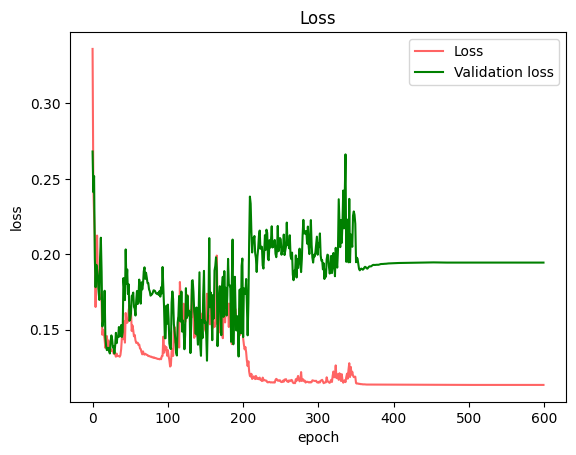

0.8661440373754316
lr: 0.15 0.15
50
step 100, accuracy_train:0.35625, loss: 0.10205621688846553
0.24638413895673472
lr: 0.15 0.15
100
0.09275445217354203
lr: 0.15 0.15
150
step 200, accuracy_train:0.33125, loss: 0.07658476297881475
0.18990121025255774
lr: 0.15 0.15
200
0.16294052188905295
lr: 0.15 0.15
250
step 300, accuracy_train:0.34375, loss: 0.08460778857201051
0.31701152248145426
lr: 0.15 0.15
300
0.17011304300529673
lr: 0.15 0.15
350
step 400, accuracy_train:0.3375, loss: 0.06982498533878814
0.1560695054743448
lr: 0.15 0.15
400
0.0024299576413112796
accuracy of best loss : 0.3375
lr: 0.05 0.05
450
step 500, accuracy_train:0.33125, loss: 0.05859440964387265
0.44408539225896915
lr: 0.05 0.05
500
0.01157625414401435
accuracy of best loss : 0.34375
lr: 0.01 0.01
550
step 600, accuracy_train:0.34375, loss: 0.051978610084294156
0.02821214539919475
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.34375 -45
Epoch:  0 | Cost: 0.050392 | Train accuracy: 0.343750 | Test Accuracy: 0.

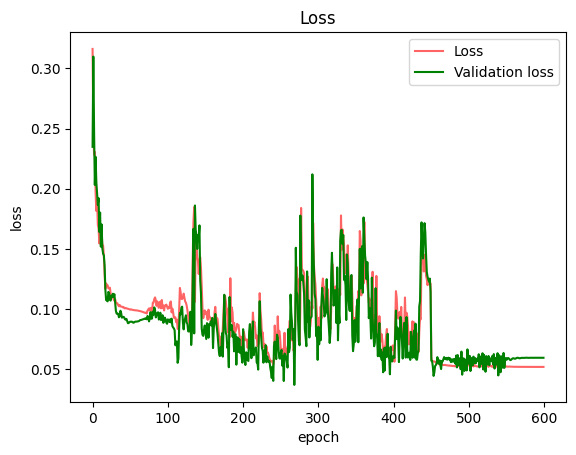

0.8917139849911925
lr: 0.15 0.15
50
step 100, accuracy_train:0.8, loss: 0.06932245874533564
0.3565288410375585
lr: 0.15 0.15
100
0.0043942739176869635
accuracy of best loss : 0.8
lr: 0.05 0.05
150
step 200, accuracy_train:0.8125, loss: 0.06832129792134187
0.014864467135470145
accuracy of best loss : 0.8
lr: 0.01 0.01
200
0.004053775343167574
accuracy of best loss : 0.80625
0.01
lr: 0.001 0.001
250
step 300, accuracy_train:0.80625, loss: 0.06800589428610027
0.0008541821832007835
accuracy of best loss : 0.80625
0.01
lr: 0.0001 0.0001
300
9.257889409196144e-05
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.80625, loss: 0.06799994963174374
1.2261007899116715e-06
lr: 0.0001 0.0001
400
1.2275615691583534e-06
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.80625, loss: 0.06799977935228756
1.2517628696578093e-06
lr: 0.0001 0.0001
500
1.284849824737392e-06
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.80625, loss: 0.06799959995937527
1.3194466126052748e-06
lr: 0.0001 0.0001
600
lr: 0.0001

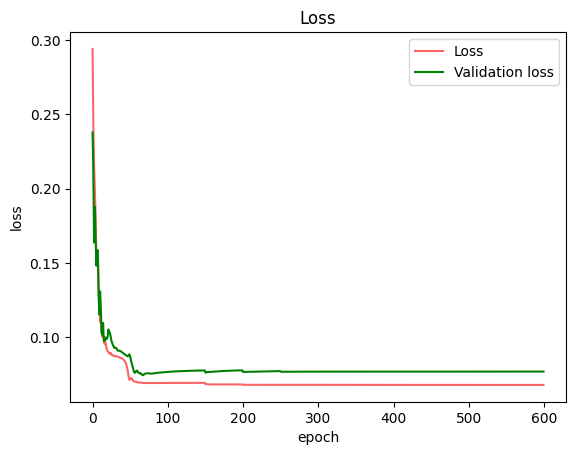

0.9455032975822416
lr: 0.15 0.15
50
step 100, accuracy_train:0.0, loss: 0.01931169345777555
0.6146471752832458
lr: 0.15 0.15
100
0.059758475221730036
lr: 0.15 0.15
150
step 200, accuracy_train:0.0, loss: 0.01891275753757521
0.09964900879614431
lr: 0.15 0.15
200
0.051380166869666885
lr: 0.15 0.15
250
step 300, accuracy_train:0.0, loss: 0.01949429037999309
0.05401417319151677
lr: 0.15 0.15
300
0.08221864237521749
lr: 0.15 0.15
350
step 400, accuracy_train:0.0, loss: 0.019607986235290607
0.04628403105756881
accuracy of best loss : 0.0
lr: 0.05 0.05
400
0.10972035194131846
lr: 0.05 0.05
450
step 500, accuracy_train:0.0, loss: 0.018496064112240224
0.00309404651749767
accuracy of best loss : 0.0
lr: 0.01 0.01
500
0.003224495562785677
accuracy of best loss : 0.0
0.01
lr: 0.001 0.001
550
step 600, accuracy_train:0.0, loss: 0.018430686004517
0.0006507139732839333
accuracy of best loss : 0.0
0.01
lr: 0.0001 0.0001
600
lr: 0.0001 0.001
accuracy of best loss: 0.0 -41
Epoch:  0 | Cost: 0.018793 | T

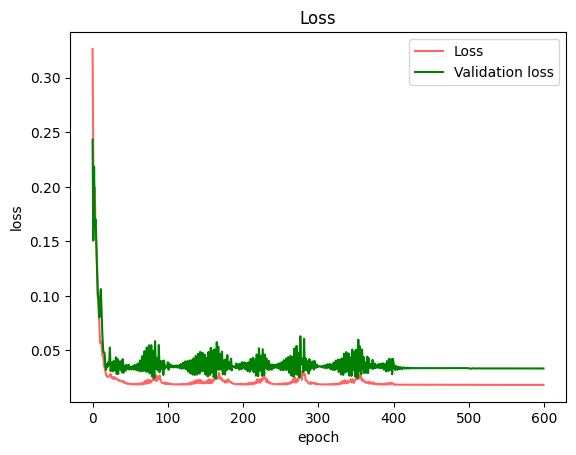

0.8024716166464338
lr: 0.15 0.15
50
step 100, accuracy_train:0.31875, loss: 0.1480938050310379
0.06532384891479502
lr: 0.15 0.15
100
0.24889177971478524
lr: 0.15 0.15
150
step 200, accuracy_train:0.33125, loss: 0.1578773485431228
0.15840558507454577
lr: 0.15 0.15
200
0.04577598270604587
accuracy of best loss : 0.34375
lr: 0.05 0.05
250
step 300, accuracy_train:0.3625, loss: 0.11825836409545956
0.25678713874407116
lr: 0.05 0.05
300
0.0679008688299027
lr: 0.05 0.05
350
step 400, accuracy_train:0.325, loss: 0.16039159948255433
0.20785368623382838
lr: 0.05 0.05
400
0.05229814317987827
lr: 0.05 0.05
450
step 500, accuracy_train:0.3625, loss: 0.12870900001907976
0.09708677937945655
lr: 0.05 0.05
500
0.04746325620684775
lr: 0.05 0.05
550
step 600, accuracy_train:0.3125, loss: 0.16394486434624894
0.11871971835088867
lr: 0.05 0.05
600
lr: 0.05 0.05
accuracy of best loss: 0.2875 -45
Epoch:  0 | Cost: 0.173162 | Train accuracy: 0.293750 | Test Accuracy: 0.300000
(n_dim, n_q, n_f, n_r, n_rot) = (5

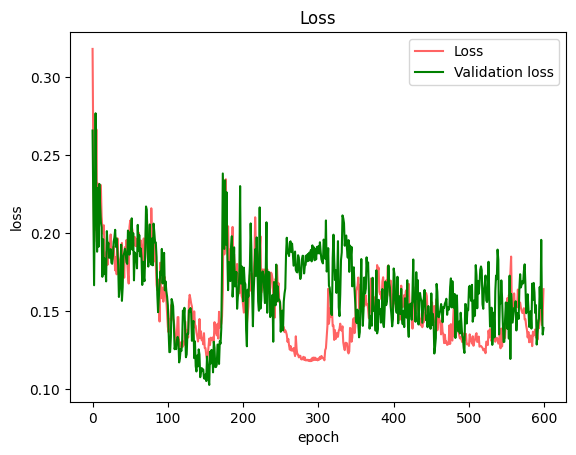

cv_time ：68.826919 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 100, 50, (0.05, 0.03, 0.01))
0.8720097807287553
lr: 0.15 0.15
50
step 100, accuracy_train:0.0, loss: 0.020664850722464507
0.8225571558942391
lr: 0.15 0.15
100
0.0499803126857941
accuracy of best loss : 0.0
lr: 0.05 0.05
150
step 200, accuracy_train:0.0, loss: 0.02051715763000001
0.04736740579235173
lr: 0.05 0.05
200
0.0028027003105135285
accuracy of best loss : 0.0
lr: 0.01 0.01
250
step 300, accuracy_train:0.0, loss: 0.020471207469415772
0.001051838405102246
accuracy of best loss : 0.0
0.01
lr: 0.001 0.001
300
0.00018810269257333933
accuracy of best loss : 0.0
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.0, loss: 0.020470380859750496
2.0418097562478502e-05
lr: 0.0001 0.0001
400
4.199216604791609e-06
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.0, loss: 0.020470196232622903
4.513245302051713e-06
lr: 0.0001 0.0001
500
4.821110198526638e-06
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.0, loss: 0.02046998656445

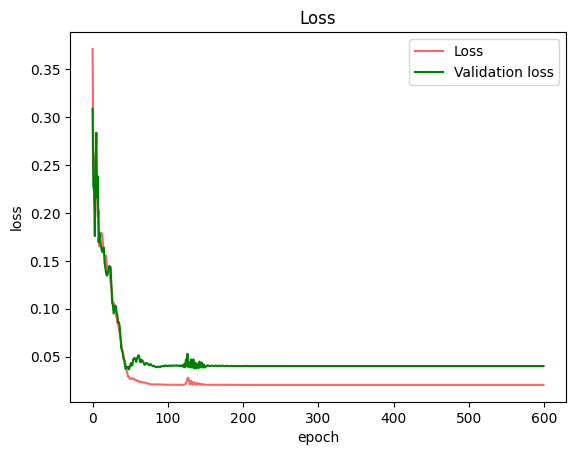

0.8839649498913309
lr: 0.15 0.15
50
step 100, accuracy_train:0.375, loss: 0.06731173971718311
0.3985190824204512
lr: 0.15 0.15
100
0.2998610611482894
lr: 0.15 0.15
150
step 200, accuracy_train:0.94375, loss: 0.028096227490571543
0.41114333466083736
lr: 0.15 0.15
200
0.08560155397083344
lr: 0.15 0.15
250
step 300, accuracy_train:0.925, loss: 0.02526438247574241
0.06596110084417568
lr: 0.15 0.15
300
0.01475424361243043
accuracy of best loss : 0.94375
lr: 0.05 0.05
350
step 400, accuracy_train:0.94375, loss: 0.02426509363730233
0.023971295151627887
accuracy of best loss : 0.94375
lr: 0.01 0.01
400
0.003287706079373481
accuracy of best loss : 0.94375
0.01
lr: 0.001 0.001
450
step 500, accuracy_train:0.94375, loss: 0.024260299044451
5.289982346270887e-06
accuracy of best loss : 0.94375
0.01
lr: 0.0001 0.0001
500
3.8529308678346874e-07
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.94375, loss: 0.024260295444428693
7.494230930308399e-08
lr: 0.0001 0.0001
600
lr: 0.0001 0.001
accuracy of be

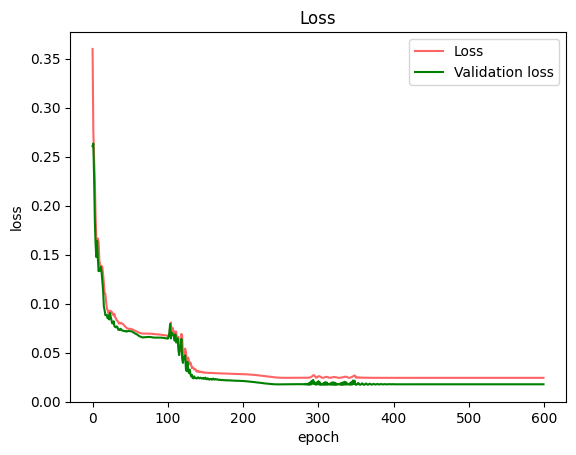

0.8663853945250068
lr: 0.15 0.15
50
step 100, accuracy_train:0.375, loss: 0.08777023386016732
0.3290022820652974
lr: 0.15 0.15
100
0.03106958164411898
accuracy of best loss : 0.425
lr: 0.05 0.05
150
step 200, accuracy_train:0.7875, loss: 0.07315342729744745
0.1291398516546159
lr: 0.05 0.05
200
0.03573192493189649
lr: 0.05 0.05
250
step 300, accuracy_train:0.78125, loss: 0.07285929599435405
0.0011535799538511858
accuracy of best loss : 0.78125
lr: 0.01 0.01
300
6.604573701899632e-05
accuracy of best loss : 0.78125
0.01
lr: 0.001 0.001
350
step 400, accuracy_train:0.78125, loss: 0.07285890569712299
2.472051321399917e-06
accuracy of best loss : 0.78125
0.01
lr: 0.0001 0.0001
400
2.2382051559714925e-07
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.78125, loss: 0.07285889923369131
4.480454820336004e-08
lr: 0.0001 0.0001
500
4.7690824098414075e-08
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.78125, loss: 0.0728588918788226
5.0506376513584336e-08
lr: 0.0001 0.0001
600
lr: 0.0001 0.01
a

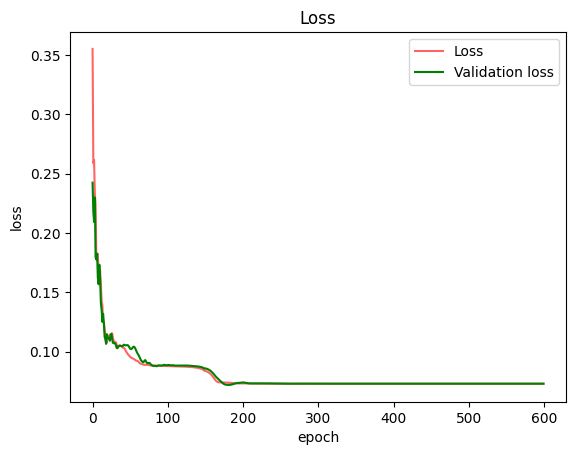

0.831001440249115
lr: 0.15 0.15
50
step 100, accuracy_train:0.65625, loss: 0.1123072778702194
0.20028669380972214
lr: 0.15 0.15
100
0.12953970979225474
lr: 0.15 0.15
150
step 200, accuracy_train:0.3875, loss: 0.1706783126404242
0.15058485712700026
lr: 0.15 0.15
200
0.04663481169435557
accuracy of best loss : 0.38125
lr: 0.05 0.05
250
step 300, accuracy_train:0.41875, loss: 0.13660052276964296
0.14580343259443407
lr: 0.05 0.05
300
0.029651324457858775
accuracy of best loss : 0.4
lr: 0.01 0.01
350
step 400, accuracy_train:0.4125, loss: 0.13081778982122735
0.05469030759677685
lr: 0.01 0.01
400
0.003466105580931153
accuracy of best loss : 0.4
0.01
lr: 0.001 0.001
450
step 500, accuracy_train:0.4, loss: 0.1307137522029197
0.0002815080558250025
accuracy of best loss : 0.4
0.01
lr: 0.0001 0.0001
500
1.2729464922231505e-05
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.4, loss: 0.13071314438897955
2.347163240660656e-06
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001
accuracy of best loss: 0.4 -100
E

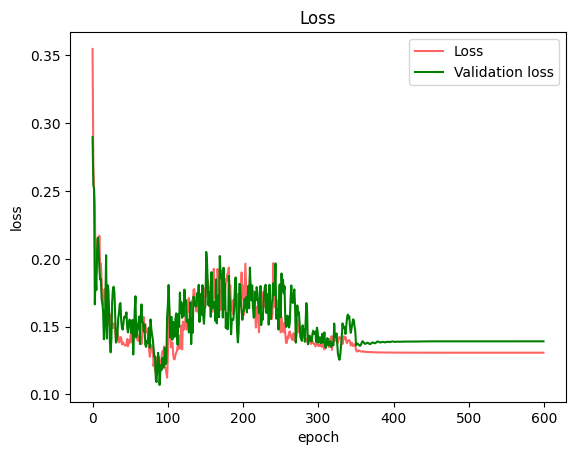

0.825473581909756
lr: 0.15 0.15
50
step 100, accuracy_train:0.19375, loss: 0.12793321319451065
0.26047850918546883
lr: 0.15 0.15
100
0.011901017718382433
accuracy of best loss : 0.2125
lr: 0.05 0.05
150
step 200, accuracy_train:0.2, loss: 0.124664764046695
0.01857588121129123
accuracy of best loss : 0.2
lr: 0.01 0.01
200
0.0041403259201451825
accuracy of best loss : 0.21875
0.01
lr: 0.001 0.001
250
step 300, accuracy_train:0.21875, loss: 0.12462197833430318
0.00015346551118877413
accuracy of best loss : 0.21875
0.01
lr: 0.0001 0.0001
300
1.5288812065610824e-05
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.21875, loss: 0.12462119898974411
3.159078919892265e-06
lr: 0.0001 0.0001
400
3.4150624030933687e-06
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.21875, loss: 0.12462028677372339
3.6629484220467962e-06
lr: 0.0001 0.0001
500
3.904295274048447e-06
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.21875, loss: 0.12461925546389585
4.14049570265984e-06
lr: 0.0001 0.0001
600
lr: 0.0001

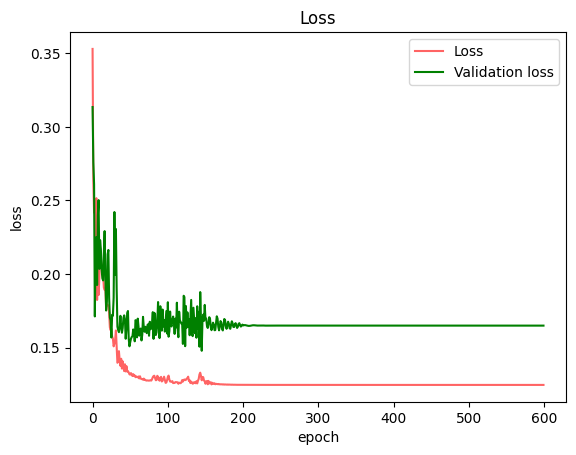

cv_time ：36.893366 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 300, 50, (0.05, 0.03, 0.01))


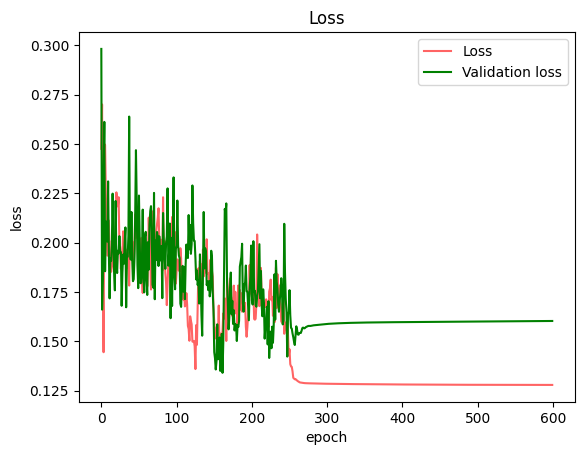

enc_circuit is jitted
circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
enc_circuit is jitted
circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
enc_circuit is jitted
circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.8392801065266828
lr: 0.15 0.15
50
step 100, accuracy_train:0.6, loss: 0.09112380762480907
0.40096070106580495
lr: 0.15 0.15
100
0.05272559061742195
lr: 0.15 0.15
150
step 200, accuracy_train:0.575, loss: 0.09609700294162046
0.01738691777364539
accuracy of best loss : 0.625
lr: 0.05 0.05
200
0.06527804234849136
lr: 0.05 0.05
250
step 300, accuracy_train:0.64375, loss: 0.08925239033667205
0.011014613043802041
accuracy of best loss : 0.65625
lr: 0.01 0.01
300
0.03512033147195451
lr: 0.01 0.01
350
step 400, accuracy_train:0.66875, loss: 0.08419214708528083
0.0034476988337934283
lr: 0.01 0.01
400
0.0027601940355

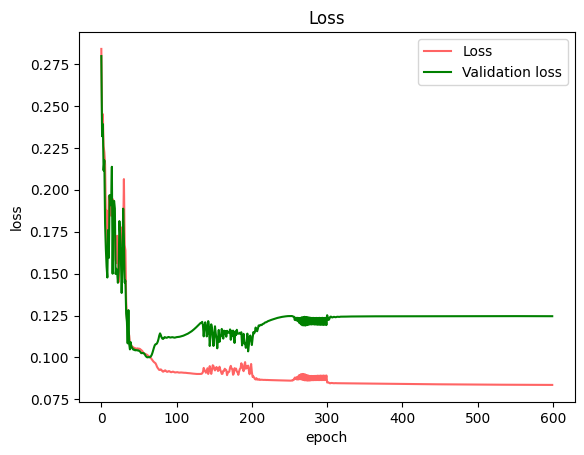

0.8876414735241043
lr: 0.15 0.15
50
step 100, accuracy_train:0.63125, loss: 0.1250806049800009
0.08979203496748185
lr: 0.15 0.15
100
0.24870038435803535
lr: 0.15 0.15
150
step 200, accuracy_train:0.80625, loss: 0.0552134499483134
0.19314998927876578
lr: 0.15 0.15
200
0.006700822862972482
accuracy of best loss : 0.81875
lr: 0.05 0.05
250
step 300, accuracy_train:0.86875, loss: 0.04608309975406144
0.24389526590245023
lr: 0.05 0.05
300
0.05328155068337216
lr: 0.05 0.05
350
step 400, accuracy_train:0.86875, loss: 0.04419778983604328
0.0014088613359255666
accuracy of best loss : 0.875
lr: 0.01 0.01
400
0.11065085014366027
lr: 0.01 0.01
450
step 500, accuracy_train:0.8875, loss: 0.03940759018087056
0.00785092408321334
lr: 0.01 0.01
500
0.0032103755398188542
lr: 0.01 0.01
550
step 600, accuracy_train:0.9, loss: 0.03919508894968974
0.002678147739681539
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.9 -50
Epoch:  0 | Cost: 0.045917 | Train accuracy: 0.900000 | Test Accuracy: 0.800000


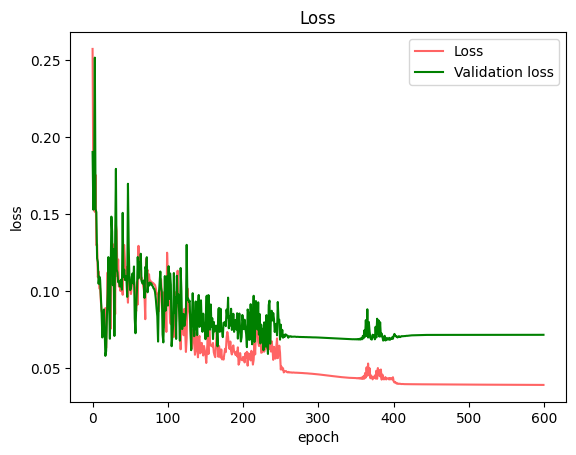

0.8527770008454916
lr: 0.15 0.15
50
step 100, accuracy_train:0.6, loss: 0.09392424657300483
0.3111556986767175
lr: 0.15 0.15
100
0.07209084682130866
lr: 0.15 0.15
150
step 200, accuracy_train:0.525, loss: 0.10162140338645959
0.03137101318887191
accuracy of best loss : 0.6125
lr: 0.05 0.05
200
0.09446532790677074
lr: 0.05 0.05
250
step 300, accuracy_train:0.65625, loss: 0.08181261240266954
0.010163528341051711
accuracy of best loss : 0.65625
lr: 0.01 0.01
300
0.10945807210731871
lr: 0.01 0.01
350
step 400, accuracy_train:0.7375, loss: 0.07523479275010317
0.022400479397162477
lr: 0.01 0.01
400
0.012557101808224535
lr: 0.01 0.01
450
step 500, accuracy_train:0.725, loss: 0.07412289668715288
0.0070737733376565306
lr: 0.01 0.01
500
0.002998792343857178
lr: 0.01 0.01
550
step 600, accuracy_train:0.725, loss: 0.07381741756999532
0.002003455010244271
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.725 -50
Epoch:  0 | Cost: 0.085996 | Train accuracy: 0.718750 | Test Accuracy: 0.625000
(

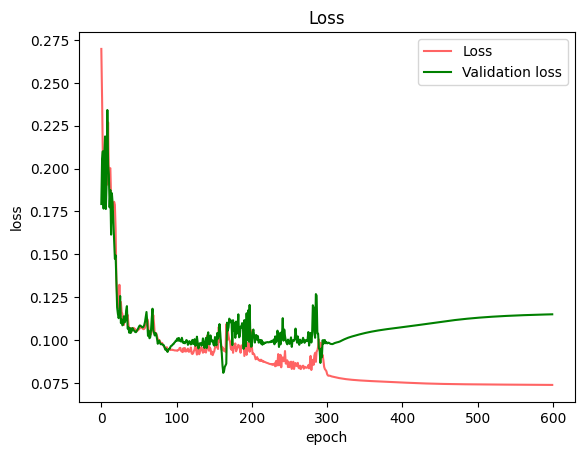

0.8048659691425917
lr: 0.15 0.15
50
step 100, accuracy_train:0.375, loss: 0.12630418532760063
0.12959531147272554
lr: 0.15 0.15
100
0.09605991994205454
lr: 0.15 0.15
150
step 200, accuracy_train:0.34375, loss: 0.15189819616950878
0.03257800463964033
accuracy of best loss : 0.3625
lr: 0.05 0.05
200
0.08099229990352058
lr: 0.05 0.05
250
step 300, accuracy_train:0.3625, loss: 0.12497822214387024
0.03919471673893611
lr: 0.05 0.05
300
0.015114835959985588
accuracy of best loss : 0.375
lr: 0.01 0.01
350
step 400, accuracy_train:0.36875, loss: 0.1105202595075183
0.08762165737439753
lr: 0.01 0.01
400
0.001997045054351685
lr: 0.01 0.01
450
step 500, accuracy_train:0.3625, loss: 0.13136488013430486
0.029058777123545515
lr: 0.01 0.01
500
0.015266947737217167
lr: 0.01 0.01
550
step 600, accuracy_train:0.3875, loss: 0.12540929497955972
0.0034913084823655874
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.35 -9
Epoch:  0 | Cost: 0.130585 | Train accuracy: 0.356250 | Test Accuracy: 0.375000


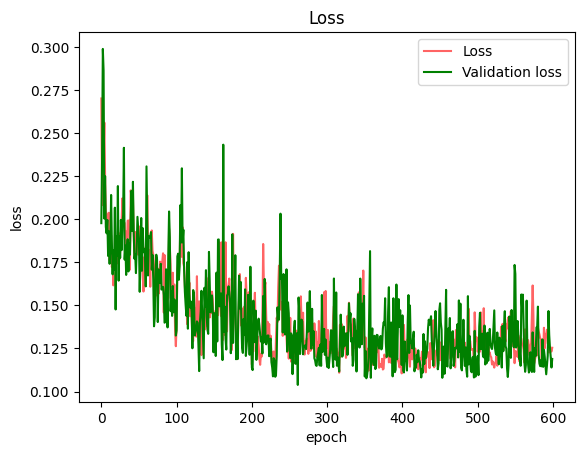

0.8366424459992753
lr: 0.15 0.15
50
step 100, accuracy_train:0.625, loss: 0.1065495336763792
0.35959553834929214
lr: 0.15 0.15
100
0.005248430325645813
accuracy of best loss : 0.625
lr: 0.05 0.05
150
step 200, accuracy_train:0.56875, loss: 0.10237615229872438
0.050871045316640995
lr: 0.05 0.05
200
0.0009894998204218926
accuracy of best loss : 0.65
lr: 0.01 0.01
250
step 300, accuracy_train:0.66875, loss: 0.0955809888430745
0.03858815075975237
lr: 0.01 0.01
300
0.0033748936823617738
lr: 0.01 0.01
350
step 400, accuracy_train:0.6625, loss: 0.09550269508063203
0.00031086655629625887
lr: 0.01 0.01
400
0.0002572064750767886
lr: 0.01 0.01
450
step 500, accuracy_train:0.6625, loss: 0.09544825483871794
0.0002849626130978812
lr: 0.01 0.01
500
0.0003167909415099428
lr: 0.01 0.01
550
step 600, accuracy_train:0.66875, loss: 0.09538160853720727
0.00034967020497585075
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.66875 -50
Epoch:  0 | Cost: 0.097749 | Train accuracy: 0.662500 | Test Accur

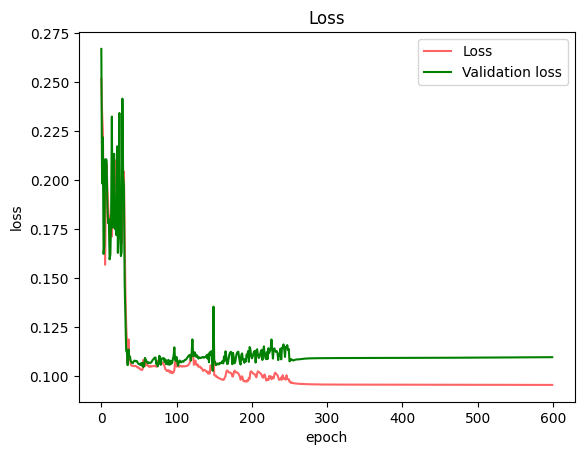

cv_time ：116.637991 s
((0.15, 0.05, 0.01), 600, 50, 50, (0.05, 0.03, 0.01))
enc_circuit is jitted
circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
enc_circuit is jitted
circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.8820996103502852
lr: 0.15 0.15
50
step 100, accuracy_train:0.55625, loss: 0.17336672981264187
0.5893542265906518
lr: 0.15 0.15
100
0.19157135517853174
lr: 0.15 0.15
150
step 200, accuracy_train:0.6375, loss: 0.11786475705016089
0.07375639973774602
lr: 0.15 0.15
200
0.025431677156394928
accuracy of best loss : 0.63125
lr: 0.05 0.05
250
step 300, accuracy_train:0.61875, loss: 0.11364473756994722
0.06876452471227949
lr: 0.05 0.05
300
0.02593124333030634
accuracy of best loss : 0.6125
lr: 0.01 0.01
350
step 400, accuracy_train:0.63125, loss: 0.10481849846088903
0.12662423556170233
lr: 0.01 0.01
400
0.028454071612513784
lr: 0.01 0.01
450
step 500, accuracy_train:

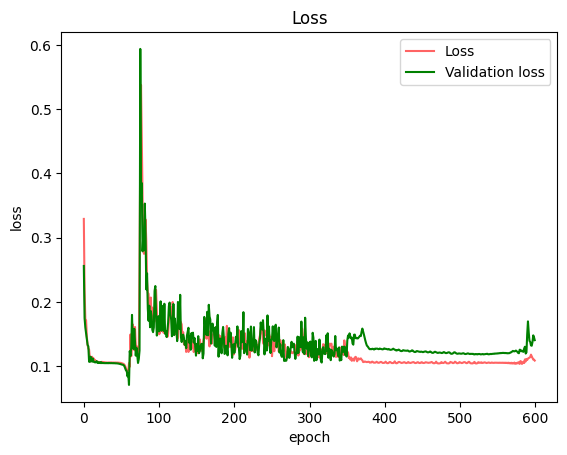

0.8809624297405082
lr: 0.15 0.15
50
step 100, accuracy_train:0.10625, loss: 0.057617723868512105
0.40006303820192446
lr: 0.15 0.15
100
0.12513103267210757
lr: 0.15 0.15
150
step 200, accuracy_train:0.075, loss: 0.052328104066901845
0.11759368690474771
lr: 0.15 0.15
200
0.07681264401711196
lr: 0.15 0.15
250
step 300, accuracy_train:0.1125, loss: 0.06330584308507403
0.028366427990143942
accuracy of best loss : 0.10625
lr: 0.05 0.05
300
0.21885922908343278
lr: 0.05 0.05
350
step 400, accuracy_train:0.06875, loss: 0.04391788690612425
0.00326935534340624
accuracy of best loss : 0.0625
lr: 0.01 0.01
400
0.0429106523725648
lr: 0.01 0.01
450
step 500, accuracy_train:0.06875, loss: 0.043180343142222195
0.0015046978254242202
lr: 0.01 0.01
500
0.0008612887469879539
lr: 0.01 0.01
550
step 600, accuracy_train:0.06875, loss: 0.04312136674484579
0.0006751667309711405
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.06875 -1
Epoch:  0 | Cost: 0.044089 | Train accuracy: 0.068750 | Test Accuracy

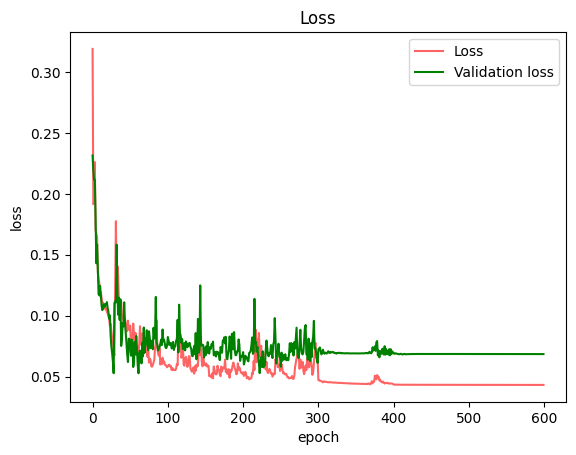

0.8171317422371414
lr: 0.15 0.15
50
step 100, accuracy_train:0.325, loss: 0.15862740781180704
0.10045004650352213
lr: 0.15 0.15
100
0.1539355034987917
lr: 0.15 0.15
150
step 200, accuracy_train:0.36875, loss: 0.11881631916789068
0.043380083435744975
accuracy of best loss : 0.36875
lr: 0.05 0.05
200
0.09273738713102657
lr: 0.05 0.05
250
step 300, accuracy_train:0.35625, loss: 0.12637711992712228
0.0011382908578421596
accuracy of best loss : 0.375
lr: 0.01 0.01
300
0.029465578348207396
lr: 0.01 0.01
350
step 400, accuracy_train:0.375, loss: 0.10946015002350037
0.03374360334960103
lr: 0.01 0.01
400
0.011428824595491712
lr: 0.01 0.01
450
step 500, accuracy_train:0.36875, loss: 0.11327752781488669
0.030651013887439314
lr: 0.01 0.01
500
0.038419044819419455
lr: 0.01 0.01
550
step 600, accuracy_train:0.375, loss: 0.10170415613537914
0.07720598412975649
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.375 -3
Epoch:  0 | Cost: 0.101827 | Train accuracy: 0.375000 | Test Accuracy: 0.37500

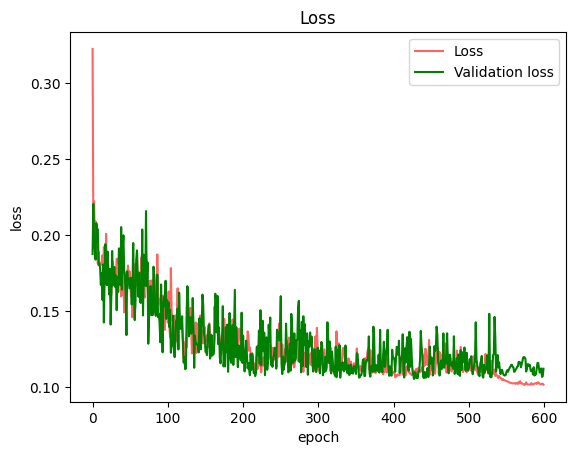

0.8403245393640654
lr: 0.15 0.15
50
step 100, accuracy_train:0.3, loss: 0.15313402912276303
0.14145903596518936
lr: 0.15 0.15
100
0.10758487288270371
lr: 0.15 0.15
150
step 200, accuracy_train:0.34375, loss: 0.14345762980785848
0.08620961752731791
lr: 0.15 0.15
200
0.018874087128384454
accuracy of best loss : 0.3625
lr: 0.05 0.05
250
step 300, accuracy_train:0.35, loss: 0.13365565257925943
0.046010979889844955
lr: 0.05 0.05
300
0.0562392733113509
lr: 0.05 0.05
350
step 400, accuracy_train:0.325, loss: 0.15342782606142286
0.03910009834017673
lr: 0.05 0.05
400
0.005514366791588062
accuracy of best loss : 0.36875
lr: 0.01 0.01
450
step 500, accuracy_train:0.34375, loss: 0.13347461914184736
0.05585931813148879
lr: 0.01 0.01
500
0.026036354226143508
lr: 0.01 0.01
550
step 600, accuracy_train:0.3625, loss: 0.11974302180134375
0.04827053605691343
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.35625 -9
Epoch:  0 | Cost: 0.135972 | Train accuracy: 0.350000 | Test Accuracy: 0.350000
(n

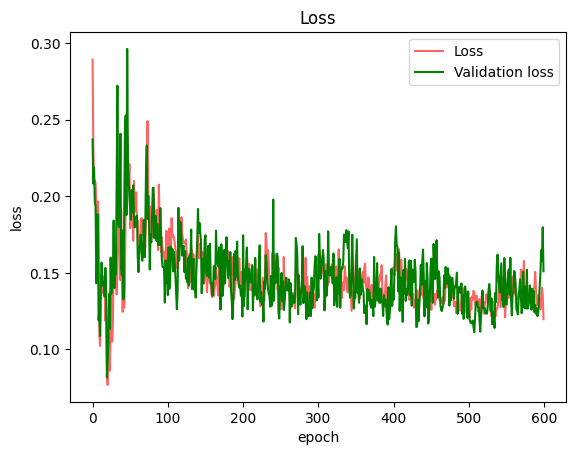

0.823090902751395
lr: 0.15 0.15
50
step 100, accuracy_train:0.33125, loss: 0.15068500886585723
0.20568251694385475
lr: 0.15 0.15
100
0.039660363297670434
accuracy of best loss : 0.35625
lr: 0.05 0.05
150
step 200, accuracy_train:0.3375, loss: 0.1402886023254409
0.031849611657306424
lr: 0.05 0.05
200
0.032228038027125865
lr: 0.05 0.05
250
step 300, accuracy_train:0.3625, loss: 0.13150739528548946
0.019501892974843865
accuracy of best loss : 0.36875
lr: 0.01 0.01
300
0.1595300091981233
lr: 0.01 0.01
350
step 400, accuracy_train:0.38125, loss: 0.10343142089730899
0.04289650104246075
lr: 0.01 0.01
400
0.039138716779402775
lr: 0.01 0.01
450
step 500, accuracy_train:0.38125, loss: 0.1037070133848859
0.0016311040903061592
lr: 0.01 0.01
500
0.001959603964276623
lr: 0.01 0.01
550
step 600, accuracy_train:0.38125, loss: 0.10454346918112778
0.002321462302327675
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.375 -3
Epoch:  0 | Cost: 0.103634 | Train accuracy: 0.375000 | Test Accuracy: 0.

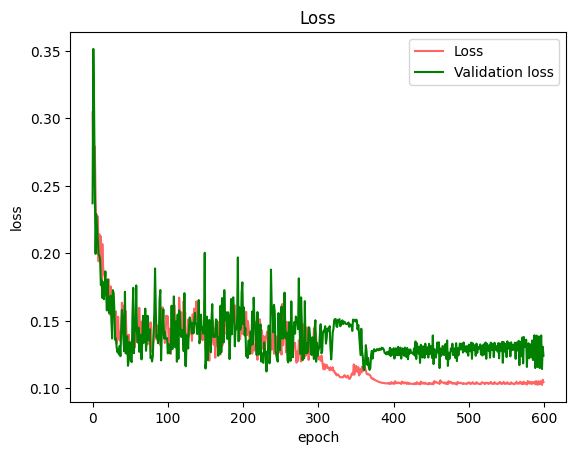

cv_time ：101.314498 s
((0.15, 0.05, 0.01), 600, 100, 50, (0.05, 0.03, 0.01))
0.8882044657585428
lr: 0.15 0.15
50
step 100, accuracy_train:0.13125, loss: 0.022345631467285583
0.7537736142710805
lr: 0.15 0.15
100
0.24088662980509784
lr: 0.15 0.15
150
step 200, accuracy_train:0.0, loss: 0.01900025601871859
0.015938749985488335
accuracy of best loss : 0.0
lr: 0.05 0.05
200
0.10867939849574554
lr: 0.05 0.05
250
step 300, accuracy_train:0.0, loss: 0.018761982458474564
0.005628235229844581
accuracy of best loss : 0.0
lr: 0.01 0.01
300
0.0034622229142056518
lr: 0.01 0.01
350
step 400, accuracy_train:0.0, loss: 0.018711823357762235
0.0013512757139425994
lr: 0.01 0.01
400
0.0014832254697984878
lr: 0.01 0.01
450
step 500, accuracy_train:0.0, loss: 0.018651493983689323
0.0016148278416079375
lr: 0.01 0.01
500
0.001744172755254573
lr: 0.01 0.01
550
step 600, accuracy_train:0.0, loss: 0.018581979839446174
0.0018673753693402946
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.0 -50
Epoch:  0 |

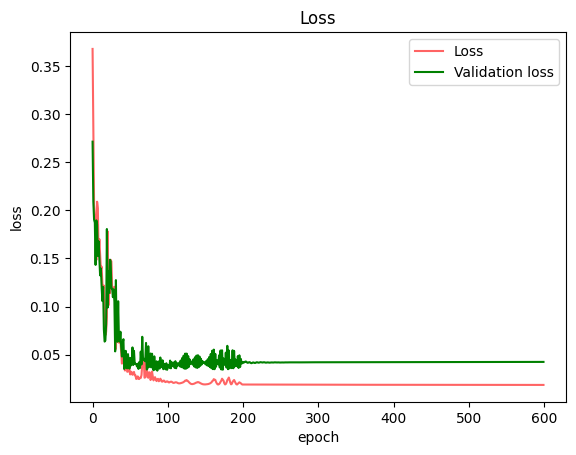

0.8977301009929485
lr: 0.15 0.15
50
step 100, accuracy_train:0.9125, loss: 0.03595869229897208
0.616161623294573
lr: 0.15 0.15
100
0.126655685530276
lr: 0.15 0.15
150
step 200, accuracy_train:0.925, loss: 0.032294237777208565
0.043370603338470204
accuracy of best loss : 0.925
lr: 0.05 0.05
200
0.022883696117426435
accuracy of best loss : 0.91875
lr: 0.01 0.01
250
step 300, accuracy_train:0.91875, loss: 0.03168228900412034
0.009678529212768695
lr: 0.01 0.01
300
0.0034965494158561883
lr: 0.01 0.01
350
step 400, accuracy_train:0.91875, loss: 0.03145041505412966
0.0036711620480328476
lr: 0.01 0.01
400
0.0038008128851119106
lr: 0.01 0.01
450
step 500, accuracy_train:0.925, loss: 0.031208353344777576
0.0038655227322771787
lr: 0.01 0.01
500
0.0038122210054014993
lr: 0.01 0.01
550
step 600, accuracy_train:0.925, loss: 0.03098675686714642
0.0035725130750712767
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.925 -1
Epoch:  0 | Cost: 0.030987 | Train accuracy: 0.925000 | Test Accuracy: 0

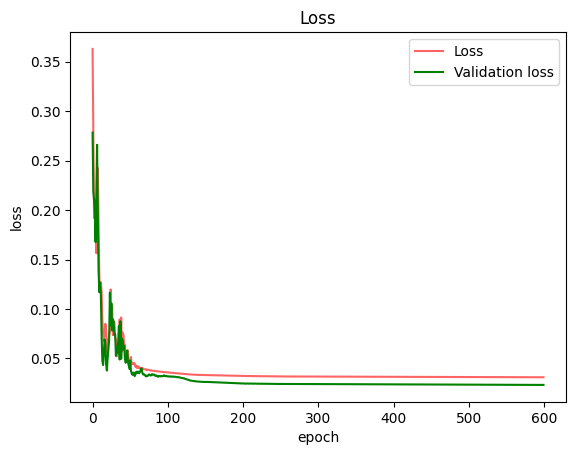

0.7967316792091501
lr: 0.15 0.15
50
step 100, accuracy_train:0.2625, loss: 0.17080348524608535
0.13994484748230063
lr: 0.15 0.15
100
0.005091995360515216
accuracy of best loss : 0.3125
lr: 0.05 0.05
150
step 200, accuracy_train:0.26875, loss: 0.1629134714075558
0.07256963935514768
lr: 0.05 0.05
200
0.009829029144695496
accuracy of best loss : 0.3125
lr: 0.01 0.01
250
step 300, accuracy_train:0.35625, loss: 0.1254585160240144
0.18620642646056826
lr: 0.01 0.01
300
0.06719309893777216
lr: 0.01 0.01
350
step 400, accuracy_train:0.35625, loss: 0.12403191449040084
0.0027221233535274186
lr: 0.01 0.01
400
0.0009075444717838023
lr: 0.01 0.01
450
step 500, accuracy_train:0.3625, loss: 0.12378736025713877
0.0012878340251891082
lr: 0.01 0.01
500
0.0009962159431793041
lr: 0.01 0.01
550
step 600, accuracy_train:0.35625, loss: 0.12404347124825268
0.001172805115606343
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.35625 -30
Epoch:  0 | Cost: 0.125319 | Train accuracy: 0.356250 | Test Accurac

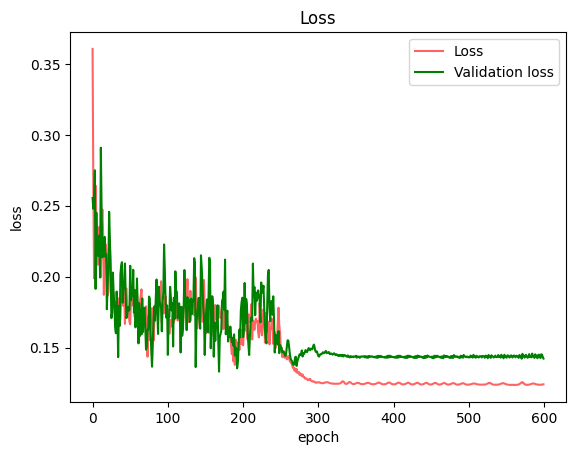

0.8192684369499426
lr: 0.15 0.15
50
step 100, accuracy_train:0.375, loss: 0.1097329455744788
0.41403201726339195
lr: 0.15 0.15
100
0.1365376630341259
lr: 0.15 0.15
150
step 200, accuracy_train:0.79375, loss: 0.058555731457645255
0.26415477084066546
lr: 0.15 0.15
200
0.13714709369467648
lr: 0.15 0.15
250
step 300, accuracy_train:0.90625, loss: 0.04149116918422666
0.2632320903389218
lr: 0.15 0.15
300
0.06922450491346174
lr: 0.15 0.15
350
step 400, accuracy_train:0.90625, loss: 0.036693175892465735
0.06472144930349756
lr: 0.15 0.15
400
0.023322525455028012
accuracy of best loss : 0.90625
lr: 0.05 0.05
450
step 500, accuracy_train:0.9125, loss: 0.0357935165062415
0.011460299252313913
accuracy of best loss : 0.9125
lr: 0.01 0.01
500
0.005554854114957627
lr: 0.01 0.01
550
step 600, accuracy_train:0.9125, loss: 0.035608962146856646
0.0026038388395009287
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.9125 -50
Epoch:  0 | Cost: 0.035709 | Train accuracy: 0.912500 | Test Accuracy: 0.82

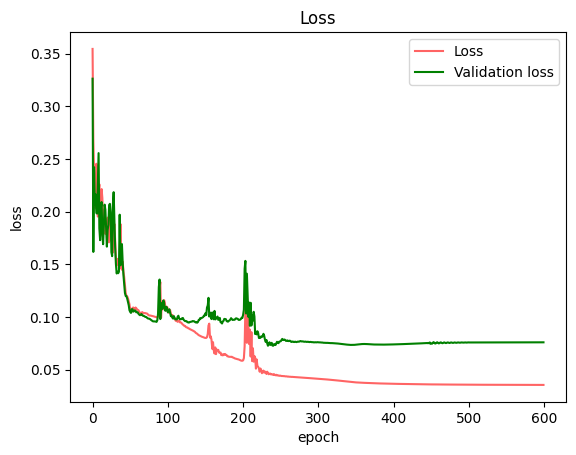

0.789509570407077
lr: 0.15 0.15
50
step 100, accuracy_train:0.325, loss: 0.15714037652434373
0.2152914022064928
lr: 0.15 0.15
100
0.012640313420555972
accuracy of best loss : 0.35
lr: 0.05 0.05
150
step 200, accuracy_train:0.36875, loss: 0.11838638105367533
0.1974908596254513
lr: 0.05 0.05
200
0.10365756542910814
lr: 0.05 0.05
250
step 300, accuracy_train:0.375, loss: 0.11354759621411713
0.022119172841215607
accuracy of best loss : 0.38125
lr: 0.01 0.01
300
0.029628273087306103
lr: 0.01 0.01
350
step 400, accuracy_train:0.38125, loss: 0.11097428974056206
0.00276303271241374
lr: 0.01 0.01
400
0.000538533919900439
lr: 0.01 0.01
450
step 500, accuracy_train:0.38125, loss: 0.11090212530313846
0.00031233607825208556
lr: 0.01 0.01
500
0.00023964240372027182
lr: 0.01 0.01
550
step 600, accuracy_train:0.38125, loss: 0.11083993434032054
0.00026189186673937807
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.38125 -1
Epoch:  0 | Cost: 0.110840 | Train accuracy: 0.381250 | Test Accuracy: 

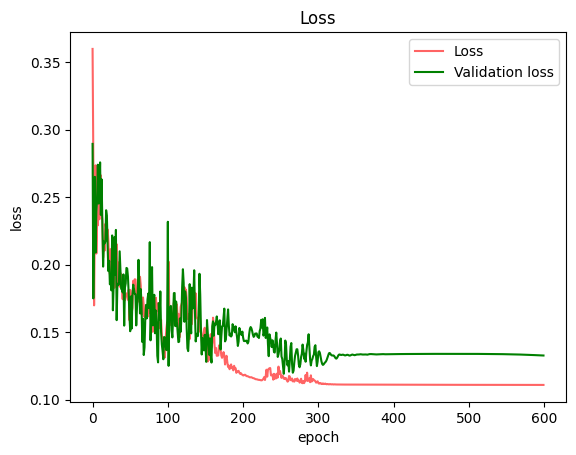

cv_time ：51.125139 s
((0.15, 0.05, 0.01), 600, 300, 50, (0.05, 0.03, 0.01))
0.8392801065266828
lr: 0.15 0.15
50
step 100, accuracy_train:0.6, loss: 0.09112380762480907
0.40096070106580495
lr: 0.15 0.15
100
0.05272559061742195
lr: 0.15 0.15
150
step 200, accuracy_train:0.575, loss: 0.09609700294162046
0.01738691777364539
accuracy of best loss : 0.625
lr: 0.05 0.05
200
0.06527804234849136
lr: 0.05 0.05
250
step 300, accuracy_train:0.64375, loss: 0.08925239033667205
0.011014613043802041
accuracy of best loss : 0.65625
lr: 0.01 0.01
300
0.03512033147195451
lr: 0.01 0.01
350
step 400, accuracy_train:0.66875, loss: 0.08419214708528083
0.0034476988337934283
accuracy of best loss : 0.66875
0.01
lr: 0.001 0.001
400
0.006390646020200725
accuracy of best loss : 0.6625
0.01
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.6625, loss: 0.08371312868066064
0.0007210254703789189
lr: 0.0001 0.0001
500
4.086745568813085e-05
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.6625, loss: 0.0837063456369727


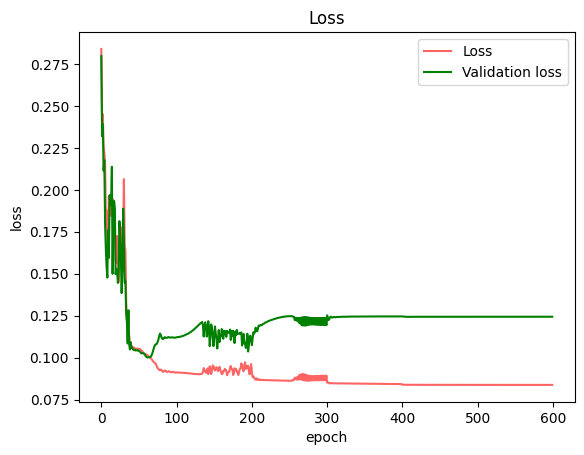

0.8876414735241043
lr: 0.15 0.15
50
step 100, accuracy_train:0.63125, loss: 0.1250806049800009
0.08979203496748185
lr: 0.15 0.15
100
0.24870038435803535
lr: 0.15 0.15
150
step 200, accuracy_train:0.80625, loss: 0.0552134499483134
0.19314998927876578
lr: 0.15 0.15
200
0.006700822862972482
accuracy of best loss : 0.81875
lr: 0.05 0.05
250
step 300, accuracy_train:0.86875, loss: 0.04608309975406144
0.24389526590245023
lr: 0.05 0.05
300
0.05328155068337216
lr: 0.05 0.05
350
step 400, accuracy_train:0.86875, loss: 0.04419778983604328
0.0014088613359255666
accuracy of best loss : 0.875
lr: 0.01 0.01
400
0.11065085014366027
lr: 0.01 0.01
450
step 500, accuracy_train:0.8875, loss: 0.03940759018087056
0.00785092408321334
accuracy of best loss : 0.8875
0.01
lr: 0.001 0.001
500
0.017648161000541743
lr: 0.001 0.001
550
step 600, accuracy_train:0.9, loss: 0.038737560254967565
0.0007301038073621453
accuracy of best loss : 0.9
0.01
lr: 0.0001 0.0001
600
lr: 0.0001 0.001
accuracy of best loss: 0.9 -50

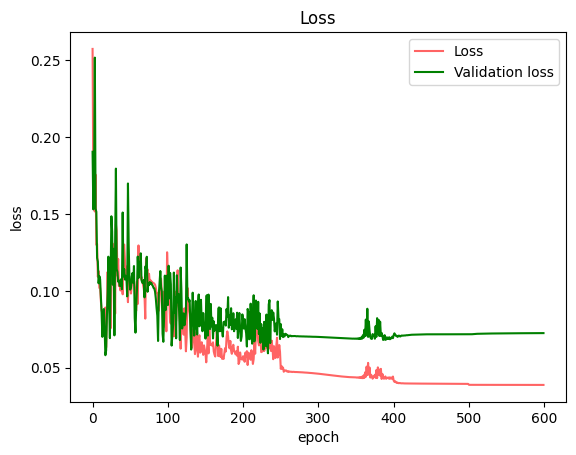

0.8527770008454916
lr: 0.15 0.15
50
step 100, accuracy_train:0.6, loss: 0.09392424657300483
0.3111556986767175
lr: 0.15 0.15
100
0.07209084682130866
lr: 0.15 0.15
150
step 200, accuracy_train:0.525, loss: 0.10162140338645959
0.03137101318887191
accuracy of best loss : 0.6125
lr: 0.05 0.05
200
0.09446532790677074
lr: 0.05 0.05
250
step 300, accuracy_train:0.65625, loss: 0.08181261240266954
0.010163528341051711
accuracy of best loss : 0.65625
lr: 0.01 0.01
300
0.10945807210731871
lr: 0.01 0.01
350
step 400, accuracy_train:0.7375, loss: 0.07523479275010317
0.022400479397162477
lr: 0.01 0.01
400
0.012557101808224535
lr: 0.01 0.01
450
step 500, accuracy_train:0.725, loss: 0.07412289668715288
0.0070737733376565306
accuracy of best loss : 0.725
0.01
lr: 0.001 0.001
500
0.010004233032813871
lr: 0.001 0.001
550
step 600, accuracy_train:0.725, loss: 0.07347322578812598
0.00037896697570401563
accuracy of best loss : 0.725
0.01
lr: 0.0001 0.0001
600
lr: 0.0001 0.001
accuracy of best loss: 0.725 -5

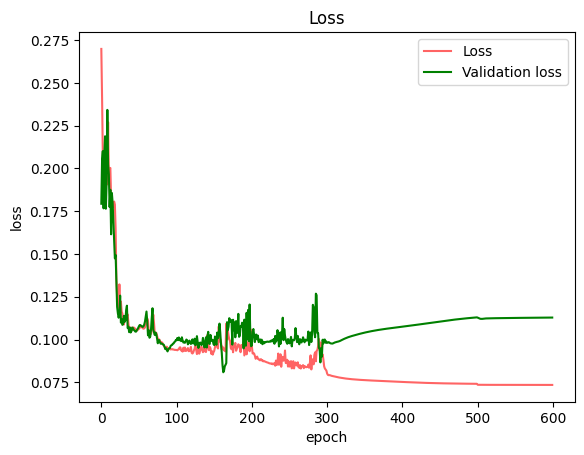

0.8048659691425917
lr: 0.15 0.15
50
step 100, accuracy_train:0.375, loss: 0.12630418532760063
0.12959531147272554
lr: 0.15 0.15
100
0.09605991994205454
lr: 0.15 0.15
150
step 200, accuracy_train:0.34375, loss: 0.15189819616950878
0.03257800463964033
accuracy of best loss : 0.3625
lr: 0.05 0.05
200
0.08099229990352058
lr: 0.05 0.05
250
step 300, accuracy_train:0.3625, loss: 0.12497822214387024
0.03919471673893611
lr: 0.05 0.05
300
0.015114835959985588
accuracy of best loss : 0.375
lr: 0.01 0.01
350
step 400, accuracy_train:0.36875, loss: 0.1105202595075183
0.08762165737439753
lr: 0.01 0.01
400
0.001997045054351685
accuracy of best loss : 0.36875
0.01
lr: 0.001 0.001
450
step 500, accuracy_train:0.36875, loss: 0.10828899618599333
0.10194715953473424
lr: 0.001 0.001
500
0.015263537682988677
lr: 0.001 0.001
550
step 600, accuracy_train:0.36875, loss: 0.10789159260502292
0.0013761899832098227
accuracy of best loss : 0.375
0.01
lr: 0.0001 0.0001
600
lr: 0.0001 0.001
accuracy of best loss: 0.

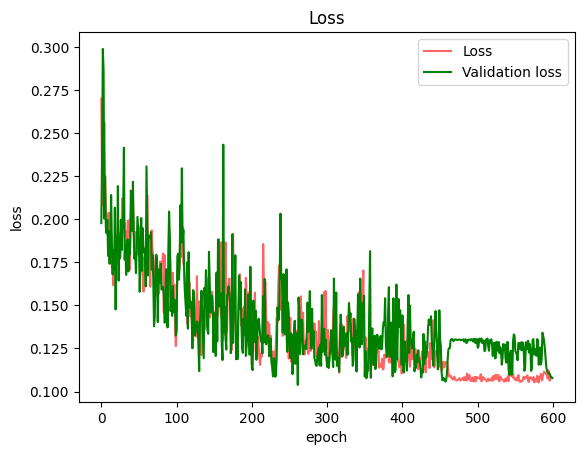

0.8366424459992753
lr: 0.15 0.15
50
step 100, accuracy_train:0.625, loss: 0.1065495336763792
0.35959553834929214
lr: 0.15 0.15
100
0.005248430325645813
accuracy of best loss : 0.625
lr: 0.05 0.05
150
step 200, accuracy_train:0.56875, loss: 0.10237615229872438
0.050871045316640995
lr: 0.05 0.05
200
0.0009894998204218926
accuracy of best loss : 0.65
lr: 0.01 0.01
250
step 300, accuracy_train:0.66875, loss: 0.0955809888430745
0.03858815075975237
lr: 0.01 0.01
300
0.0033748936823617738
accuracy of best loss : 0.66875
0.01
lr: 0.001 0.001
350
step 400, accuracy_train:0.66875, loss: 0.09533273087430243
0.002189828338627521
accuracy of best loss : 0.66875
0.01
lr: 0.0001 0.0001
400
0.00021505035627115626
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.66875, loss: 0.09531366428450556
4.42979548720595e-06
lr: 0.0001 0.0001
500
4.688904381042319e-06
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.66875, loss: 0.09531271466803846
4.986336228289486e-06
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001
ac

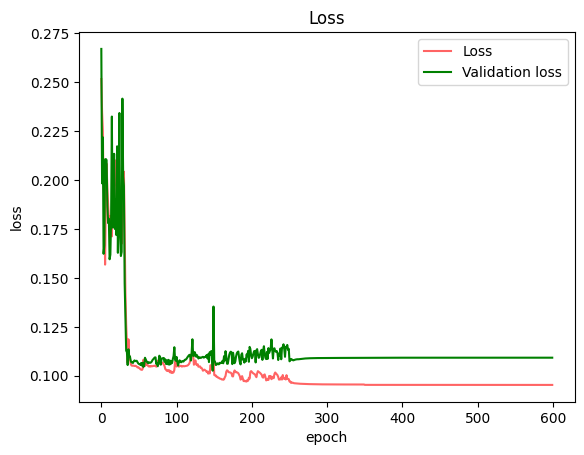

cv_time ：106.002823 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 50, 50, (0.05, 0.03, 0.01))
0.8820996103502852
lr: 0.15 0.15
50
step 100, accuracy_train:0.55625, loss: 0.17336672981264187
0.5893542265906518
lr: 0.15 0.15
100
0.19157135517853174
lr: 0.15 0.15
150
step 200, accuracy_train:0.6375, loss: 0.11786475705016089
0.07375639973774602
lr: 0.15 0.15
200
0.025431677156394928
accuracy of best loss : 0.63125
lr: 0.05 0.05
250
step 300, accuracy_train:0.61875, loss: 0.11364473756994722
0.06876452471227949
lr: 0.05 0.05
300
0.02593124333030634
accuracy of best loss : 0.6125
lr: 0.01 0.01
350
step 400, accuracy_train:0.63125, loss: 0.10481849846088903
0.12662423556170233
lr: 0.01 0.01
400
0.028454071612513784
lr: 0.01 0.01
450
step 500, accuracy_train:0.63125, loss: 0.10601925721271091
0.001992210168670563
accuracy of best loss : 0.63125
0.01
lr: 0.001 0.001
500
0.010949481895310566
lr: 0.001 0.001
550
step 600, accuracy_train:0.63125, loss: 0.10384033832186651
0.000377248323714141
accura

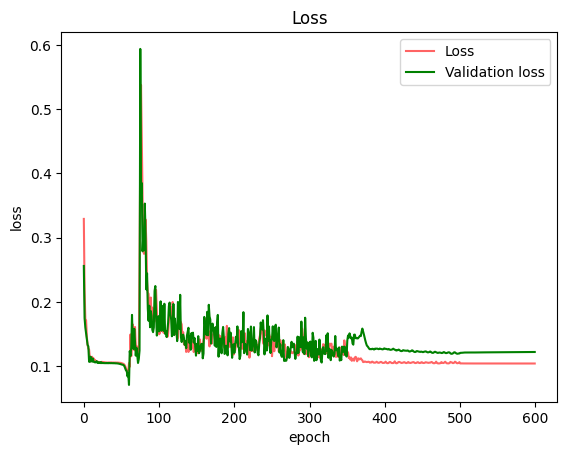

0.8809624297405082
lr: 0.15 0.15
50
step 100, accuracy_train:0.10625, loss: 0.057617723868512105
0.40006303820192446
lr: 0.15 0.15
100
0.12513103267210757
lr: 0.15 0.15
150
step 200, accuracy_train:0.075, loss: 0.052328104066901845
0.11759368690474771
lr: 0.15 0.15
200
0.07681264401711196
lr: 0.15 0.15
250
step 300, accuracy_train:0.1125, loss: 0.06330584308507403
0.028366427990143942
accuracy of best loss : 0.10625
lr: 0.05 0.05
300
0.21885922908343278
lr: 0.05 0.05
350
step 400, accuracy_train:0.06875, loss: 0.04391788690612425
0.00326935534340624
accuracy of best loss : 0.0625
lr: 0.01 0.01
400
0.0429106523725648
lr: 0.01 0.01
450
step 500, accuracy_train:0.06875, loss: 0.043180343142222195
0.0015046978254242202
accuracy of best loss : 0.06875
0.01
lr: 0.001 0.001
500
0.002437350758464264
accuracy of best loss : 0.06875
0.01
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.06875, loss: 0.04308417973050521
0.0002518527576221019
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001
accuracy of best

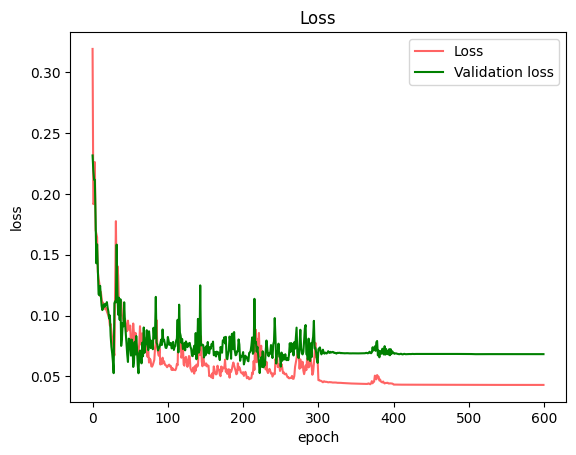

0.8171317422371414
lr: 0.15 0.15
50
step 100, accuracy_train:0.325, loss: 0.15862740781180704
0.10045004650352213
lr: 0.15 0.15
100
0.1539355034987917
lr: 0.15 0.15
150
step 200, accuracy_train:0.36875, loss: 0.11881631916789068
0.043380083435744975
accuracy of best loss : 0.36875
lr: 0.05 0.05
200
0.09273738713102657
lr: 0.05 0.05
250
step 300, accuracy_train:0.35625, loss: 0.12637711992712228
0.0011382908578421596
accuracy of best loss : 0.375
lr: 0.01 0.01
300
0.029465578348207396
lr: 0.01 0.01
350
step 400, accuracy_train:0.375, loss: 0.10946015002350037
0.03374360334960103
lr: 0.01 0.01
400
0.011428824595491712
lr: 0.01 0.01
450
step 500, accuracy_train:0.36875, loss: 0.11327752781488669
0.030651013887439314
lr: 0.01 0.01
500
0.038419044819419455
lr: 0.01 0.01
550
step 600, accuracy_train:0.375, loss: 0.10170415613537914
0.07720598412975649
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.375 -3
Epoch:  0 | Cost: 0.101827 | Train accuracy: 0.375000 | Test Accuracy: 0.37500

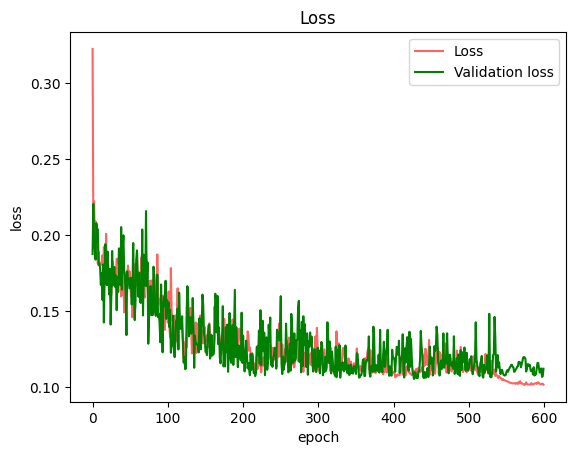

0.8403245393640654
lr: 0.15 0.15
50
step 100, accuracy_train:0.3, loss: 0.15313402912276303
0.14145903596518936
lr: 0.15 0.15
100
0.10758487288270371
lr: 0.15 0.15
150
step 200, accuracy_train:0.34375, loss: 0.14345762980785848
0.08620961752731791
lr: 0.15 0.15
200
0.018874087128384454
accuracy of best loss : 0.3625
lr: 0.05 0.05
250
step 300, accuracy_train:0.35, loss: 0.13365565257925943
0.046010979889844955
lr: 0.05 0.05
300
0.0562392733113509
lr: 0.05 0.05
350
step 400, accuracy_train:0.325, loss: 0.15342782606142286
0.03910009834017673
lr: 0.05 0.05
400
0.005514366791588062
accuracy of best loss : 0.36875
lr: 0.01 0.01
450
step 500, accuracy_train:0.34375, loss: 0.13347461914184736
0.05585931813148879
lr: 0.01 0.01
500
0.026036354226143508
lr: 0.01 0.01
550
step 600, accuracy_train:0.3625, loss: 0.11974302180134375
0.04827053605691343
lr: 0.01 0.01
600
lr: 0.01 0.01
accuracy of best loss: 0.35625 -9
Epoch:  0 | Cost: 0.135972 | Train accuracy: 0.350000 | Test Accuracy: 0.350000
(n

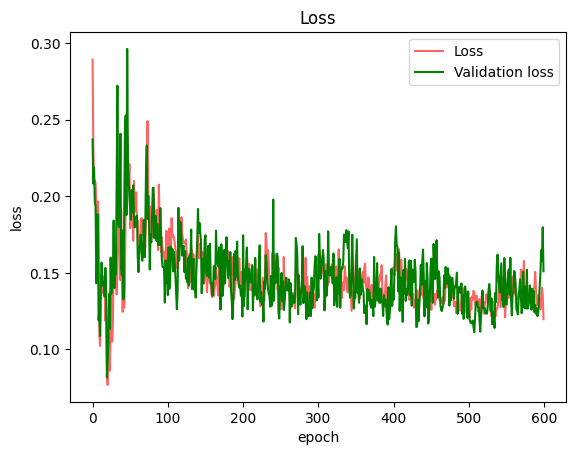

0.823090902751395
lr: 0.15 0.15
50
step 100, accuracy_train:0.33125, loss: 0.15068500886585723
0.20568251694385475
lr: 0.15 0.15
100
0.039660363297670434
accuracy of best loss : 0.35625
lr: 0.05 0.05
150
step 200, accuracy_train:0.3375, loss: 0.1402886023254409
0.031849611657306424
lr: 0.05 0.05
200
0.032228038027125865
lr: 0.05 0.05
250
step 300, accuracy_train:0.3625, loss: 0.13150739528548946
0.019501892974843865
accuracy of best loss : 0.36875
lr: 0.01 0.01
300
0.1595300091981233
lr: 0.01 0.01
350
step 400, accuracy_train:0.38125, loss: 0.10343142089730899
0.04289650104246075
lr: 0.01 0.01
400
0.039138716779402775
lr: 0.01 0.01
450
step 500, accuracy_train:0.38125, loss: 0.1037070133848859
0.0016311040903061592
accuracy of best loss : 0.375
0.01
lr: 0.001 0.001
500
0.010978950367567892
lr: 0.001 0.001
550
step 600, accuracy_train:0.375, loss: 0.10268072992201707
0.0007475896071790539
accuracy of best loss : 0.375
0.01
lr: 0.0001 0.0001
600
lr: 0.0001 0.001
accuracy of best loss: 0.

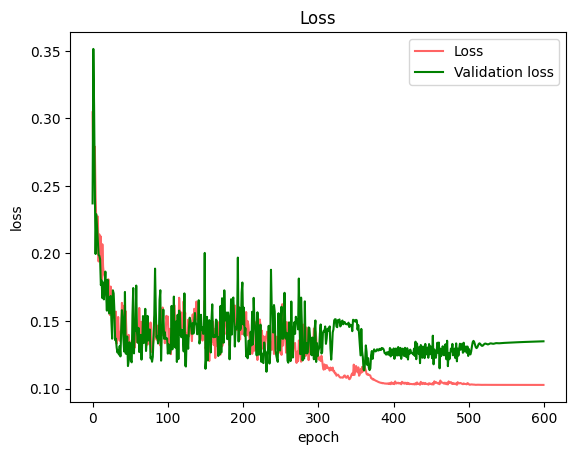

cv_time ：95.876953 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 100, 50, (0.05, 0.03, 0.01))
0.8882044657585428
lr: 0.15 0.15
50
step 100, accuracy_train:0.13125, loss: 0.022345631467285583
0.7537736142710805
lr: 0.15 0.15
100
0.24088662980509784
lr: 0.15 0.15
150
step 200, accuracy_train:0.0, loss: 0.01900025601871859
0.015938749985488335
accuracy of best loss : 0.0
lr: 0.05 0.05
200
0.10867939849574554
lr: 0.05 0.05
250
step 300, accuracy_train:0.0, loss: 0.018761982458474564
0.005628235229844581
accuracy of best loss : 0.0
lr: 0.01 0.01
300
0.0034622229142056518
accuracy of best loss : 0.0
0.01
lr: 0.001 0.001
350
step 400, accuracy_train:0.0, loss: 0.01873576549809004
0.0007085945992163899
accuracy of best loss : 0.0
0.01
lr: 0.0001 0.0001
400
7.741595987406694e-05
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.0, loss: 0.01873518000623121
1.5784639030046066e-05
lr: 0.0001 0.0001
500
1.6867673949851567e-05
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.0, loss: 0.0187345083546640

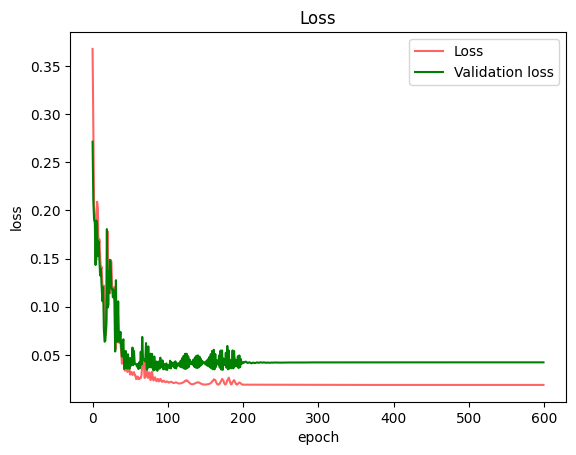

0.8977301009929485
lr: 0.15 0.15
50
step 100, accuracy_train:0.9125, loss: 0.03595869229897208
0.616161623294573
lr: 0.15 0.15
100
0.126655685530276
lr: 0.15 0.15
150
step 200, accuracy_train:0.925, loss: 0.032294237777208565
0.043370603338470204
accuracy of best loss : 0.925
lr: 0.05 0.05
200
0.022883696117426435
accuracy of best loss : 0.91875
lr: 0.01 0.01
250
step 300, accuracy_train:0.91875, loss: 0.03168228900412034
0.009678529212768695
accuracy of best loss : 0.91875
0.01
lr: 0.001 0.001
300
0.0018590045189456248
accuracy of best loss : 0.91875
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.91875, loss: 0.03166970708831261
0.00020074601395915194
lr: 0.0001 0.0001
400
4.123498824648042e-05
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.91875, loss: 0.03166690324566792
4.430355924011766e-05
lr: 0.0001 0.0001
500
4.730864194278188e-05
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.91875, loss: 0.03166372175392978
5.0267097508040804e-05
lr: 0.0001 0.0001
600
lr: 0.0001 0.

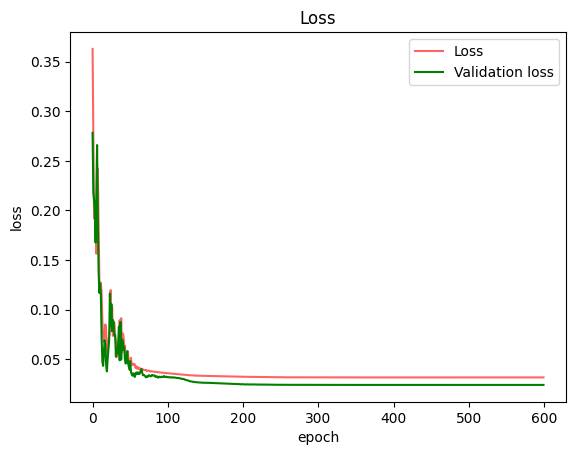

0.7967316792091501
lr: 0.15 0.15
50
step 100, accuracy_train:0.2625, loss: 0.17080348524608535
0.13994484748230063
lr: 0.15 0.15
100
0.005091995360515216
accuracy of best loss : 0.3125
lr: 0.05 0.05
150
step 200, accuracy_train:0.26875, loss: 0.1629134714075558
0.07256963935514768
lr: 0.05 0.05
200
0.009829029144695496
accuracy of best loss : 0.3125
lr: 0.01 0.01
250
step 300, accuracy_train:0.35625, loss: 0.1254585160240144
0.18620642646056826
lr: 0.01 0.01
300
0.06719309893777216
lr: 0.01 0.01
350
step 400, accuracy_train:0.35625, loss: 0.12403191449040084
0.0027221233535274186
accuracy of best loss : 0.35625
0.01
lr: 0.001 0.001
400
0.004670200119269184
accuracy of best loss : 0.3625
0.01
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.3625, loss: 0.12398790627927268
8.831290874641947e-05
lr: 0.0001 0.0001
500
1.1903083434363655e-05
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.3625, loss: 0.12398479768460079
1.2542546893218665e-05
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001
accurac

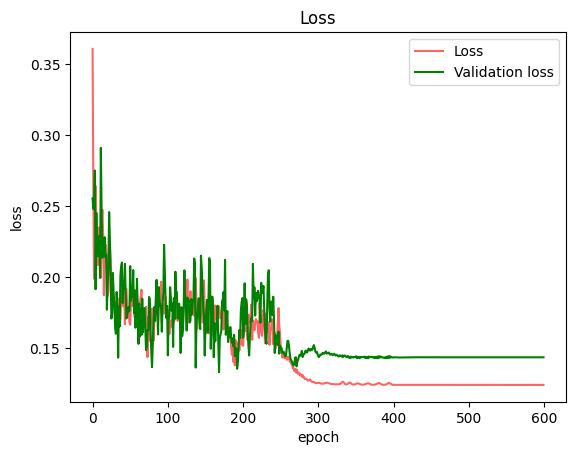

0.8192684369499426
lr: 0.15 0.15
50
step 100, accuracy_train:0.375, loss: 0.1097329455744788
0.41403201726339195
lr: 0.15 0.15
100
0.1365376630341259
lr: 0.15 0.15
150
step 200, accuracy_train:0.79375, loss: 0.058555731457645255
0.26415477084066546
lr: 0.15 0.15
200
0.13714709369467648
lr: 0.15 0.15
250
step 300, accuracy_train:0.90625, loss: 0.04149116918422666
0.2632320903389218
lr: 0.15 0.15
300
0.06922450491346174
lr: 0.15 0.15
350
step 400, accuracy_train:0.90625, loss: 0.036693175892465735
0.06472144930349756
lr: 0.15 0.15
400
0.023322525455028012
accuracy of best loss : 0.90625
lr: 0.05 0.05
450
step 500, accuracy_train:0.9125, loss: 0.0357935165062415
0.011460299252313913
accuracy of best loss : 0.9125
lr: 0.01 0.01
500
0.005554854114957627
accuracy of best loss : 0.9125
0.01
lr: 0.001 0.001
550
step 600, accuracy_train:0.9125, loss: 0.03570110455802172
0.0013280246890471853
accuracy of best loss : 0.9125
0.01
lr: 0.0001 0.0001
600
lr: 0.0001 0.001
accuracy of best loss: 0.9125

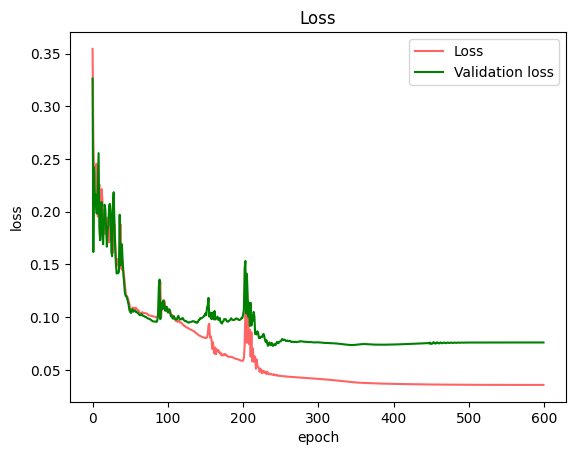

0.789509570407077
lr: 0.15 0.15
50
step 100, accuracy_train:0.325, loss: 0.15714037652434373
0.2152914022064928
lr: 0.15 0.15
100
0.012640313420555972
accuracy of best loss : 0.35
lr: 0.05 0.05
150
step 200, accuracy_train:0.36875, loss: 0.11838638105367533
0.1974908596254513
lr: 0.05 0.05
200
0.10365756542910814
lr: 0.05 0.05
250
step 300, accuracy_train:0.375, loss: 0.11354759621411713
0.022119172841215607
accuracy of best loss : 0.38125
lr: 0.01 0.01
300
0.029628273087306103
lr: 0.01 0.01
350
step 400, accuracy_train:0.38125, loss: 0.11097428974056206
0.00276303271241374
accuracy of best loss : 0.38125
0.01
lr: 0.001 0.001
400
0.00034688704014154096
accuracy of best loss : 0.38125
0.01
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.38125, loss: 0.11096842475842456
2.6185006596763233e-05
lr: 0.0001 0.0001
500
5.106059229735882e-06
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.38125, loss: 0.11096722949846845
5.389171042919034e-06
lr: 0.0001 0.0001
600
lr: 0.0001 0.0001
accuracy 

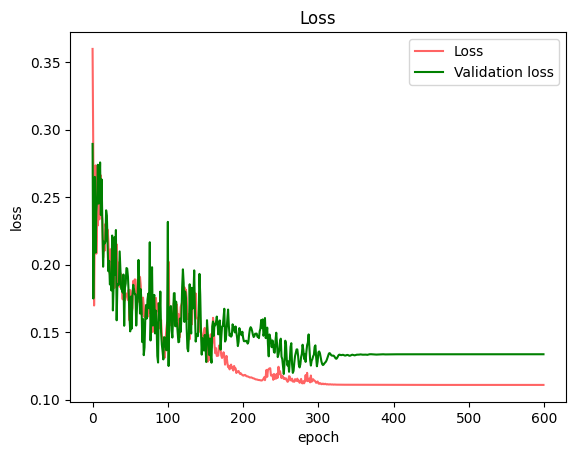

cv_time ：53.099087 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 300, 50, (0.05, 0.03, 0.01))


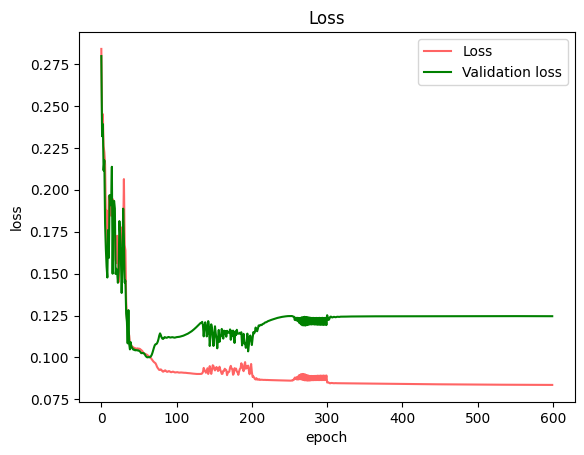

In [16]:
# Grid search of hyper-parameters
best_h_pm, h_pm_rsts =[], []
cv_start = time.process_time()
configs['noise'] = training_noise
for setting in settings:
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
    X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim,**configs)
    
    h_pm_rst=[]
    loss_history_cvs=[]
    configs['qc'] = qcircuit(*setting, **configs)
    
    for h_pm in h_pms:
        learning_rate,max_epoch,batch_size,dynamic_size,threshold = h_pm
        configs['_h_pm'] = tuple(h_pm)
        
        seed_rsts, seed_params = [], []
        loss_history, valid_loss_history = [], []
        accuracy_history = []
        h_pm_rst.append(n_cv(num_cvs, X_train, y_train,setting, **configs))
        print(h_pm)

        
    h_pm_i = np.argmax(h_pm_rst,axis=0)[0]
    best_h_pm.append(h_pm_i)
    h_pm_rsts.append(h_pm_rst)
    l_h_best, val_l_h_best = loss_history_cvs[h_pm_i]
    plot_loss_history(l_h_best, val_l_h_best, setting=setting, fig_name=f'{setting}_loss_best_h_pms')
t_cvs = time.process_time()-cv_start

In [17]:
def run(seed_num, x_tr, y_tr, *args, x_te=None, y_te=None, ratio_tr=0.875, **kwargs):
    #if:   x_te=None & y_te=None -> choosing random seed with validation accuracy
    #else: train and test
    global loss_history, valid_loss_history, lr    
    # print('run args', args)
    # configs['qc'] = qcircuit(*args, **configs)
    
    if x_te is None and y_te is None:
        from sklearn.utils import shuffle
        from sklearn.model_selection import train_test_split
        xs_tr, xs_val, ys_tr, ys_val = train_test_split(
            x_tr,y_tr,train_size=ratio_tr,random_state=seed_num,stratify=y_tr)
        # xs = shuffle(x_tr, random_state=seed_num, n_samples=None)
        # ys = shuffle(y_tr, random_state=seed_num, n_samples=None)
        # num_seed_train = int(num_training*ratio_tr)
        # num_seed_valid = num_training-num_seed_train
        # xs_tr = xs[:num_seed_train] 
        # ys_tr = ys[:num_seed_train]
        # xs_val = xs[num_seed_train:] 
        # ys_val = ys[num_seed_train:] 
    else:
        xs_tr, ys_tr, xs_val, ys_val = x_tr, y_tr, x_te, y_te

    params = initialize_params(enc_dim, num_qubits, num_layers, num_reupload, num_rot, kwargs['num_class_1q'], seed_num)
    optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=lr)
    opt_state = optimizer.init(params)
    if x_te is None and y_te is None: # optimized by validation data but not peeking in true test data
        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, xs_tr, ys_tr,x_valid=xs_val,y_valid=ys_val, *args, **kwargs)  
    else: 
        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, xs_tr, ys_tr, *args, **configs)
    accuracy_train, loss, accuracy_valid, loss_test = scores(params, xs_tr, ys_tr, x_te=xs_val, y_te=ys_val, *args, **kwargs)
    plot_loss_history(loss_history, valid_loss_history, setting=args, fig_name=None)
    
    if x_te is None and y_te is None:
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Validation Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_valid))
    else:
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_valid))
    print(f"(n_dim, n_q, n_f, n_r, n_rot) = {enc_dim, num_qubits, num_layers, num_reupload, num_rot}")
    
    return params, [seed_num, accuracy_train, accuracy_valid, loss, num_epoch]

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.5378339654842956
lr: 0.15 0.0001
50
step 100, accuracy_train:0.4, loss: 0.4535829858269114
0.012479577271746829
accuracy of best loss : 0.4
lr: 0.05 0.05
100
0.6430399281462337
lr: 0.05 0.05
150
step 200, accuracy_train:0.7142857142857143, loss: 0.10802089280127516
0.3353791609318665
lr: 0.05 0.05
200
0.0025317191841068877
accuracy of best loss : 0.7142857142857143
lr: 0.01 0.01
250
step 300, accuracy_train:0.7142857142857143, loss: 0.10799975972758988
3.165894902997631e-05
accuracy of best loss : 0.7142857142857143
0.01
lr: 0.001 0.001
300
6.323905794608305e-07
accuracy of best loss : 0.7142857142857143
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.7142857142857143, loss: 0.10799975245142304
3.328603356383536e-08
lr: 0.0001 0.0001
400
6.517560938000744e-09
lr: 0.0001 0.0001
450
step 500, accuracy_train

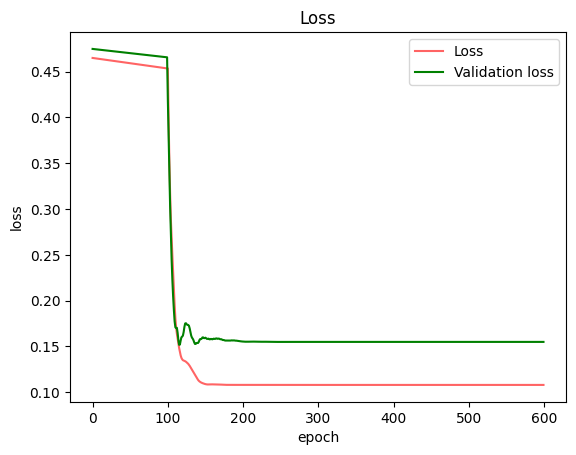

Epoch:  0 | Cost: 0.108000 | Train accuracy: 0.714286 | Validation Accuracy: 0.640000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 2)
0.5639467405902672
lr: 0.15 0.0001
50
step 100, accuracy_train:0.06857142857142857, loss: 0.4239563672433222
0.01837349303356648
accuracy of best loss : 0.06857142857142857
lr: 0.05 0.05
100
0.6293467189460316
lr: 0.05 0.05
150
step 200, accuracy_train:0.8571428571428571, loss: 0.06662038212237299
0.5604789497431283
lr: 0.05 0.05
200
0.07606641727057817
lr: 0.05 0.05
250
step 300, accuracy_train:0.8628571428571429, loss: 0.058866647598876005
0.05382144284378762
lr: 0.05 0.05
300
0.09151672188254537
lr: 0.05 0.05
350
step 400, accuracy_train:0.8742857142857143, loss: 0.05343720430744014
0.034597170801171175
lr: 0.05 0.05
400
0.0005320635538387589
accuracy of best loss : 0.8742857142857143
lr: 0.01 0.01
450
step 500, accuracy_train:0.8742857142857143, loss: 0.05343689872981354
7.306282835749276e-07
accuracy of best loss : 0.8742857142857143
0.01
lr: 0.001 

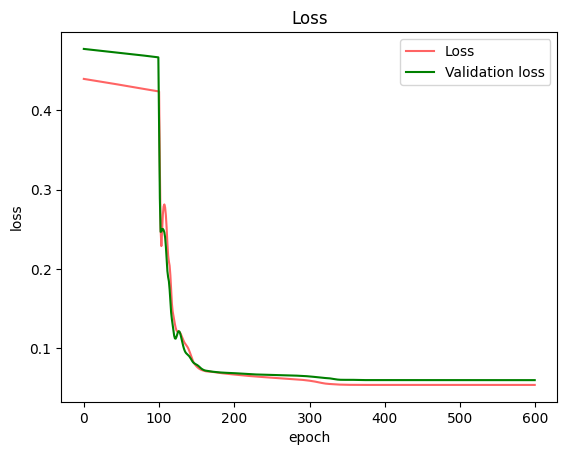

Epoch:  0 | Cost: 0.053437 | Train accuracy: 0.874286 | Validation Accuracy: 0.880000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 2)
0.6222582338468845
lr: 0.15 0.0001
50
step 100, accuracy_train:0.09714285714285714, loss: 0.36950873632530357
0.014450253725695899
accuracy of best loss : 0.09714285714285714
lr: 0.05 0.05
100
0.68451517263659
lr: 0.05 0.05
150
step 200, accuracy_train:0.8628571428571429, loss: 0.057587011373885236
0.4801161778862558
lr: 0.05 0.05
200
0.06791542778604179
lr: 0.05 0.05
250
step 300, accuracy_train:0.8742857142857143, loss: 0.05674617609322638
0.0028606995432759923
accuracy of best loss : 0.8742857142857143
lr: 0.01 0.01
300
7.770277326248056e-05
accuracy of best loss : 0.8742857142857143
0.01
lr: 0.001 0.001
350
step 400, accuracy_train:0.8742857142857143, loss: 0.05674596851066119
1.5754464194629204e-06
accuracy of best loss : 0.8742857142857143
0.01
lr: 0.0001 0.0001
400
1.1855720581426353e-07
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.87428571428

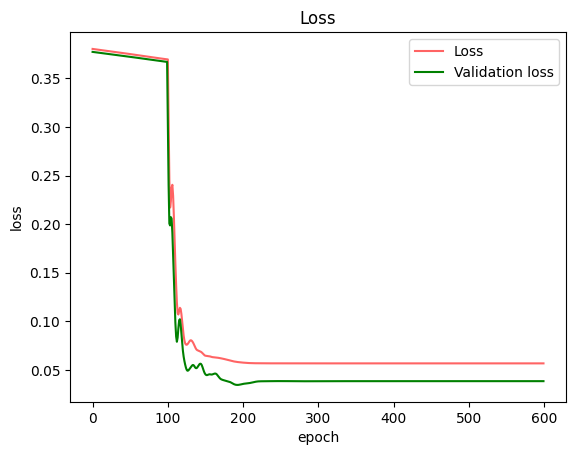

Epoch:  0 | Cost: 0.056746 | Train accuracy: 0.874286 | Validation Accuracy: 1.000000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 2)
0.686516140052023
lr: 0.15 0.0001
50
step 100, accuracy_train:0.37714285714285717, loss: 0.3055427458098292
0.017361020059443007
accuracy of best loss : 0.37714285714285717
lr: 0.05 0.05
100
0.4826287380827485
lr: 0.05 0.05
150
step 200, accuracy_train:0.6628571428571428, loss: 0.11183563611956401
0.2583515897453129
lr: 0.05 0.05
200
0.058196313917986936
lr: 0.05 0.05
250
step 300, accuracy_train:0.6857142857142857, loss: 0.11004433857016384
0.011247948276192266
accuracy of best loss : 0.6857142857142857
lr: 0.01 0.01
300
0.00021007261419137542
accuracy of best loss : 0.6857142857142857
0.01
lr: 0.001 0.001
350
step 400, accuracy_train:0.6857142857142857, loss: 0.1100438100178107
1.0542562390940804e-06
accuracy of best loss : 0.6857142857142857
0.01
lr: 0.0001 0.0001
400
2.4401257242232167e-08
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.685714285714

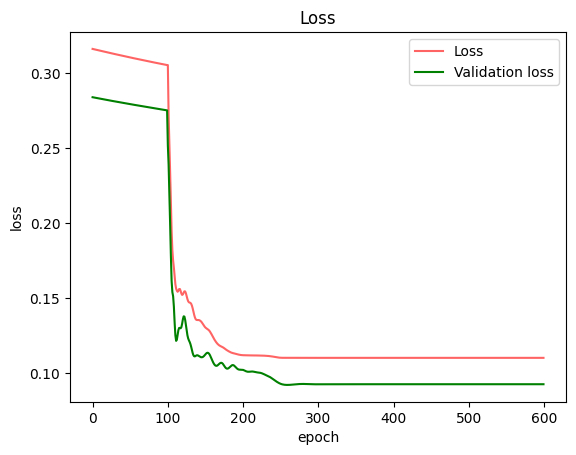

Epoch:  0 | Cost: 0.110044 | Train accuracy: 0.685714 | Validation Accuracy: 0.760000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 2)
0.7575612806935155
lr: 0.15 0.0001
50
step 100, accuracy_train:0.32571428571428573, loss: 0.23446212619196594
0.02221274394251237
accuracy of best loss : 0.32571428571428573
lr: 0.05 0.05
100
0.5109892605293195
lr: 0.05 0.05
150
step 200, accuracy_train:0.3028571428571429, loss: 0.06404052502999205
0.4343954042089067
lr: 0.05 0.05
200
0.02521268441347751
accuracy of best loss : 0.3028571428571429
lr: 0.01 0.01
250
step 300, accuracy_train:0.3028571428571429, loss: 0.06381511434439036
0.0013724085783039814
accuracy of best loss : 0.3028571428571429
0.01
lr: 0.001 0.001
300
0.000171051106699992
accuracy of best loss : 0.3028571428571429
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.3028571428571429, loss: 0.0638128987237797
1.750689169104352e-05
lr: 0.0001 0.0001
400
3.575593570962216e-06
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.30285714285

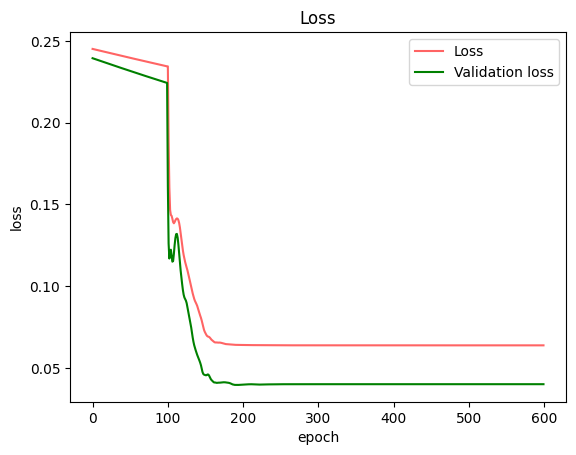

Epoch:  0 | Cost: 0.063813 | Train accuracy: 0.302857 | Validation Accuracy: 0.360000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 2)
0.7510571224338439
lr: 0.15 0.0001
50
step 100, accuracy_train:0.3028571428571429, loss: 0.2435899623675713
0.014421156016850371
accuracy of best loss : 0.3028571428571429
lr: 0.05 0.05
100
0.6159596349499281
lr: 0.05 0.05
150
step 200, accuracy_train:0.8457142857142858, loss: 0.0654292742746894
0.30155764445076333
lr: 0.05 0.05
200
0.008086971489105707
accuracy of best loss : 0.8457142857142858
lr: 0.01 0.01
250
step 300, accuracy_train:0.8457142857142858, loss: 0.06502619245142922
0.003176156323784062
accuracy of best loss : 0.8457142857142858
0.01
lr: 0.001 0.001
300
0.0007730648468715621
accuracy of best loss : 0.8457142857142858
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.8457142857142858, loss: 0.0650148148488084
8.871327831112156e-05
lr: 0.0001 0.0001
400
1.8361413922829706e-05
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.84571428571

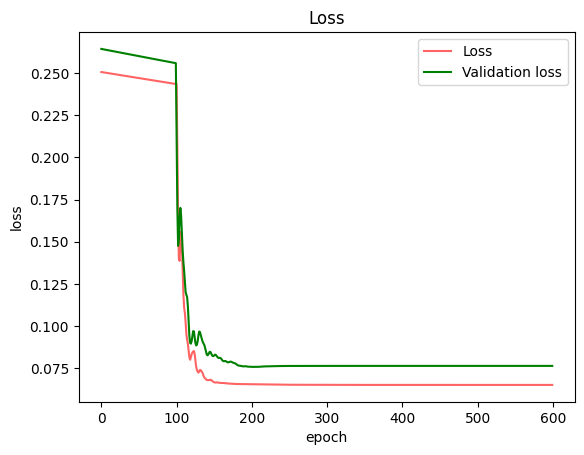

Epoch:  0 | Cost: 0.065016 | Train accuracy: 0.845714 | Validation Accuracy: 0.800000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 2)
0.6881378557926744
lr: 0.15 0.0001
50
step 100, accuracy_train:0.2057142857142857, loss: 0.3039744779772897
0.01690693885675982
accuracy of best loss : 0.2057142857142857
lr: 0.05 0.05
100
0.6861601164853427
lr: 0.05 0.05
150
step 200, accuracy_train:0.6571428571428571, loss: 0.054344273287697
0.4317888841801074
lr: 0.05 0.05
200
0.006875896709231175
accuracy of best loss : 0.6342857142857142
lr: 0.01 0.01
250
step 300, accuracy_train:0.6342857142857142, loss: 0.0542675514256405
0.0005107528378973452
accuracy of best loss : 0.6342857142857142
0.01
lr: 0.001 0.001
300
4.1687603161544205e-05
accuracy of best loss : 0.6342857142857142
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.6342857142857142, loss: 0.05426712508991926
3.946431294169832e-06
lr: 0.0001 0.0001
400
7.988141639234753e-07
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.6342857142857

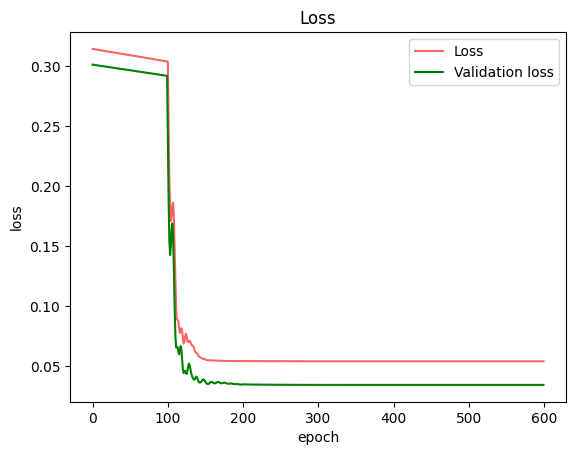

Epoch:  0 | Cost: 0.054267 | Train accuracy: 0.634286 | Validation Accuracy: 0.720000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 2)
0.6939287603864572
lr: 0.15 0.0001
50
step 100, accuracy_train:0.5314285714285715, loss: 0.2967199029477714
0.020826874421253926
accuracy of best loss : 0.5314285714285715
lr: 0.05 0.05
100
0.5500190864790303
lr: 0.05 0.05
150
step 200, accuracy_train:0.8628571428571429, loss: 0.0629386994233783
0.5270740689279317
lr: 0.05 0.05
200
0.017254481252090455
accuracy of best loss : 0.8685714285714285
lr: 0.01 0.01
250
step 300, accuracy_train:0.8685714285714285, loss: 0.062280408051241055
0.005190167961921781
accuracy of best loss : 0.8685714285714285
0.01
lr: 0.001 0.001
300
0.0012772467929053845
accuracy of best loss : 0.8742857142857143
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.8742857142857143, loss: 0.06226221990989529
0.0001481585972181315
lr: 0.0001 0.0001
400
3.070744536572454e-05
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.87428571428

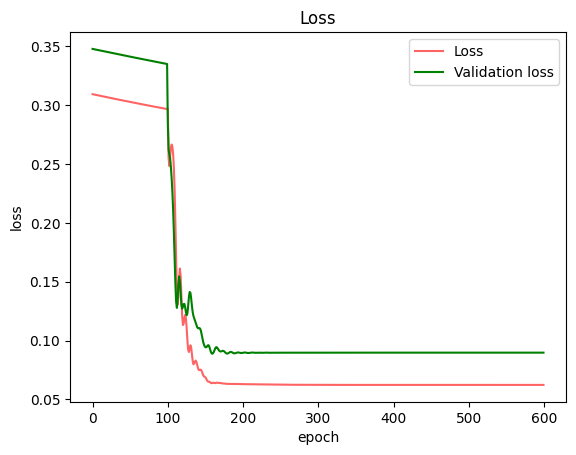

Epoch:  0 | Cost: 0.062262 | Train accuracy: 0.874286 | Validation Accuracy: 0.760000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 2)
0.6193390281346554
lr: 0.15 0.0001
50
step 100, accuracy_train:0.2914285714285714, loss: 0.37026042574619605
0.01832830327135208
accuracy of best loss : 0.2914285714285714
lr: 0.05 0.05
100
0.685351072284868
lr: 0.05 0.05
150
step 200, accuracy_train:0.88, loss: 0.06178478629855036
0.4673988006743639
lr: 0.05 0.05
200
0.02030447491112173
accuracy of best loss : 0.8742857142857143
lr: 0.01 0.01
250
step 300, accuracy_train:0.88, loss: 0.06053044086519062
0.010749373215991287
lr: 0.01 0.01
300
0.006001787153105311
accuracy of best loss : 0.88
0.01
lr: 0.001 0.001
350
step 400, accuracy_train:0.88, loss: 0.06006252096086307
0.003967699840406175
accuracy of best loss : 0.88
0.01
lr: 0.0001 0.0001
400
0.0004736140280260429
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.88, loss: 0.06005091643932308
9.760212148103825e-05
lr: 0.0001 0.0001
500
0.0001044467674

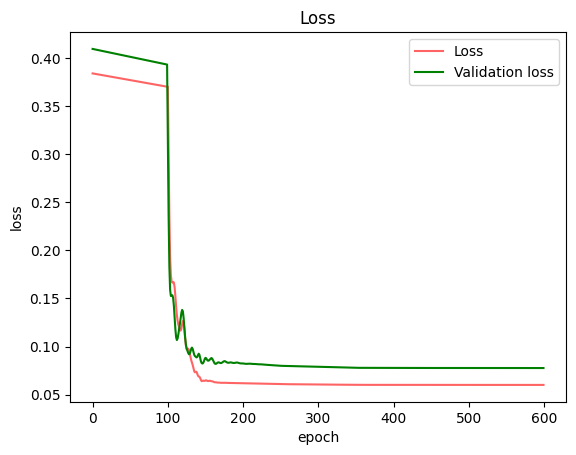

Epoch:  0 | Cost: 0.060038 | Train accuracy: 0.880000 | Validation Accuracy: 0.800000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 2)
0.5925080101312408
lr: 0.15 0.0001
50
step 100, accuracy_train:0.44571428571428573, loss: 0.400438479637127
0.011653399753549343
accuracy of best loss : 0.44571428571428573
lr: 0.05 0.05
100
0.6236958283614683
lr: 0.05 0.05
150
step 200, accuracy_train:0.6857142857142857, loss: 0.1056064828769267
0.301109830221815
lr: 0.05 0.05
200
0.0030064792781469086
accuracy of best loss : 0.6857142857142857
lr: 0.01 0.01
250
step 300, accuracy_train:0.6857142857142857, loss: 0.10559971190496685
1.3603096502460384e-05
accuracy of best loss : 0.6857142857142857
0.01
lr: 0.001 0.001
300
1.9680452638143197e-08
accuracy of best loss : 0.6857142857142857
0.01
lr: 0.0001 0.0001
350
step 400, accuracy_train:0.6857142857142857, loss: 0.10559971186247427
1.6548058635281835e-10
lr: 0.0001 0.0001
400
2.351884053509799e-11
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.6857142

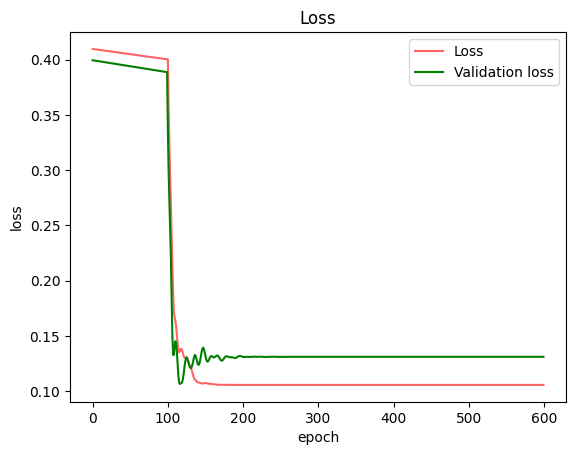

Epoch:  0 | Cost: 0.105600 | Train accuracy: 0.685714 | Validation Accuracy: 0.600000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 2)
t_n_seeds: 53.15475859999992


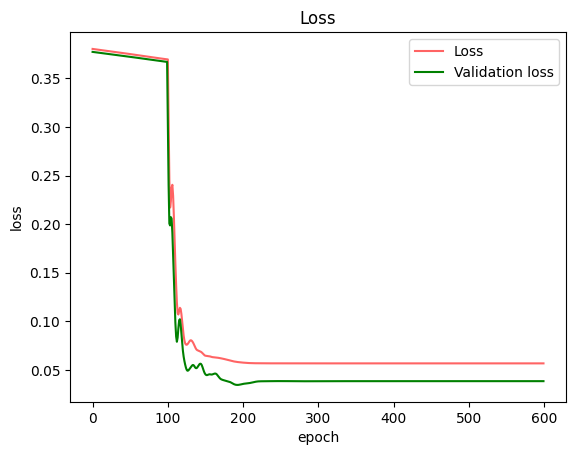

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.6226148238041163
lr: 0.15 0.0001
50
step 100, accuracy_train:0.105, loss: 0.3692112285136371
0.014368333835212667
accuracy of best loss : 0.105
lr: 0.05 0.05
100
0.6934488885044202
lr: 0.05 0.05
150
step 200, accuracy_train:0.875, loss: 0.054280655318315905
0.5017004697131465
lr: 0.05 0.05
200
0.04772666423678205
lr: 0.05 0.05
250
step 300, accuracy_train:0.87, loss: 0.054062663231984276
0.0008177162652572161
accuracy of best loss : 0.87
lr: 0.01 0.01
300
4.10449943958562e-06
accuracy of best loss : 0.87
0.01
lr: 0.001 0.001
350
step 400, accuracy_train:0.87, loss: 0.05406266103540066
1.325228097411762e-08
accuracy of best loss : 0.87
0.01
lr: 0.0001 0.0001
400
3.2894385548325485e-10
lr: 0.0001 0.0001
450
step 500, accuracy_train:0.87, loss: 0.05406266102913345
5.850691058218859e-11
lr: 0.0001 0.0001
500
6.085005176095514e-11
lr: 0.0001 0.0001
550
step 600, accuracy_train:0.87, loss: 0.05406266102

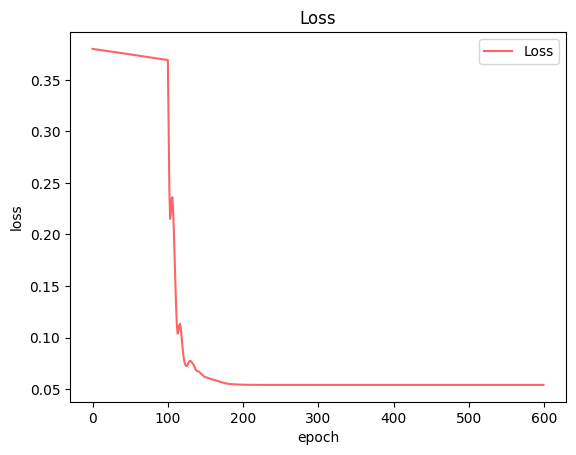

Epoch:  0 | Cost: 0.054063 | Train accuracy: 0.870000 | Test Accuracy: 0.760000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 2)


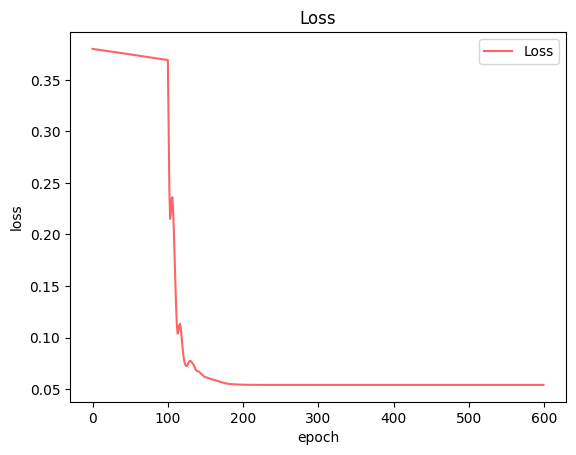

enc_circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
enc_circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.4994651550934641
lr: 0.15 0.0001
50
step 100, accuracy_train:0.35428571428571426, loss: 0.4877322800511448
0.017197471666322843
accuracy of best loss : 0.35428571428571426
lr: 0.05 0.05
100
0.6427419989791205
lr: 0.05 0.05
150
step 200, accuracy_train:0.8228571428571428, loss: 0.05551177123003214
0.6520544124501032
lr: 0.05 0.05
200
0.10014190227879376
lr: 0.05 0.05
250
step 300, accuracy_train:0.8228571428571428, loss: 0.05455989213549919
0.006678765573660101
accuracy of best loss : 0.8228571428571428
lr: 0.01 0.01
300
0.002121348296509048
lr: 0.01 0.01
350
step 400, accuracy_train:0.8228571428571428, loss: 0.054487844971850066
0.0006660040131638001
lr: 0.01 0.01
400
0.0007000519357224915
lr: 0.01 0.01
450
step 500, accuracy_train:0.8228571428571428, loss: 0.05440730

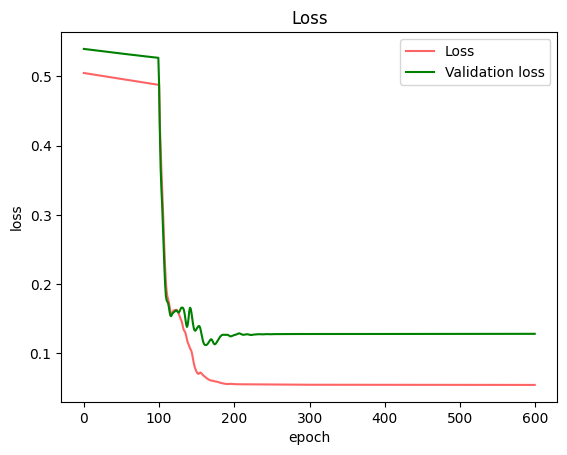

Epoch:  0 | Cost: 0.054362 | Train accuracy: 0.822857 | Validation Accuracy: 0.560000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 2, 1, 2)
0.7244556068618454
lr: 0.15 0.01
50
step 100, accuracy_train:0.48, loss: 0.1736194181533695
0.2886635705152962
lr: 0.15 0.01
100
0.16782684627711275
lr: 0.15 0.01
150
step 200, accuracy_train:0.38857142857142857, loss: 0.14354470643161985
0.09721536590042663
lr: 0.15 0.01
200
0.03033868974764363
accuracy of best loss : 0.36
lr: 0.05 0.05
250
step 300, accuracy_train:0.36, loss: 0.13807346488752203
0.00857869613123846
accuracy of best loss : 0.38285714285714284
lr: 0.01 0.01
300
0.05249967341220439
lr: 0.01 0.01
350
step 400, accuracy_train:0.41714285714285715, loss: 0.13429033496850148
0.010933265667691677
lr: 0.01 0.01
400
0.010003995384253254
lr: 0.01 0.01
450
step 500, accuracy_train:0.5028571428571429, loss: 0.13147408388081094
0.010435059846964679
lr: 0.01 0.01
500
0.012485372299278952
lr: 0.01 0.01
550
step 600, accuracy_train:0.5257142857142857, l

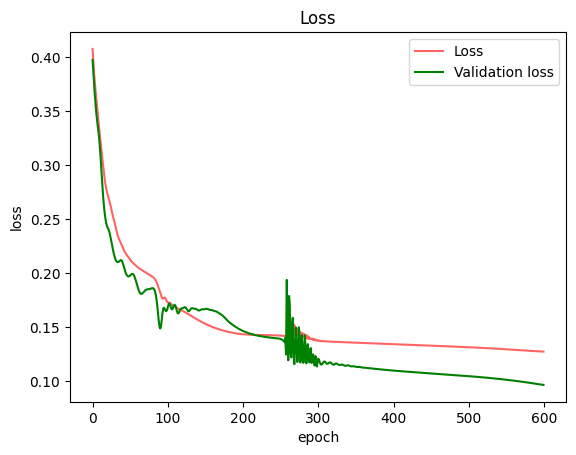

Epoch:  0 | Cost: 0.127427 | Train accuracy: 0.525714 | Validation Accuracy: 0.640000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 2, 1, 2)
0.713183256366875
lr: 0.15 0.01
50
step 100, accuracy_train:0.4114285714285714, loss: 0.14440633267716388
0.4582536194546308
lr: 0.15 0.01
100
0.07856044566576842
lr: 0.15 0.01
150
step 200, accuracy_train:0.4114285714285714, loss: 0.14247315176263042
0.004135404964412326
accuracy of best loss : 0.4114285714285714
lr: 0.05 0.05
200
0.02071374575921015
accuracy of best loss : 0.36
lr: 0.01 0.01
250
step 300, accuracy_train:0.36, loss: 0.12998872942422462
0.0619062523564716
lr: 0.01 0.01
300
0.01797200907357317
lr: 0.01 0.01
350
step 400, accuracy_train:0.37142857142857144, loss: 0.12370246190191837
0.02535264594297997
lr: 0.01 0.01
400
0.021295445326002
lr: 0.01 0.01
450
step 500, accuracy_train:0.4742857142857143, loss: 0.12216478150095163
0.004278538199736698
lr: 0.01 0.01
500
0.00011507497027565309
lr: 0.01 0.01
550
step 600, accuracy_train:0.48, loss:

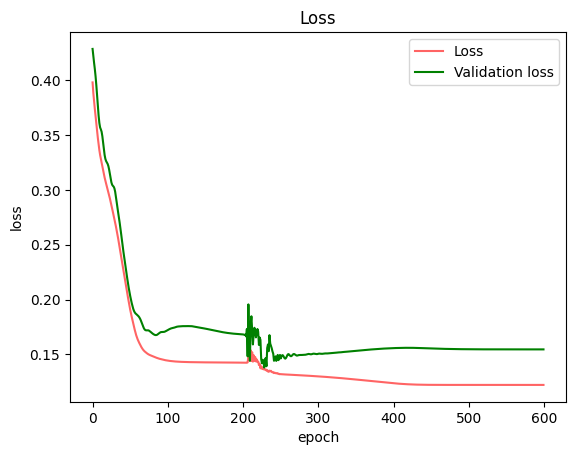

Epoch:  0 | Cost: 0.122154 | Train accuracy: 0.480000 | Validation Accuracy: 0.480000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 2, 1, 2)
0.8014363662008177
lr: 0.15 0.01
50
step 100, accuracy_train:0.8742857142857143, loss: 0.0572947451035438
0.5108405924237667
lr: 0.15 0.01
100
0.5935681224525063
lr: 0.15 0.01
150
step 200, accuracy_train:0.9314285714285714, loss: 0.03188480102415267
0.17010923746685594
lr: 0.15 0.01
200
0.03714189247466251
accuracy of best loss : 0.9371428571428572
lr: 0.05 0.05
250
step 300, accuracy_train:0.9314285714285714, loss: 0.030994976530217204
0.01045454977136751
accuracy of best loss : 0.9371428571428572
lr: 0.01 0.01
300
0.011165217758062026
lr: 0.01 0.01
350
step 400, accuracy_train:0.9371428571428572, loss: 0.03086050560915798
0.00014253090404259893
lr: 0.01 0.01
400
6.353509172801035e-05
lr: 0.01 0.01
450
step 500, accuracy_train:0.9371428571428572, loss: 0.030857939774929396
4.061028883266063e-05
lr: 0.01 0.01
500
2.7402056811425928e-05
lr: 0.01 0.01
550

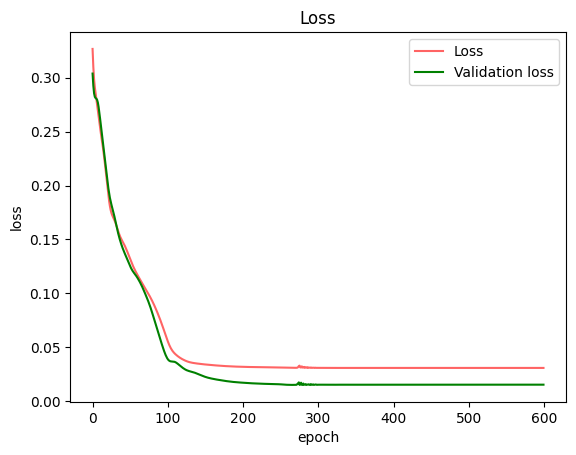

Epoch:  0 | Cost: 0.030860 | Train accuracy: 0.937143 | Validation Accuracy: 0.960000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 2, 1, 2)
0.7919689446963232
lr: 0.15 0.01
50
step 100, accuracy_train:0.33714285714285713, loss: 0.11056193727272243
0.42988945923942556
lr: 0.15 0.01
100
0.09635157680428995
lr: 0.15 0.01
150
step 200, accuracy_train:0.34285714285714286, loss: 0.10531401668762194
0.015865105250257614
accuracy of best loss : 0.34285714285714286
lr: 0.05 0.05
200
0.00313332775035433
accuracy of best loss : 0.3314285714285714
lr: 0.01 0.01
250
step 300, accuracy_train:0.32571428571428573, loss: 0.10365688974696123
0.012754317095529304
lr: 0.01 0.01
300
0.002883337701374603
lr: 0.01 0.01
350
step 400, accuracy_train:0.32571428571428573, loss: 0.1030292462654966
0.0030369874866527004
lr: 0.01 0.01
400
0.0031717587508278628
lr: 0.01 0.01
450
step 500, accuracy_train:0.32571428571428573, loss: 0.10236103238590447
0.0032536664789586034
lr: 0.01 0.01
500
0.0032772411129976266
lr: 0.01 0.

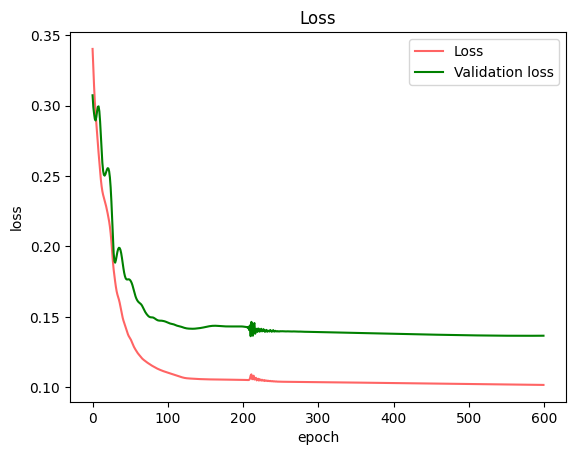

Epoch:  0 | Cost: 0.101860 | Train accuracy: 0.325714 | Validation Accuracy: 0.280000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 2, 1, 2)
0.8377698868687313
lr: 0.15 0.01
50
step 100, accuracy_train:0.56, loss: 0.09300263066672039
0.3990008918315516
lr: 0.15 0.01
100
0.0630818080297322
lr: 0.15 0.01
150
step 200, accuracy_train:0.5828571428571429, loss: 0.08487667798194809
0.05361646635232687
lr: 0.15 0.01
200
0.03434566983716043
accuracy of best loss : 0.6
lr: 0.05 0.05
250
step 300, accuracy_train:0.6, loss: 0.058220239167533876
0.05321361848684531
lr: 0.05 0.05
300
0.3040319738509013
lr: 0.05 0.05
350
step 400, accuracy_train:0.6171428571428571, loss: 0.052968627091255244
0.03573418813055009
lr: 0.05 0.05
400
0.008532027834636689
accuracy of best loss : 0.6171428571428571
lr: 0.01 0.01
450
step 500, accuracy_train:0.6171428571428571, loss: 0.051535585199469554
0.018715348496450256
lr: 0.01 0.01
500
0.0016228490126810142
lr: 0.01 0.01
550
step 600, accuracy_train:0.6171428571428571, loss

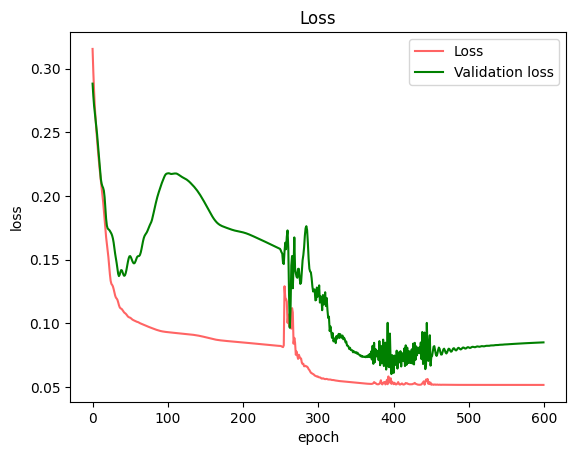

Epoch:  0 | Cost: 0.051516 | Train accuracy: 0.617143 | Validation Accuracy: 0.480000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 2, 1, 2)
0.8284546636742467
lr: 0.15 0.01
50
step 100, accuracy_train:0.9142857142857143, loss: 0.03176127794097885
0.6436838421107905
lr: 0.15 0.01
100
0.5170264474855684
lr: 0.15 0.01
150
step 200, accuracy_train:0.9314285714285714, loss: 0.02878850383064799
0.023431949528631105
accuracy of best loss : 0.9314285714285714
lr: 0.05 0.05
200
0.004569820360592595
accuracy of best loss : 0.9314285714285714
lr: 0.01 0.01
250
step 300, accuracy_train:0.9314285714285714, loss: 0.02860826713752868
0.0026511327999210596
lr: 0.01 0.01
300
0.0010729682173242488
lr: 0.01 0.01
350
step 400, accuracy_train:0.9314285714285714, loss: 0.028523348643266694
0.0014693213153564764
lr: 0.01 0.01
400
0.002123607065654404
lr: 0.01 0.01
450
step 500, accuracy_train:0.9314285714285714, loss: 0.028338640259520553
0.003200040481909937
lr: 0.01 0.01
500
0.004974103435574474
lr: 0.01 0.01
55

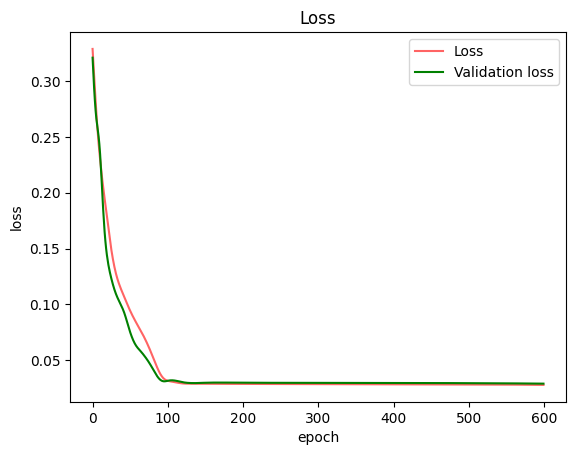

Epoch:  0 | Cost: 0.027880 | Train accuracy: 0.925714 | Validation Accuracy: 0.920000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 2, 1, 2)
0.7485478902111954
lr: 0.15 0.01
50
step 100, accuracy_train:0.7771428571428571, loss: 0.08365072872259943
0.5791404252069741
lr: 0.15 0.01
100
0.3436573718494048
lr: 0.15 0.01
150
step 200, accuracy_train:0.8571428571428571, loss: 0.048389238017227394
0.2632183975176737
lr: 0.15 0.01
200
0.2122213255329292
lr: 0.15 0.01
250
step 300, accuracy_train:0.9314285714285714, loss: 0.029375477499467673
0.23759026586484394
lr: 0.15 0.01
300
0.05313303730572665
lr: 0.15 0.01
350
step 400, accuracy_train:0.9371428571428572, loss: 0.02883220515405127
0.007285162087614351
accuracy of best loss : 0.9371428571428572
lr: 0.05 0.05
400
0.01213304745099745
accuracy of best loss : 0.9314285714285714
lr: 0.01 0.01
450
step 500, accuracy_train:0.9314285714285714, loss: 0.02804445641507224
0.014149019308554478
lr: 0.01 0.01
500
0.007393315533576682
lr: 0.01 0.01
550
step 600

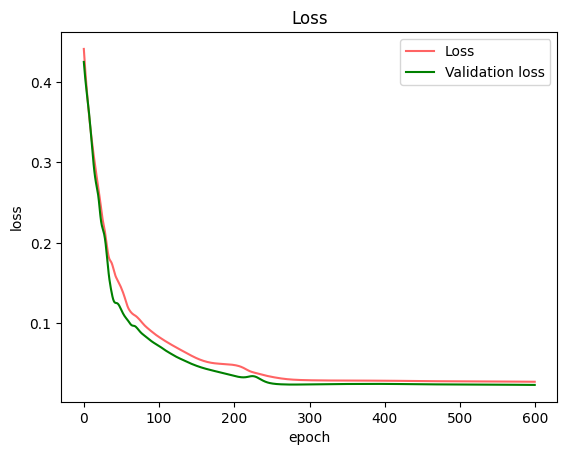

Epoch:  0 | Cost: 0.027487 | Train accuracy: 0.931429 | Validation Accuracy: 0.960000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 2, 1, 2)
0.7021350145279932
lr: 0.15 0.01
50
step 100, accuracy_train:0.3485714285714286, loss: 0.13332795454700347
0.44982227346312287
lr: 0.15 0.01
100
0.30992332417688356
lr: 0.15 0.01
150
step 200, accuracy_train:0.36, loss: 0.050800979642141295
0.4048766881201155
lr: 0.15 0.01
200
0.4062470995193492
lr: 0.15 0.01
250
step 300, accuracy_train:0.0, loss: 0.025868890905273317
0.2796758704266046
lr: 0.15 0.01
300
0.13821361350202585
lr: 0.15 0.01
350
step 400, accuracy_train:0.0, loss: 0.023888517832991677
0.030713031602815768
accuracy of best loss : 0.0
lr: 0.05 0.05
400
0.01651264183987426
accuracy of best loss : 0.0
lr: 0.01 0.01
450
step 500, accuracy_train:0.0, loss: 0.021494655149827274
0.08392957202587834
lr: 0.01 0.01
500
0.012671993445693726
lr: 0.01 0.01
550
step 600, accuracy_train:0.0, loss: 0.021238391208956705
0.005626833811104501
lr: 0.01 0.01
600

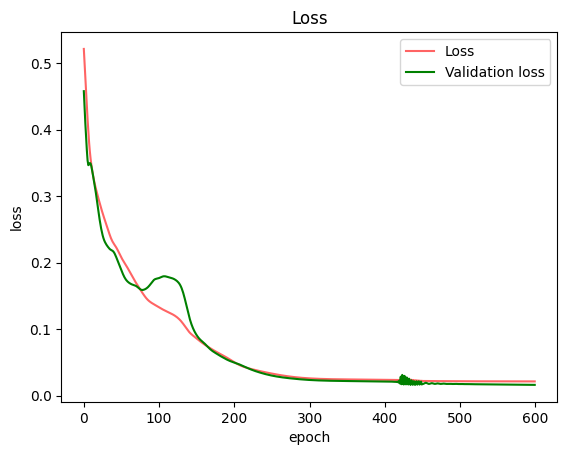

Epoch:  0 | Cost: 0.021238 | Train accuracy: 0.000000 | Validation Accuracy: 0.000000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 2, 1, 2)
0.7771158316539639
lr: 0.15 0.01
50
step 100, accuracy_train:0.9257142857142857, loss: 0.03344267722335765
0.7901243366922179
lr: 0.15 0.01
100
0.3178151079809855
lr: 0.15 0.01
150
step 200, accuracy_train:0.9257142857142857, loss: 0.02976752548134735
0.04701867088576154
accuracy of best loss : 0.9257142857142857
lr: 0.05 0.05
200
0.1458822207469374
lr: 0.05 0.05
250
step 300, accuracy_train:0.9314285714285714, loss: 0.023124059232009456
0.10664508947144859
lr: 0.05 0.05
300
0.0039369943618105495
accuracy of best loss : 0.9314285714285714
lr: 0.01 0.01
350
step 400, accuracy_train:0.9314285714285714, loss: 0.02309376800162966
0.0006770758483972563
lr: 0.01 0.01
400
0.0003437987329851542
lr: 0.01 0.01
450
step 500, accuracy_train:0.9314285714285714, loss: 0.02307361565081293
0.00043486293435673586
lr: 0.01 0.01
500
0.0005573403505787994
lr: 0.01 0.01
550


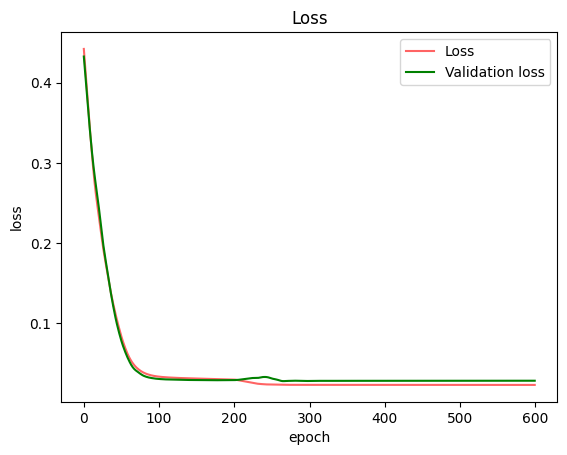

Epoch:  0 | Cost: 0.023059 | Train accuracy: 0.931429 | Validation Accuracy: 0.920000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 2, 1, 2)
t_n_seeds: 76.88535720000004


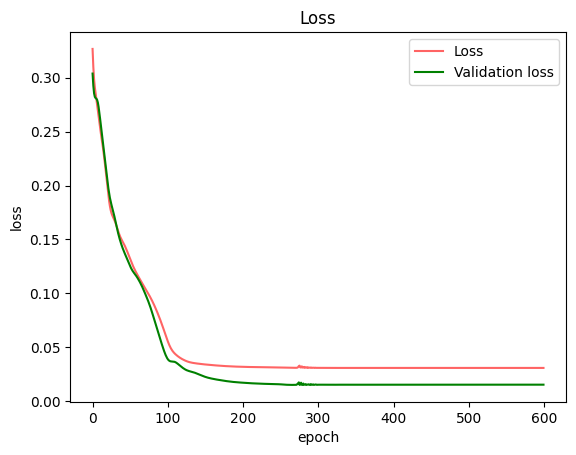

enc_circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.8000250686314968
lr: 0.15 0.01
50
step 100, accuracy_train:0.65, loss: 0.08041877630814134
0.44470941923857915
lr: 0.15 0.01
100
0.5755968550017281
lr: 0.15 0.01
150
step 200, accuracy_train:0.935, loss: 0.029836305017513283
0.3412570641036875
lr: 0.15 0.01
200
0.05227601650417672
lr: 0.15 0.01
250
step 300, accuracy_train:0.94, loss: 0.028922033306711878
0.013386244428690602
accuracy of best loss : 0.94
lr: 0.05 0.05
300
0.0011574311720235382
accuracy of best loss : 0.94
lr: 0.01 0.01
350
step 400, accuracy_train:0.94, loss: 0.028655176156625686
0.013720896174329561
lr: 0.01 0.01
400
0.0005321080980275168
lr: 0.01 0.01
450
step 500, accuracy_train:0.94, loss: 0.028616154419102563
0.000668986129924799
lr: 0.01 0.01
500
0.0010548795158907113
lr: 0.01 0.01
550
step 600, accuracy_train:0.94, loss: 0.028514494091072262
0.0017406345382620786
lr: 0.01 0.01
600
lr: 0.01 0.01
accurac

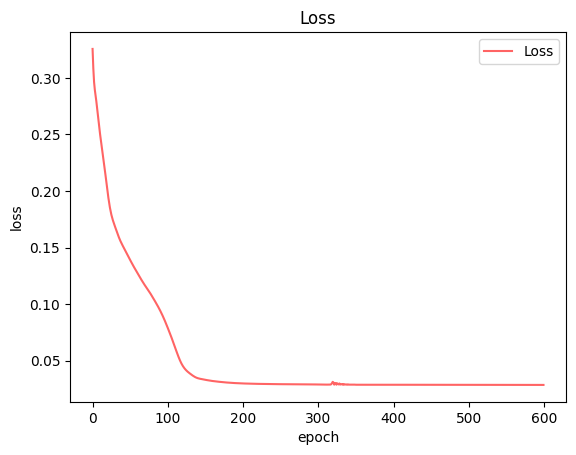

Epoch:  0 | Cost: 0.028514 | Train accuracy: 0.940000 | Test Accuracy: 0.800000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 2, 1, 2)


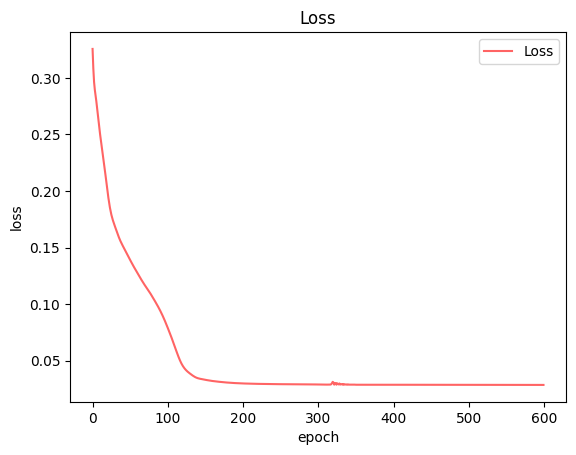

enc_circuit is jitted
circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
enc_circuit is jitted
circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.7545555336247323
lr: 0.15 0.01
50
step 100, accuracy_train:0.9142857142857143, loss: 0.034111582579852646
0.7557486287515431
lr: 0.15 0.01
100
0.46978303632876106
lr: 0.15 0.01
150
step 200, accuracy_train:0.9257142857142857, loss: 0.03048360346617254
0.03638882339244679
accuracy of best loss : 0.9257142857142857
lr: 0.05 0.05
200
0.005378103324297514
accuracy of best loss : 0.9257142857142857
lr: 0.01 0.01
250
step 300, accuracy_train:0.9257142857142857, loss: 0.03009736718523272
0.02182901639964254
lr: 0.01 0.01
300
0.001738089629874407
lr: 0.01 0.01
350
step 400, accuracy_train:0.9257142857142857, loss: 0.029993403196269586
0.0017253717250771416
lr: 0.01 0.01
400
0.001670643094075909
lr: 0.01 0.01
450
step 500, accuracy_train:0.9

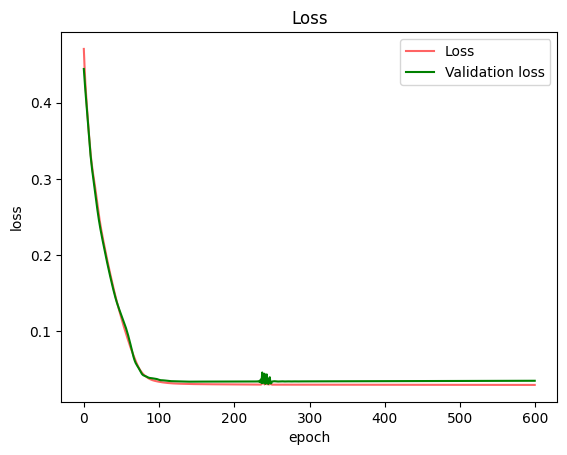

Epoch:  0 | Cost: 0.029845 | Train accuracy: 0.920000 | Validation Accuracy: 0.920000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 3, 1, 2)
0.8248122848960779
lr: 0.15 0.01
50
step 100, accuracy_train:0.92, loss: 0.032690604533746004
0.7361451487760186
lr: 0.15 0.01
100
0.33438739034955767
lr: 0.15 0.01
150
step 200, accuracy_train:0.92, loss: 0.02969923155977881
0.031162389441160253
accuracy of best loss : 0.92
lr: 0.05 0.05
200
0.011656538018410382
accuracy of best loss : 0.92
lr: 0.01 0.01
250
step 300, accuracy_train:0.92, loss: 0.02913635543233691
0.0097889803058832
lr: 0.01 0.01
300
0.002195436588394278
lr: 0.01 0.01
350
step 400, accuracy_train:0.92, loss: 0.02905600432239723
0.0013273872540358728
lr: 0.01 0.01
400
0.000942287509686596
lr: 0.01 0.01
450
step 500, accuracy_train:0.92, loss: 0.02899774417181555
0.0009869043467119099
lr: 0.01 0.01
500
0.0012651148205334356
lr: 0.01 0.01
550
step 600, accuracy_train:0.92, loss: 0.02889685982464702
0.0017259364546515193
lr: 0.01 0.01
600
l

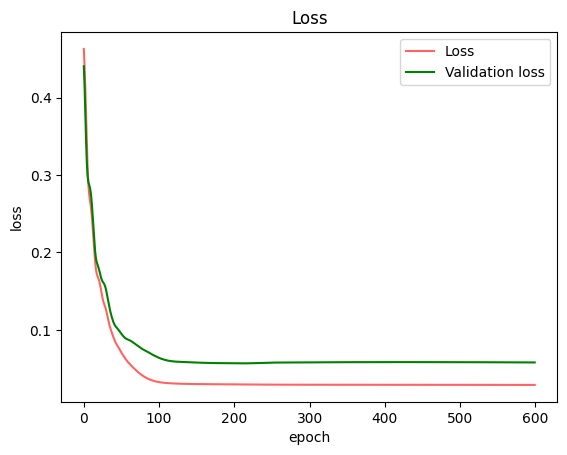

Epoch:  0 | Cost: 0.028897 | Train accuracy: 0.920000 | Validation Accuracy: 0.840000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 3, 1, 2)
0.730197403816637
lr: 0.15 0.01
50
step 100, accuracy_train:0.5371428571428571, loss: 0.1483817937515555
0.3449395913026961
lr: 0.15 0.01
100
0.3130721086750562
lr: 0.15 0.01
150
step 200, accuracy_train:0.6514285714285715, loss: 0.08270233562336378
0.2957691977514198
lr: 0.15 0.01
200
0.1216870624813613
lr: 0.15 0.01
250
step 300, accuracy_train:0.7428571428571429, loss: 0.07070970697997533
0.05767365175837046
lr: 0.15 0.01
300
0.0009377265709213497
accuracy of best loss : 0.7428571428571429
lr: 0.05 0.05
350
step 400, accuracy_train:0.7371428571428571, loss: 0.0707825539553667
0.032775054969493976
lr: 0.05 0.05
400
0.03187638442895602
lr: 0.05 0.05
450
step 500, accuracy_train:0.7371428571428571, loss: 0.07049913293892046
0.0019435944260178908
accuracy of best loss : 0.7371428571428571
lr: 0.01 0.01
500
0.0008467673769922678
lr: 0.01 0.01
550
step 600,

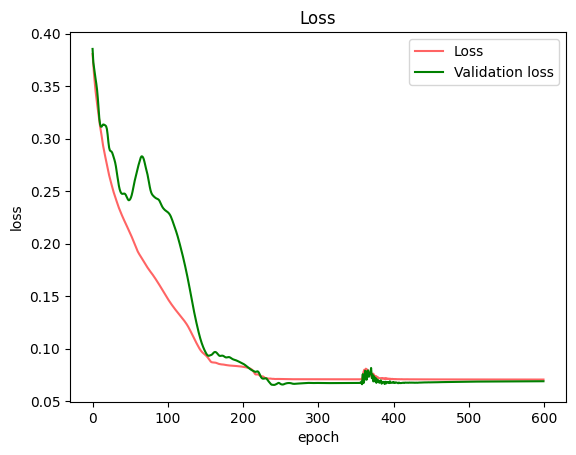

Epoch:  0 | Cost: 0.070478 | Train accuracy: 0.737143 | Validation Accuracy: 0.760000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 3, 1, 2)
0.7754173822900566
lr: 0.15 0.01
50
step 100, accuracy_train:0.18857142857142858, loss: 0.13389690789680528
0.3891261622252738
lr: 0.15 0.01
100
0.030749753408783474
accuracy of best loss : 0.19428571428571428
lr: 0.05 0.05
150
step 200, accuracy_train:0.25142857142857145, loss: 0.1335669893871095
0.11002881283117966
lr: 0.05 0.05
200
0.11083768520730673
lr: 0.05 0.05
250
step 300, accuracy_train:0.25142857142857145, loss: 0.1289498461596347
0.005590734251177285
accuracy of best loss : 0.25142857142857145
lr: 0.01 0.01
300
0.01407744802408337
lr: 0.01 0.01
350
step 400, accuracy_train:0.26285714285714284, loss: 0.12767717287108038
0.004183199935517395
lr: 0.01 0.01
400
0.01000889638988202
lr: 0.01 0.01
450
step 500, accuracy_train:0.26857142857142857, loss: 0.12474248316508164
0.012224567595518748
lr: 0.01 0.01
500
0.008141039858949825
lr: 0.01 0.01
550


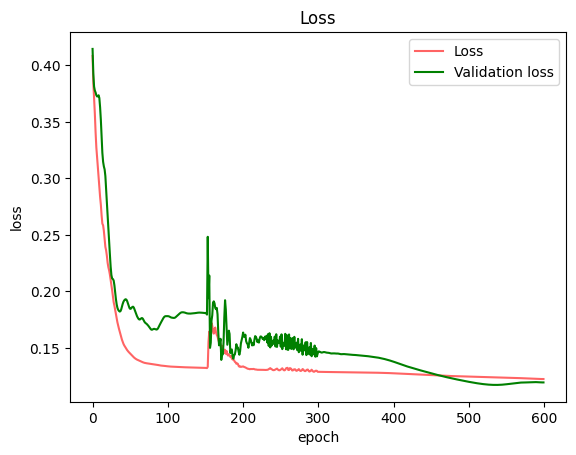

Epoch:  0 | Cost: 0.123828 | Train accuracy: 0.274286 | Validation Accuracy: 0.200000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 3, 1, 2)
0.8714314996876932
lr: 0.15 0.01
50
step 100, accuracy_train:0.9142857142857143, loss: 0.03070198974313353
0.6595034406912328
lr: 0.15 0.01
100
0.31722673427871073
lr: 0.15 0.01
150
step 200, accuracy_train:0.9371428571428572, loss: 0.026357552594138897
0.06203181727072695
lr: 0.15 0.01
200
0.10717735004800233
lr: 0.15 0.01
250
step 300, accuracy_train:0.9428571428571428, loss: 0.023843403477279434
0.04438253834143547
accuracy of best loss : 0.9428571428571428
lr: 0.05 0.05
300
0.5865952227968163
lr: 0.05 0.05
350
step 400, accuracy_train:0.9485714285714286, loss: 0.023705151111878944
0.3284816532770796
lr: 0.05 0.05
400
0.07001778834223232
lr: 0.05 0.05
450
step 500, accuracy_train:0.9485714285714286, loss: 0.0236527733783943
0.0014198500473674932
accuracy of best loss : 0.9485714285714286
lr: 0.01 0.01
500
0.0007446227360551014
lr: 0.01 0.01
550
step 6

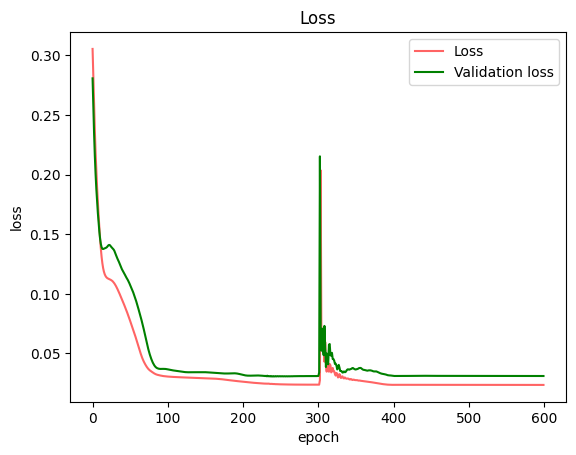

Epoch:  0 | Cost: 0.023638 | Train accuracy: 0.948571 | Validation Accuracy: 0.960000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 3, 1, 2)
0.7879762352621164
lr: 0.15 0.01
50
step 100, accuracy_train:0.64, loss: 0.15719349627627371
0.24827469288164006
lr: 0.15 0.01
100
0.025558339323288947
accuracy of best loss : 0.6285714285714286
lr: 0.05 0.05
150
step 200, accuracy_train:0.30857142857142855, loss: 0.10198348690760595
0.11034074821965774
lr: 0.05 0.05
200
0.31043074456876996
lr: 0.05 0.05
250
step 300, accuracy_train:0.0, loss: 0.03656852443422424
0.3510114873362464
lr: 0.05 0.05
300
0.5523075532380055
lr: 0.05 0.05
350
step 400, accuracy_train:0.0, loss: 0.0217663280907252
0.15952850380114572
lr: 0.05 0.05
400
0.11571734411142269
lr: 0.05 0.05
450
step 500, accuracy_train:0.0, loss: 0.019871150957468667
0.024911978063830557
accuracy of best loss : 0.0
lr: 0.01 0.01
500
0.011919386501350378
lr: 0.01 0.01
550
step 600, accuracy_train:0.0, loss: 0.01966226759319826
0.005373444375148226
lr: 

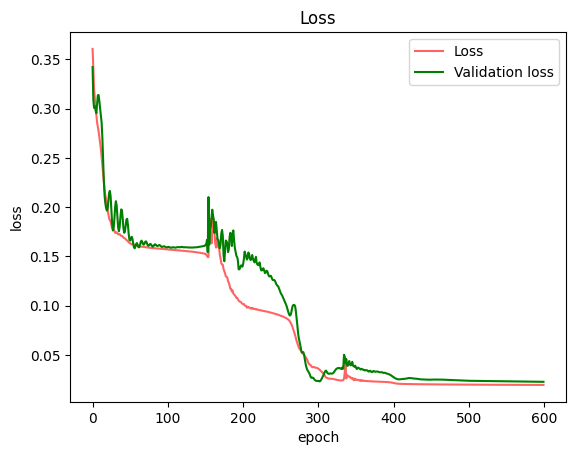

Epoch:  0 | Cost: 0.019662 | Train accuracy: 0.000000 | Validation Accuracy: 0.000000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 3, 1, 2)
0.7617763674145204
lr: 0.15 0.01
50
step 100, accuracy_train:0.4685714285714286, loss: 0.11478939336888198
0.43609302703099134
lr: 0.15 0.01
100
0.1640019688324375
lr: 0.15 0.01
150
step 200, accuracy_train:0.4, loss: 0.11039359553015866
0.013975379500348268
accuracy of best loss : 0.4
lr: 0.05 0.05
200
0.02093217432892087
accuracy of best loss : 0.21714285714285714
lr: 0.01 0.01
250
step 300, accuracy_train:0.16, loss: 0.07063876204773689
0.3644805706734634
lr: 0.01 0.01
300
0.026039250360509685
lr: 0.01 0.01
350
step 400, accuracy_train:0.13142857142857142, loss: 0.06868658016701079
0.012911863989587756
lr: 0.01 0.01
400
0.011647894641956466
lr: 0.01 0.01
450
step 500, accuracy_train:0.08, loss: 0.06711113373463713
0.011695683083377638
lr: 0.01 0.01
500
0.010518597782925033
lr: 0.01 0.01
550
step 600, accuracy_train:0.05714285714285714, loss: 0.0657283

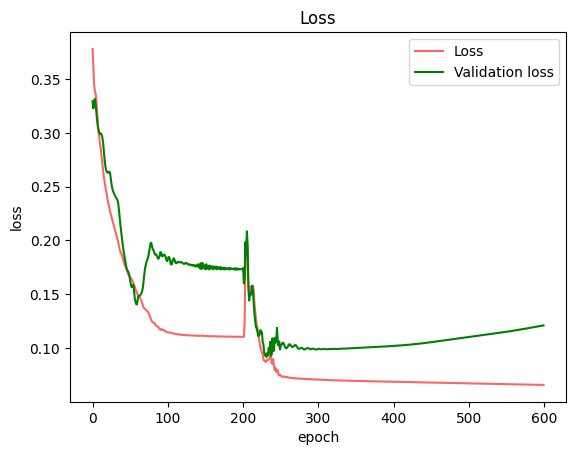

Epoch:  0 | Cost: 0.066413 | Train accuracy: 0.057143 | Validation Accuracy: 0.080000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 3, 1, 2)
0.7948088397227696
lr: 0.15 0.01
50
step 100, accuracy_train:0.8, loss: 0.06361752090550257
0.5887886523796663
lr: 0.15 0.01
100
0.4932581435526831
lr: 0.15 0.01
150
step 200, accuracy_train:0.9314285714285714, loss: 0.025120699649316187
0.3668706185212478
lr: 0.15 0.01
200
0.0850562085609212
lr: 0.15 0.01
250
step 300, accuracy_train:0.9257142857142857, loss: 0.0239800923604039
0.020070345795036307
accuracy of best loss : 0.9257142857142857
lr: 0.05 0.05
300
0.18567916887449956
lr: 0.05 0.05
350
step 400, accuracy_train:0.9314285714285714, loss: 0.022827454417011016
0.2020384274612346
lr: 0.05 0.05
400
0.0070420528722894594
accuracy of best loss : 0.9314285714285714
lr: 0.01 0.01
450
step 500, accuracy_train:0.9314285714285714, loss: 0.022767404409863124
0.0012657618404280353
lr: 0.01 0.01
500
0.0005344312542033946
lr: 0.01 0.01
550
step 600, accuracy_t

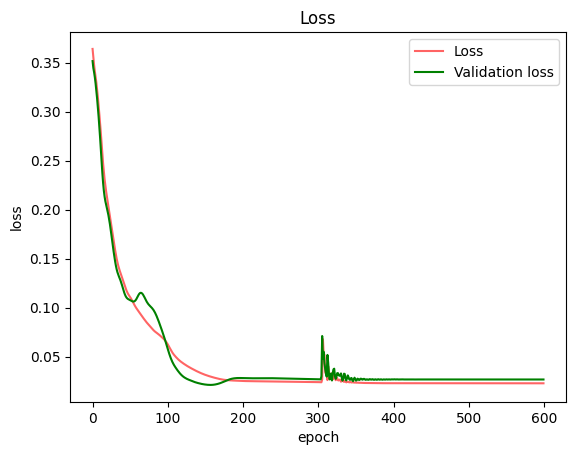

Epoch:  0 | Cost: 0.022740 | Train accuracy: 0.931429 | Validation Accuracy: 0.920000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 3, 1, 2)
0.7648562618179418
lr: 0.15 0.01
50
step 100, accuracy_train:0.92, loss: 0.0462513280084929
0.6477399326450657
lr: 0.15 0.01
100
0.5998577330830973
lr: 0.15 0.01
150
step 200, accuracy_train:0.9485714285714286, loss: 0.024857447863987307
0.22750384876759597
lr: 0.15 0.01
200
0.038106868918984065
accuracy of best loss : 0.9485714285714286
lr: 0.05 0.05
250
step 300, accuracy_train:0.9314285714285714, loss: 0.024615319953619916
0.08771249836274995
lr: 0.05 0.05
300
0.09131484838336959
lr: 0.05 0.05
350
step 400, accuracy_train:0.9371428571428572, loss: 0.024199820312086964
0.004610039246458803
accuracy of best loss : 0.9371428571428572
lr: 0.01 0.01
400
0.001524680378157139
lr: 0.01 0.01
450
step 500, accuracy_train:0.9371428571428572, loss: 0.024170793383967718
0.000605512898719191
lr: 0.01 0.01
500
0.0006764460229765137
lr: 0.01 0.01
550
step 600, accura

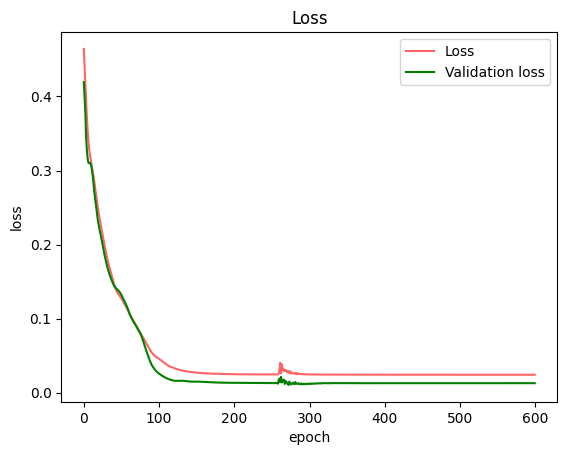

Epoch:  0 | Cost: 0.024153 | Train accuracy: 0.937143 | Validation Accuracy: 0.960000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 3, 1, 2)
0.7482831343979274
lr: 0.15 0.01
50
step 100, accuracy_train:0.7028571428571428, loss: 0.09120274104408921
0.5990001846218136
lr: 0.15 0.01
100
0.13321027559584653
lr: 0.15 0.01
150
step 200, accuracy_train:0.7257142857142858, loss: 0.08403537368760196
0.03268171601062771
accuracy of best loss : 0.7257142857142858
lr: 0.05 0.05
200
0.4205510484923316
lr: 0.05 0.05
250
step 300, accuracy_train:0.9542857142857143, loss: 0.021266310319368004
0.5626861684663913
lr: 0.05 0.05
300
0.01722647186029267
accuracy of best loss : 0.9428571428571428
lr: 0.01 0.01
350
step 400, accuracy_train:0.9428571428571428, loss: 0.020329716872737394
0.031745514031336325
lr: 0.01 0.01
400
0.005097518223728046
lr: 0.01 0.01
450
step 500, accuracy_train:0.9428571428571428, loss: 0.020268512788932734
0.0013032301410945126
lr: 0.01 0.01
500
0.0008266861536435855
lr: 0.01 0.01
550
ste

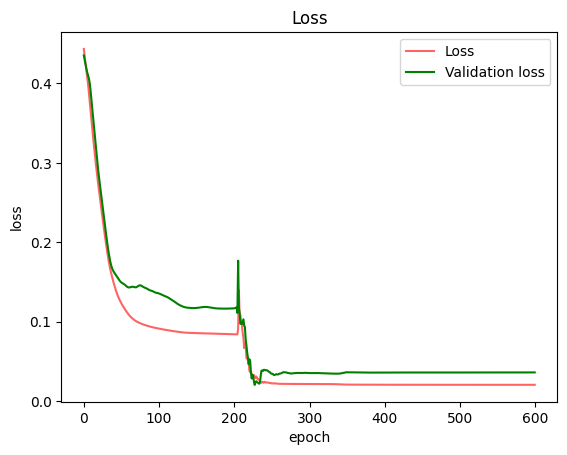

Epoch:  0 | Cost: 0.020252 | Train accuracy: 0.942857 | Validation Accuracy: 0.920000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 3, 1, 2)
t_n_seeds: 107.03291069999977


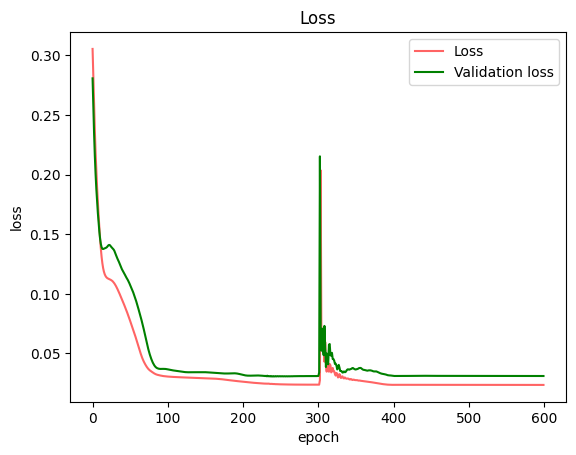

enc_circuit is jitted
circuit is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
0.8678461539197598
lr: 0.15 0.01
50
step 100, accuracy_train:0.92, loss: 0.030655343118819393
0.6159200182884137
lr: 0.15 0.01
100
0.41955920804991576
lr: 0.15 0.01
150
step 200, accuracy_train:0.94, loss: 0.026703569584317435
0.04508791723321188
accuracy of best loss : 0.94
lr: 0.05 0.05
200
0.6649422148342794
lr: 0.05 0.05
250
step 300, accuracy_train:0.94, loss: 0.02797058184439382
0.3895969450470225
lr: 0.05 0.05
300
0.0621991571439003
lr: 0.05 0.05
350
step 400, accuracy_train:0.945, loss: 0.024274605687938742
0.0896784740966374
lr: 0.05 0.05
400
0.007150549358926789
accuracy of best loss : 0.945
lr: 0.01 0.01
450
step 500, accuracy_train:0.945, loss: 0.02416213976366409
0.0024171998130600894
lr: 0.01 0.01
500
0.0012240481428448665
lr: 0.01 0.01
550
step 600, accuracy_train:0.945, loss: 0.02408768309897421
0.0015364476245361158
lr: 0.01 0.01
600
lr: 0.01 

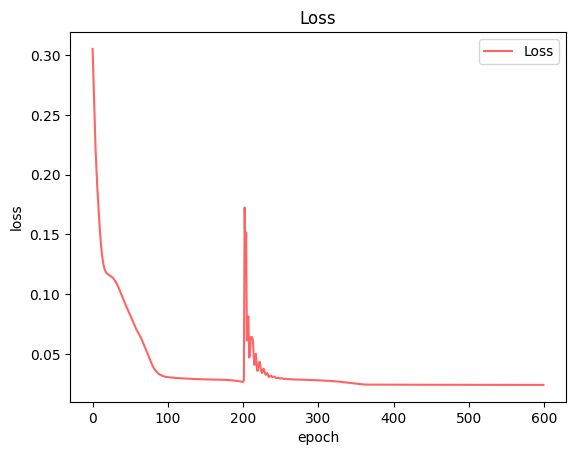

Epoch:  0 | Cost: 0.024088 | Train accuracy: 0.945000 | Test Accuracy: 0.700000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 3, 1, 2)


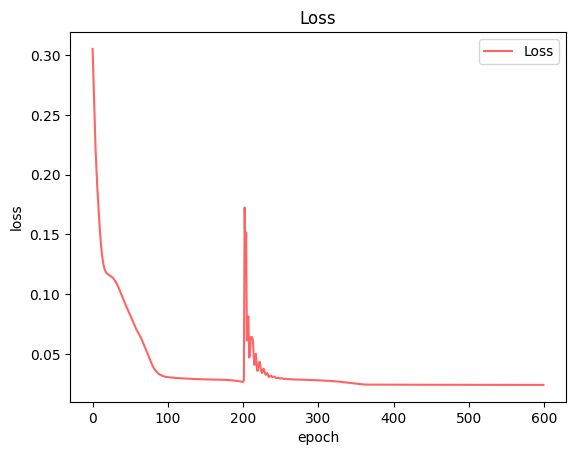

In [18]:
t_seed_start = time.process_time()
configs['noise'] = training_noise
best_params = []
results = []
for i,setting in enumerate(settings):
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
    learning_rate,max_epoch,batch_size,dynamic_size,threshold = h_pms[best_h_pm[i]]
    t_seed_start = time.process_time()
    # Generate training and test data
    X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim,**configs)
    configs['qc'] = qcircuit(*setting, **configs)
    
    seed_rsts, seed_params = [], []
    loss_history_seeds= []
    #run 10 seeds
    for seed_num in seeds:
        #########
        loss_history = []
        valid_loss_history = []
        accuracy_history = []  
        configs['iter_lr'] = iter(learning_rate)
        configs['iter_thres'] = iter(list(threshold))
        configs['lr'] = next(configs['iter_lr'])
        configs['thres_n'] = next(configs['iter_thres'])

        seed_rst = run(seed_num, X_train, y_train, *setting, **configs)
        #########
        seed_params.append(seed_rst[0])
        seed_rsts.append(seed_rst[1])
        loss_history_seeds.append([loss_history,valid_loss_history])
    t_n_seeds = time.process_time()-t_seed_start
    print('t_n_seeds:', t_n_seeds)
    best_index = np.argmax(seed_rsts,axis=0)[2]  #best index based on validation accuracy->(seed_num,accuracy_train, accuracy_valid,...) 
    #best_rst = seed_rsts[best_index]
    seed_num = seeds[best_index]
    l_h_best, val_l_h_best = loss_history_seeds[best_index]
    plot_loss_history(l_h_best, val_l_h_best, setting=setting,
                      fig_name = f'{setting}_loss_best_seed')
    #########
    configs['noise'] = test_noise
    loss_history = []
    valid_loss_history = []
    accuracy_history = []
    configs['iter_lr'] = iter(learning_rate)
    configs['iter_thres'] = iter(list(threshold))
    configs['lr'] = next(configs['iter_lr'])
    configs['thres_n'] = next(configs['iter_thres'])
    params,best_rst = run(seed_num, X_train, y_train, x_te = X_test, y_te = y_test, ratio_tr=1, *setting, **configs)
    plot_loss_history(loss_history, setting=setting)
    #########
    best_params.append(params)
    results.append([enc_dim,num_qubits,num_layers,num_reupload,num_rot,*best_rst, t_n_seeds])
t_seeds = time.process_time()-t_seed_start

In [19]:
def name_experiment(num_settings,start_value):
    exp_name = '('
    exp = ['enc','q','f','r','rot']
    # if len(exp)!=len(num_settings): print(experiment styles not matched!)
    for i, j in enumerate(num_settings):
        exp_name = exp_name+f'{start_value[i]}' if j==1 else exp_name+f'{exp[i]}'
        exp_name = exp_name+')' if i==len(exp)-1 else exp_name+','
    return exp_name
exp_name = name_experiment(num_settings,start_values)
exp_name

'(5,1,f,1,2)'

In [20]:
import pandas as pd
data = {'enc_dim' : [],
        'num_qubits' : [],
        'num_layers' : [],
        'num_reupload' : [],
        'num_rot ': [],
        'seed_num' : [],
        'Train_acc' : [],
        'Test_acc' : [],
        'loss' : [],
        'num_epoch':[],
        f'time_{num_seeds}_seeds' : []}
for result in results:
    for i,(d,r) in enumerate(zip(data,result)):
        print(d,r)
        if i<5: data[d].append(int(r));
        else:   data[d].append(float(r))

# 将数据转换为DataFrame
df = pd.DataFrame(data)
df.style.hide()
# 显示DataFrame
#print(df.to_string(index=False))
# 若要在Jupyter Notebook中显示漂亮的表格，可以使用以下方法
display(df)
# 如果需要将DataFrame保存为HTML文件，可以使用以下方法
# df.to_html('table.html')

# Export to Excel
excel_file_path = f'Data_{exp_name}.xlsx'
sheet_name = 'Sheet1'

df.to_excel(excel_file_path, index=False, sheet_name=sheet_name)

enc_dim 5
num_qubits 1
num_layers 1
num_reupload 1
num_rot  2
seed_num 68678
Train_acc 0.87
Test_acc 0.76
loss 0.054062661022334084
num_epoch 600
time_10_seeds 53.15475859999992
enc_dim 5
num_qubits 1
num_layers 2
num_reupload 1
num_rot  2
seed_num 4174
Train_acc 0.94
Test_acc 0.8
loss 0.028514494091072262
num_epoch 600
time_10_seeds 76.88535720000004
enc_dim 5
num_qubits 1
num_layers 3
num_reupload 1
num_rot  2
seed_num 32150
Train_acc 0.945
Test_acc 0.7
loss 0.02408768309897421
num_epoch 600
time_10_seeds 107.03291069999977


enc_dim  num_qubits  num_layers  num_reupload  num_rot   seed_num  \
0        5           1           1             1         2   68678.0   
1        5           1           2             1         2    4174.0   
2        5           1           3             1         2   32150.0   

   Train_acc  Test_acc      loss  num_epoch  time_10_seeds  
0      0.870      0.76  0.054063      600.0      53.154759  
1      0.940      0.80  0.028514      600.0      76.885357  
2      0.945      0.70  0.024088      600.0     107.032911

In [21]:
rec_settings = {'problem':problem,
                'shape':shape, 
                'rot':rot,
                'num_training':len(X_train),
                'num_test':len(X_test),
                'preprocess':configs['preprocess'],
                'max_converge_number':max_n_converge,
                'threshold_of_converge':thres_converge,
                'data_seed_num': data_seed_num,
                'param_seed_nums': seeds,
                f't_{num_cvs}_cv': f'{t_cvs} s',
                f't_{num_seeds}_seeds': f'{t_seeds} s',
                '[enc_dim,num_qubits,num_layers,num_reupload,num_rot]':settings,
                '[learning_rate,max_epoch,batch_size,dynamic_size,threshold]':[h_pms[i] for i in best_h_pm ]
               }
#dict_settings = {k:v for i,(k,v) in enumerate(data.items()) if i<6 }

In [22]:
F = open("{}_settings.txt".format(ver), "w")
for i,j in rec_settings.items():
    F.write(i+": {}\n".format(j))
    
for i,setting in enumerate(settings):
    F.write(f"params of setting {setting}：\n")
    for key, value in best_params[i].items():
        F.write(f"    {key}: {value} \n")
F.close()

In [23]:
print(t_cvs)
t_seeds

1160.6624536000002


119.57171259999996

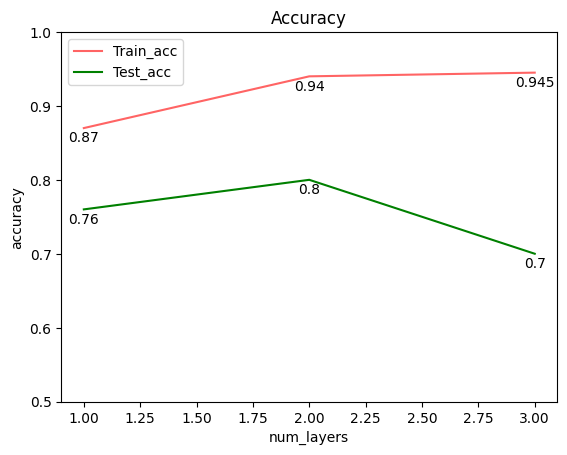

In [24]:
for run_exp, x_label in zip([i != 1 for i in num_settings],data):
    if run_exp:
        fig, ax = plt.subplots(1, 1)
        ax.set_ylim([0.5, 1])
        plt.plot(data[x_label],data['Train_acc'],color=(255/255,100/255,100/255),label='Train_acc')
        plt.plot(data[x_label],data['Test_acc'],color='g',label='Test_acc')
        for i,j,k in zip(data[x_label],data['Train_acc'],data['Test_acc']):
            ax.annotate(f'{j}', xy=(i,j), xytext=(0,-10), textcoords='offset points' ,ha='center')
            ax.annotate(f'{k}', xy=(i,k), xytext=(0,-10), textcoords='offset points' ,ha='center')
        plt.title("Accuracy") # title
        plt.ylabel("accuracy") # y label
        plt.xlabel(x_label) # x label
        plt.legend()
        plt.show()
        fig.savefig(f'Accuracy-{x_label}.png', transparent=True)

In [25]:
for i in best_h_pm:
    print(h_pms[i])
best_h_pm

((0.15, 0.05, 0.01, 0.001, 0.0001), 600, 300, 50, (0.05, 0.03, 0.01))
((0.15, 0.05, 0.01), 600, 50, 50, (0.05, 0.03, 0.01))
((0.15, 0.05, 0.01), 600, 50, 50, (0.05, 0.03, 0.01))


[np.int64(5), np.int64(0), np.int64(0)]

In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim,**configs)
max_search_n=20
n_nodes = []
t1_c = time.process_time()

r_enc, r_q ,r_f, r_r, r_rot = num_settings 

for f in range(r_f):
    scores=[]
    for n in range(max_search_n):
        size = [n+1]*(f+1)
        clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=size, 
                            random_state=data_seed_num,max_iter=6000, warm_start=False)
        score = np.min(cross_val_score(clf, X_train, y_train, cv=10))  
        if score >= data['Test_acc'][f] or n == (max_search_n-1): 
            n_nodes.append(n+1)
            break

sizes = [[n_nodes[f]]*(f+1) for f in range(r_f)] if r_f!=1 else [[n_nodes[f]]]*len(settings)
accuracy_tr, accuracy=[],[]

for size in sizes:
    seed_tr_rsts, seed_rsts = [], []
    for seed in seeds:
        clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=size, 
                                random_state=seed,max_iter=6000, warm_start=False)
        clf.fit(X_train, y_train)
        y_pred_tr = clf.predict(X_train)
        y_pred = clf.predict(X_test)
        # report = classification_report(y_test, y_pred)
        seed_tr_rsts.append(accuracy_score(y_train, y_pred_tr))
        seed_rsts.append(accuracy_score(y_test, y_pred))
    accuracy_tr.append(np.average(seed_tr_rsts))
    accuracy.append(np.average(seed_rsts))
t_c_tot = time.process_time()-t1_c
print(f'Time for classical NN: {t_c_tot} s') # Need modified  as detail version
print(accuracy_tr)
print(accuracy)
print(data['Test_acc'])
sizes

Time for classical NN: 14.833675000000085 s
[np.float64(0.7045), np.float64(0.758), np.float64(0.6745)]
[np.float64(0.682), np.float64(0.712), np.float64(0.634)]
[0.76, 0.8, 0.7]


[[2], [1, 1], [1, 1, 1]]

In [33]:
def param_n_model(settings, model='NN'):
    if model=='NN':
        n_params = []
        for n_nodes in settings:
            # n_params = []
            r_f = len(n_nodes)
            for f in range(r_f):
                n_p=0
                for i in range(f+1):
                    n_p=n_p+(len(X_train[0])+1)*n_nodes[f] if i==0  else n_p
                    n_p=n_p+(n_nodes[i]+1)*num_class if i==(r_f-1) else n_p
                    n_p=n_p+(n_nodes[f]+1)*n_nodes[f] if i!=0 or i!=(r_f-1) else n_p
            n_params.append(n_p)
    if model=='QNN':
        n_params=[]
        for setting in settings:
            enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
            n_params.append((enc_dim +num_rot*3)*num_qubits*num_reupload*num_layers+ num_class* num_qubits)

    return n_params
num_params_NN = param_n_model(sizes,model='NN')
num_params_QNN = param_n_model(settings,model='QNN') 

print('Number of params in NN model:', num_params_NN)
print('Number of params in QNN model:', num_params_QNN)

Number of params in NN model: [np.int64(18), np.int64(14), np.int64(16)]
Number of params in QNN model: [np.int64(13), np.int64(24), np.int64(35)]


In [35]:
import pandas as pd
c_values=np.array([[str(size) for size in sizes],accuracy_tr,accuracy,data['Test_acc'],
                   num_params_NN,num_params_QNN,[t_c_tot]*len(settings)])
c_values=np.append(settings,c_values.T, axis=1)
c_data = {'enc_dim' : [],
        'num_qubits' : [],
        'num_layers' : [],
        'num_reupload' : [],
        'num_rot ': [],
        'num_c_nodes ': [],
        'C_train_acc' : [],
        'C_test_acc' : [],
        'Q_test_acc' : [],
        'num_params_NN' : [],
        'num_params_QNN' : [],
        f'time_{num_seeds}_seeds' : []}
for result in c_values:
    for i,(d,r) in enumerate(zip(c_data,result)):
        # if type(r) is np.str_: c_data[d].append(r);
        # elif i<6: c_data[d].append(int(r));
        # else:   c_data[d].append(float(r))
        if i<6: c_data[d].append(r);
        else:   c_data[d].append(float(r))


df = pd.DataFrame(c_data)
df.style.hide()
display(df)
# Export to Excel
excel_file_path = f'classical_data_comparism.xlsx'
sheet_name = 'Sheet1'
df.to_excel(excel_file_path, index=False, sheet_name=sheet_name)

enc_dim num_qubits num_layers num_reupload num_rot  num_c_nodes   \
0       5          1          1            1        2          [2]   
1       5          1          2            1        2       [1, 1]   
2       5          1          3            1        2    [1, 1, 1]   

   C_train_acc  C_test_acc  Q_test_acc  num_params_NN  num_params_QNN  \
0       0.7045       0.682        0.76           18.0            13.0   
1       0.7580       0.712        0.80           14.0            24.0   
2       0.6745       0.634        0.70           16.0            35.0   

   time_10_seeds  
0      14.833675  
1      14.833675  
2      14.833675

In [ ]:
for fx #Stop here

In [37]:
#Run on real device
test_noise= True
str_error = None
noise_num_Test = 100
sleep_time = 2
num_retries = 10

configs['real_device'] = True #False    #
configs['backend_name'] = 'ibm_brisbane' # None #
configs['noise'] = test_noise
configs['qc'] = qcircuit(*setting, **configs)
ver = ver+'_'+configs['backend_name'] if test_noise else ver

noise_batch_size = 9 if configs['real_device'] else noise_num_Test
noise_start = time.time()
noise_X_Test, noise_y_Test = data_gen(problem,noise_num_Test,seed_num=noise_num_Test)#circle(num_test)#
# noise_X_Test = np.hstack((np.zeros((noise_num_Test,1)), noise_XTest))
noise_predicted_Test = jnp.array([])
noise_minibatches = iterate_minibatches(noise_X_Test, noise_y_Test, batch_size=noise_batch_size)

print(configs['backend_name'],noise_start)

Now using backend: ibm_brisbane
ibm_brisbane 1734700955.0582848


In [ ]:
while True:
    try: 
        if not str_error:
            Xbatch, ybatch = next(noise_minibatches)
        for x in range(0, num_retries):  
            try:
                str_error = 'Calculating...'
                predicted, loss, _  = jtest(params, Xbatch, ybatch,*setting,**configs)
                noise_predicted_Test = jnp.append(noise_predicted_Test, predicted)
                print(predicted)
                str_error = None
            except Exception as e:
                str_error = str(e)
                print('err:',str_error)
            if str_error:               # if None->break, if 'some_string'(error happens)->sleep and retry
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 1.5  
                if x==(num_retries-1):
                    print('operation fail')
                else:
                    print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break
noise_end = time.time()

In [ ]:
noise_accuracy_Test = accuracy_score(noise_y_Test, noise_predicted_Test)  
print("noise:",noise,", real_device:",real_device,', backend:',backend,', num_noise_Test:',noise_num_Test,file = F)#)#
print("Cost: {:3f} | Noisy Test Accuracy : {:3f}".format(loss, noise_accuracy_Test), file = F)#)#
print("process_time ：%f s" % (noise_end- noise_start), file = F)#)#
print(datetime.datetime.now(), file = F)#)#
# print('noise_model:', None if real_device else noise_model, file = F)
F.close()#
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_train, y_train, fig, axes[0])
plot_data(noise_X_Test[:,1:], noise_predicted_Test, fig, axes[1])
plot_data(noise_X_Test[:,1:], noise_y_Test, fig, axes[2])
axes[0].set_title("Training data")
axes[1].set_title("Predictions after training \n Accuracy with noise = {}".format(noise_accuracy_Test))
axes[2].set_title("True test data \n # of points = {}".format(noise_num_Test))
plt.tight_layout()
plt.show()
fig.savefig('{}_noise_test.png'.format(ver), transparent=True)

In [41]:
qml.about()

Name: PennyLane
Version: 0.40.0.dev23
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /home/ubuntu2022/anaconda3/envs/research2/lib/python3.13/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, packaging, pennylane-lightning, requests, rustworkx, scipy, toml, typing_extensions
Required-by: PennyLane-qiskit, PennyLane_Lightning

Platform info:           Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
Python version:          3.13.0
Numpy version:           2.0.2
Scipy version:           1.14.1
Installed devices:
- default.clifford (PennyLane-0.40.0.dev23)
- default.gaussian (PennyLane-0.40.0.dev23)
- default.mixed (PennyLane-0.40.0.dev23)
- default.qubit (PennyLane-0.40.0.dev23)
- default.qutrit 

In [ ]:
a = [(i,j) for i,j in zip(globals().keys(),globals().values())]
import sys
for i,j in a:
    print(i,sys.getsizeof(j))

In [ ]:
# minimum qiskit-runtime connect-testing code

sleep_time = 5
num_retries = 5
str_error = None
initial_layout = [1,2]# None#
backend = 'ibmq_mumbai' #'ibmq_qasm_simulator' # or 
program_id = 'qiskit.ibmq.sampler' #'qiskit.ibmq.circuit_runner' # 
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
dev = qml.device(program_id, wires=2, backend=backend
                 , provider=provider,initial_layout=initial_layout,start_session=True)

@qml.qnode(dev)
def circuit(x, y):
    qml.RY(y, wires=[0])
    qml.RX(x, wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.Hermitian([[1,0],[0,0]],wires=0)),qml.expval(qml.PauliY(wires=1))

data = iter([[[0.1,0.2,0.3],[0.2,0.3,0.4]],[[0.4,0.5,0.6],[0.5,0.6,0.7]]])

while True:
    try:
        if not str_error:
            databatch=next(data)
        for x in range(0, num_retries):  
            try:
                rst = circuit(*databatch)
                print('result:',rst)
                str_error = None
            except  Exception as e:
                str_error = str(e)
                print(e)
            if str_error:               # if None->break; if 'some_string'(error happens)->sleep
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 3
                print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break

In [ ]:
initial_layout = [1,2]#None #
backend = 'ibm_auckland'# 'ibmq_qasm_simulator' # or 
program_id = 'qiskit.ibmq.sampler' #'qiskit.ibmq.circuit_runner' # 
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
dev = qml.device(program_id, wires=2, backend=backend
                 , provider=provider,initial_layout=initial_layout)

@qml.qnode(dev)
def circuit(x, y):
    qml.RY(y, wires=[0])
    qml.RX(x, wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.PauliZ(wires=0)),qml.expval(qml.PauliY(wires=1))

data = iter([[[0.1,0.2,0.3],[0.2,0.3,0.4]],[[0.4,0.5,0.6],[0.5,0.6,0.7]]])
databatch = next(data)
databatch = next(data)
circuit(*databatch)

In [ ]:
##qiskit version
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options

shots = 2048
sleep_time = 5
num_retries = 5
str_error = None
initial_layout = None#[1,2]
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
backend = provider.get_backend('ibmq_jakarta')#'ibm_hanoi')#'ibmq_qasm_simulator')#'ibmq_quito')
runtime_service = QiskitRuntimeService(channel="ibm_quantum")
options = {"backend": backend.name}
def qcircuit(x,y):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    circuit = QuantumCircuit(qr, cr)
    circuit.rx(x,qr[0])
    circuit.ry(y,qr[1])
    circuit.cx(qr[0], qr[1])
    circuit.measure(qr, cr)
    mapped_circuit = transpile(circuit, backend=backend)
    return mapped_circuit
data = iter([[0.1,0.2],[0.2,0.3],[0.4,0.5]])

while True:
    try:
        if not str_error:
            databatch=next(data)
        for x in range(0, num_retries):  
            try:
                program_inputs = {"circuits": qcircuit(*databatch)  , "shots": shots , 'initial_layout':initial_layout
                                  , 'optimization_level': 3,'start_session': True}
                job = runtime_service.run(program_id="circuit-runner", options=options, inputs=program_inputs)#
                counts = job.result().get_counts()
                print('result:',counts)
                str_error = None
            except  Exception as e:
                str_error = str(e)
                print(e)
            if str_error:               # if None->break; if 'some_string'(error happens)->sleep
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 3
                print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break